# 🎖️ Path To Hero in Halo Infinite

This notebook provides the queries to assess the progress to the Hero rank in Halo Infinite. It requires two files to be present in the same folder with the notebook - `eventlog.db`, that is generated through film data analysis with the help of [`OpenSpartan/film-event-extractor`](https://github.com/OpenSpartan/film-event-extractor), and `workshop.db` which is a database file [generated by OpenSpartan Workshop](https://openspartan.com/docs/workshop/guides/how-to-query-local-data/). You can copy the data file from OpenSpartan Workshop for your XUID and rename it to `workshop.db`.

You only need `eventlog.db` if you want to query for first kill, death, and medal (other data is available but not captured in this notebook).

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import json
from matplotlib.ticker import PercentFormatter

In [2]:
conn = sqlite3.connect('workshop.db')
event_conn = sqlite3.connect('eventlog.db')

## Weekly matches

In [3]:
df = pd.read_sql_query('''SELECT 
    date(datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime', 'weekday 0', '-6 days')) AS WeekStartDate,
    COUNT(*) AS MatchCount
FROM MatchStats
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND EXISTS (
        SELECT 1
        FROM json_each(Players) AS player
        WHERE json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
    )
GROUP BY WeekStartDate
ORDER BY WeekStartDate;''', conn)

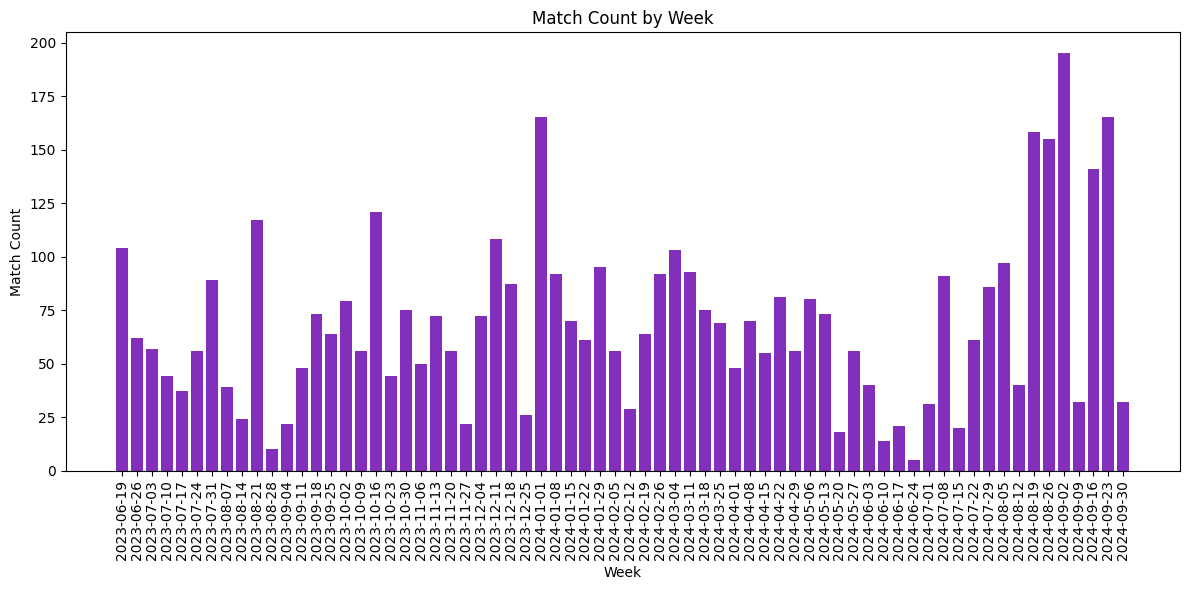

In [4]:
plt.figure(figsize=(12, 6))
plt.bar(df['WeekStartDate'], df['MatchCount'], color='#822fbb')
plt.xlabel('Week')
plt.ylabel('Match Count')
plt.title('Match Count by Week')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Monthly matches

In [5]:
df = pd.read_sql_query('''SELECT 
    strftime('%Y-%m', datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime')) AS YearMonth,
    COUNT(*) AS MatchCount
FROM MatchStats
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND EXISTS (
        SELECT 1
        FROM json_each(Players) AS player
        WHERE json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
    )
GROUP BY YearMonth
ORDER BY YearMonth;
''', conn)

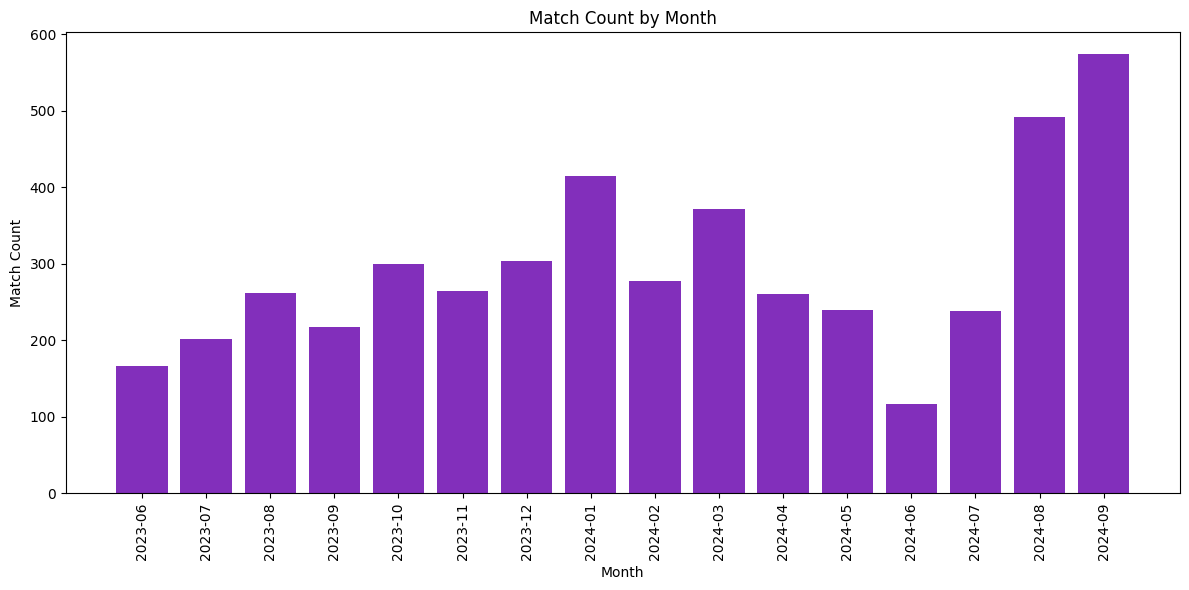

In [6]:
plt.figure(figsize=(12, 6))
plt.bar(df['YearMonth'], df['MatchCount'], color='#822fbb')
plt.xlabel('Month')
plt.ylabel('Match Count')
plt.title('Match Count by Month')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Players I played with

In [10]:
df = pd.read_sql_query('''WITH PlayerTeam AS (
    SELECT 
        MatchId, 
        json_extract(player.value, '$.LastTeamId') AS TeamId
    FROM MatchStats, json_each(Players) AS player
    WHERE json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00'
)
SELECT 
    json_extract(otherPlayer.value, '$.PlayerId') AS PlayerId,
    COUNT(DISTINCT MatchStats.MatchId) AS UniqueMatchCount
FROM MatchStats, json_each(Players) AS otherPlayer
WHERE 
    MatchStats.MatchId IN (SELECT MatchId FROM PlayerTeam) 
    AND json_extract(otherPlayer.value, '$.LastTeamId') = (SELECT TeamId FROM PlayerTeam WHERE PlayerTeam.MatchId = MatchStats.MatchId)
GROUP BY PlayerId
ORDER BY UniqueMatchCount DESC
''', conn)

## Players I played against

In [ ]:
df = pd.read_sql_query('''WITH PlayerTeam AS (
    SELECT 
        MatchId, 
        json_extract(player.value, '$.LastTeamId') AS TeamId
    FROM MatchStats, json_each(Players) AS player
    WHERE json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00'
)
SELECT 
    json_extract(otherPlayer.value, '$.PlayerId') AS PlayerId,
    COUNT(DISTINCT MatchStats.MatchId) AS UniqueMatchCount
FROM MatchStats, json_each(Players) AS otherPlayer
WHERE 
    MatchStats.MatchId IN (SELECT MatchId FROM PlayerTeam) 
    AND json_extract(otherPlayer.value, '$.LastTeamId') != (SELECT TeamId FROM PlayerTeam WHERE PlayerTeam.MatchId = MatchStats.MatchId)
GROUP BY PlayerId
ORDER BY UniqueMatchCount DESC
''', conn)

## Games in progress I've joined

In [9]:
df = pd.read_sql_query('''SELECT
	COUNT(DISTINCT MatchId) Matches,
    date(datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime', 'weekday 0', '-6 days')) AS WeekStartDate,
    json_extract(player.value, '$.Outcome') AS Outcome
FROM MatchStats, json_each(Players) AS player
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
	AND json_extract(player.value, '$.ParticipationInfo.JoinedInProgress') = true
GROUP BY WeekStartDate, Outcome
ORDER BY WeekStartDate ASC;
''', conn)

df.head(10)

Matches WeekStartDate  Outcome
0        3    2023-06-19        3
1        2    2023-06-26        2
2        2    2023-06-26        3
3        2    2023-07-03        2
4        2    2023-07-03        3
5        1    2023-07-03        4
6        1    2023-07-10        2
7        4    2023-07-10        3
8        1    2023-07-17        2
9        4    2023-07-31        2

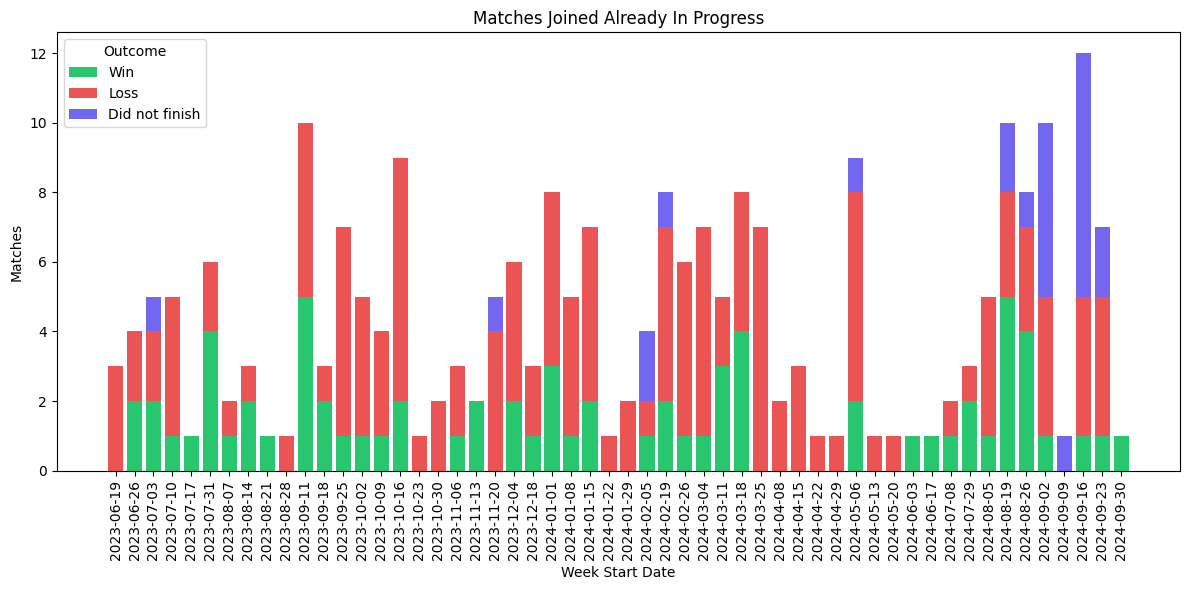

In [10]:
outcome_info = {
    1: {'label': 'Tie', 'color': '#7367F0'},
    2: {'label': 'Win', 'color': '#28C76F'},
    3: {'label': 'Loss', 'color': '#EA5455'},
    4: {'label': 'Did not finish', 'color': '#7367F0'}
}



stacked_data = df.pivot_table(index='WeekStartDate', columns='Outcome', values='Matches', fill_value=0)

plt.figure(figsize=(12, 6))

bottom_values = [0] * len(stacked_data)

for outcome, info in outcome_info.items():
    if outcome in stacked_data.columns:
        plt.bar(stacked_data.index, stacked_data[outcome], 
                color=info['color'], 
                label=info['label'], 
                bottom=bottom_values)

        bottom_values = [bottom + stacked_data[outcome].values[i] for i, bottom in enumerate(bottom_values)]
        
plt.xlabel('Week Start Date')
plt.ylabel('Matches')
plt.title('Matches Joined Already In Progress')
plt.xticks(rotation=90)
plt.tight_layout()

plt.legend(title='Outcome', loc='upper left')
plt.show()

In [11]:
df = pd.read_sql_query('''SELECT
	COUNT(DISTINCT MatchId) Matches,
    strftime('%Y-%m', datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime')) AS YearMonth,
    json_extract(player.value, '$.Outcome') AS Outcome
FROM MatchStats, json_each(Players) AS player
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
	AND json_extract(player.value, '$.ParticipationInfo.JoinedInProgress') = true
GROUP BY YearMonth, Outcome
ORDER BY YearMonth ASC;
''', conn)

df.head(10)

Matches YearMonth  Outcome
0        2   2023-06        2
1        5   2023-06        3
2        5   2023-07        2
3        6   2023-07        3
4        1   2023-07        4
5        7   2023-08        2
6        4   2023-08        3
7        8   2023-09        2
8       13   2023-09        3
9        4   2023-10        2

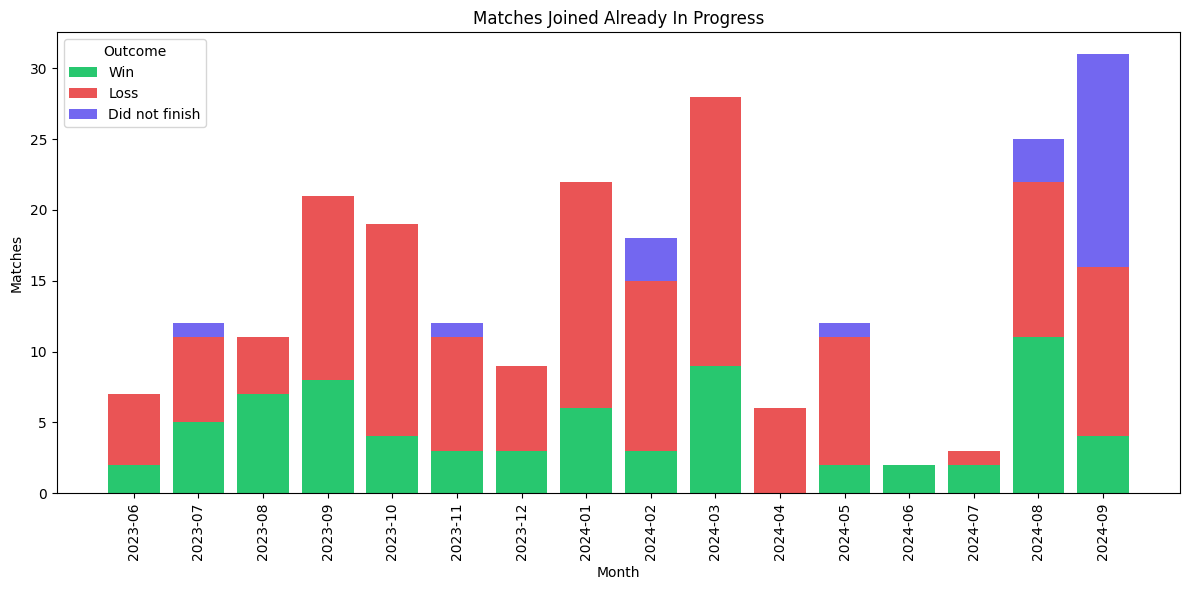

In [12]:
outcome_info = {
    1: {'label': 'Tie', 'color': '#7367F0'},
    2: {'label': 'Win', 'color': '#28C76F'},
    3: {'label': 'Loss', 'color': '#EA5455'},
    4: {'label': 'Did not finish', 'color': '#7367F0'}
}

stacked_data = df.pivot_table(index='YearMonth', columns='Outcome', values='Matches', fill_value=0)

plt.figure(figsize=(12, 6))

bottom_values = [0] * len(stacked_data)

for outcome, info in outcome_info.items():
    if outcome in stacked_data.columns:
        plt.bar(stacked_data.index, stacked_data[outcome], 
                color=info['color'], 
                label=info['label'], 
                bottom=bottom_values)
        # Update the bottom values for stacking
        bottom_values = [bottom + stacked_data[outcome].values[i] for i, bottom in enumerate(bottom_values)]
        
plt.xlabel('Month')
plt.ylabel('Matches')
plt.title('Matches Joined Already In Progress')
plt.xticks(rotation=90)
plt.tight_layout()

plt.legend(title='Outcome', loc='upper left')

plt.show()

## Games in progress I left

In [13]:
df = pd.read_sql_query('''SELECT
	COUNT(DISTINCT MatchId) Matches,
    date(datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime', 'weekday 0', '-6 days')) AS WeekStartDate,
    json_extract(player.value, '$.Outcome') AS Outcome
FROM MatchStats, json_each(Players) AS player
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
	AND json_extract(player.value, '$.ParticipationInfo.LeftInProgress') = true
GROUP BY WeekStartDate, Outcome
ORDER BY WeekStartDate ASC;
''', conn)

df.head(10)

Matches WeekStartDate  Outcome
0        1    2023-07-03        4
1        1    2023-07-24        4
2        1    2023-07-31        4
3        1    2023-08-21        4
4        1    2023-09-18        4
5        2    2023-09-25        4
6        1    2023-10-02        4
7        3    2023-10-16        4
8        4    2023-10-30        4
9        3    2023-11-06        4

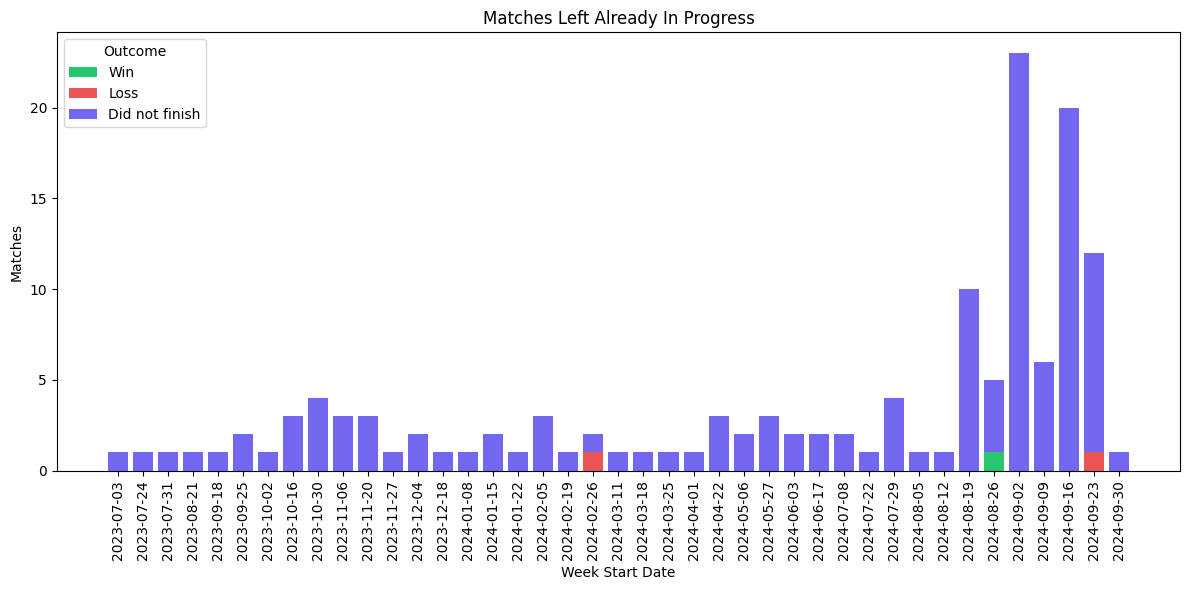

In [14]:
outcome_info = {
    1: {'label': 'Tie', 'color': '#7367F0'},
    2: {'label': 'Win', 'color': '#28C76F'},
    3: {'label': 'Loss', 'color': '#EA5455'},
    4: {'label': 'Did not finish', 'color': '#7367F0'}
}

stacked_data = df.pivot_table(index='WeekStartDate', columns='Outcome', values='Matches', fill_value=0)

plt.figure(figsize=(12, 6))

bottom_values = [0] * len(stacked_data)

for outcome, info in outcome_info.items():
    if outcome in stacked_data.columns:
        plt.bar(stacked_data.index, stacked_data[outcome], 
                color=info['color'], 
                label=info['label'], 
                bottom=bottom_values)
        bottom_values = [bottom + stacked_data[outcome].values[i] for i, bottom in enumerate(bottom_values)]
        
plt.xlabel('Week Start Date')
plt.ylabel('Matches')
plt.title('Matches Left Already In Progress')
plt.xticks(rotation=90)
plt.tight_layout()

plt.legend(title='Outcome', loc='upper left')

plt.show()

In [15]:
df = pd.read_sql_query('''SELECT
	COUNT(DISTINCT MatchId) Matches,
    strftime('%Y-%m', datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime')) AS YearMonth,
    json_extract(player.value, '$.Outcome') AS Outcome
FROM MatchStats, json_each(Players) AS player
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
	AND json_extract(player.value, '$.ParticipationInfo.LeftInProgress') = true
GROUP BY YearMonth, Outcome
ORDER BY YearMonth ASC;
''', conn)

df.head(10)

Matches YearMonth  Outcome
0        2   2023-07        4
1        2   2023-08        4
2        3   2023-09        4
3        4   2023-10        4
4       11   2023-11        4
5        3   2023-12        4
6        4   2024-01        4
7        1   2024-02        3
8        5   2024-02        4
9        3   2024-03        4

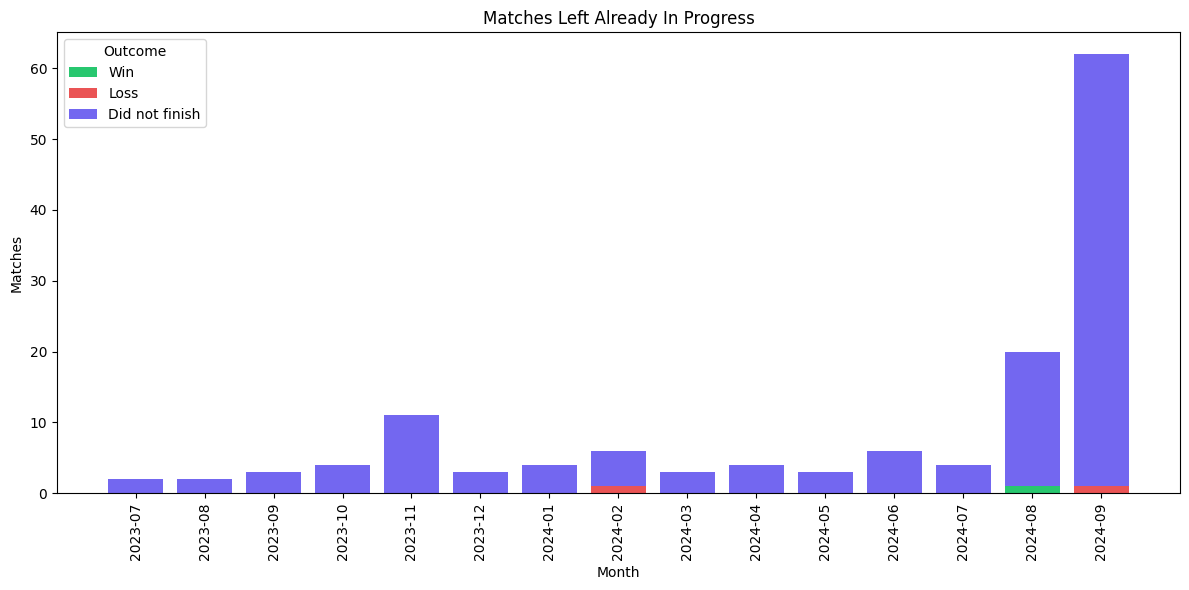

In [16]:
outcome_info = {
    1: {'label': 'Tie', 'color': '#7367F0'},
    2: {'label': 'Win', 'color': '#28C76F'},
    3: {'label': 'Loss', 'color': '#EA5455'},
    4: {'label': 'Did not finish', 'color': '#7367F0'}
}

stacked_data = df.pivot_table(index='YearMonth', columns='Outcome', values='Matches', fill_value=0)

plt.figure(figsize=(12, 6))
bottom_values = [0] * len(stacked_data)
for outcome, info in outcome_info.items():
    if outcome in stacked_data.columns:
        plt.bar(stacked_data.index, stacked_data[outcome], 
                color=info['color'], 
                label=info['label'], 
                bottom=bottom_values)

        bottom_values = [bottom + stacked_data[outcome].values[i] for i, bottom in enumerate(bottom_values)]
plt.xlabel('Month')
plt.ylabel('Matches')
plt.title('Matches Left Already In Progress')
plt.xticks(rotation=90)
plt.tight_layout()

plt.legend(title='Outcome', loc='upper left')

plt.show()

## Maps I quit the match on

In [17]:
df = pd.read_sql_query('''SELECT
    COUNT(DISTINCT MatchId) AS Matches,
    json_extract(MatchInfo, '$.MapVariant.AssetId') AS AssetId,
    Maps.PublicName
FROM MatchStats, json_each(Players) AS player
JOIN Maps ON json_extract(MatchInfo, '$.MapVariant.AssetId') = Maps.AssetId
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
    AND json_extract(player.value, '$.ParticipationInfo.LeftInProgress') = true
GROUP BY AssetId, Maps.PublicName  -- Group by AssetId and PublicName
ORDER BY Matches DESC;
''', conn)

df.head(10)

Matches                               AssetId          PublicName
0       49  525451ca-0bfa-4b5c-8a0f-29524e0f2834            Disciple
1       12  2c9df7e9-89e7-430a-8615-32474d4617c1           Formation
2        5  8be179f7-8940-4868-b881-44cad1ca8711               Corpo
3        5  aab54656-a45c-4724-8205-6778ae62db64               Ronin
4        4  1612a412-a7bc-49eb-829f-cea9d537052d  Scarlett's Landing
5        4  37a9b5f0-6be7-4a46-8010-1fe6f7ea5611             Ruujaya
6        4  50a1a3b5-c54d-4e40-8744-b92051d48897          Diminished
7        4  88d45250-97dd-4a28-8fb2-b52baaeebb39             Pharaoh
8        3  2bfd7643-1091-40b1-a889-2c5fc6367c25          Smallhalla
9        3  c395f3ac-4614-45f9-a83a-56f69e8ae962            Aquarius

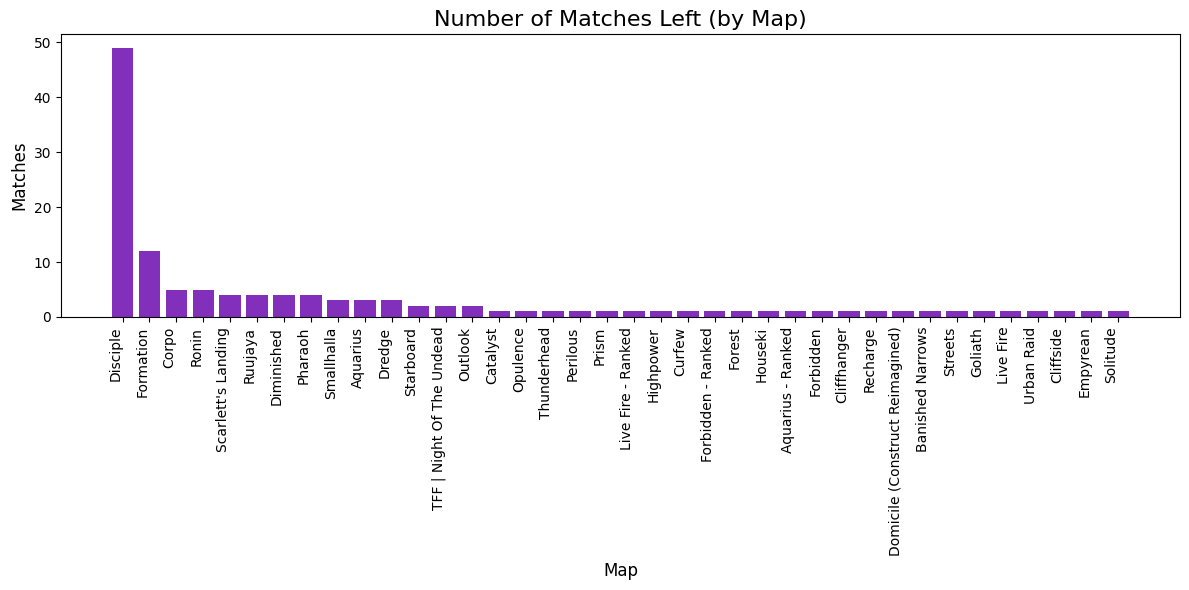

In [18]:
plt.figure(figsize=(12, 6))  # Set the figure size
plt.bar(df['PublicName'], df['Matches'], color='#822fbb')

plt.title('Number of Matches Left (by Map)', fontsize=16)
plt.xlabel('Map', fontsize=12)
plt.ylabel('Matches', fontsize=12)
plt.xticks(rotation=90, ha='right')

plt.tight_layout()
plt.show()

## Breakdown of matches played by game variant

In [19]:
df = pd.read_sql_query('''SELECT 
    json_extract(MatchStats.MatchInfo, '$.UgcGameVariant.AssetId') AS UgcGameVariantAssetId,
    GameVariants.PublicName,
    COUNT(DISTINCT MatchId) AS Matches
FROM MatchStats
JOIN GameVariants 
    ON json_extract(MatchStats.MatchInfo, '$.UgcGameVariant.AssetId') = GameVariants.AssetId
WHERE 
    datetime(json_extract(MatchStats.MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00'
    AND json_extract(MatchStats.MatchInfo, '$.LifecycleMode') = 3
GROUP BY UgcGameVariantAssetId
ORDER BY Matches DESC;
''', conn)

df.head(10)

UgcGameVariantAssetId                           PublicName  \
0  0e198591-ac15-4f99-8ff2-dd390decad66                 Super Husky Raid:CTF   
1  2fa07c0b-88e8-4453-8b3b-dc8c66c49ae0                       Husky Raid:CTF   
2  dc2e83f5-1afd-4612-9f27-63fd41df6db7                      Tactical:Slayer   
3  44f272c6-c783-4154-91da-849f08c17161               Ranked:Tactical Slayer   
4  53af082c-bf21-4867-bea4-c038d10d133f               Tactical:Slayer Bandit   
5  71689416-ec07-4f30-86a9-8229ebc20762                    Arena:Team Slayer   
6  729aea56-8b9e-4e72-ad82-ad9758d4f4b6  Arena:FFA Rock 'n' Repulsors Slayer   
7  1e8cd10b-1496-423b-8699-f98f6f5db67e                         Arena:Slayer   
8  c2d20d44-8606-4669-b894-afae15b3524f                        Ranked:Slayer   
9  43eba883-7984-420a-90ee-4d64f4df55d6                      Event:Infection   

   Matches  
0     1842  
1      777  
2      486  
3      324  
4      167  
5      113  
6      111  
7       88  
8       86  
9       80

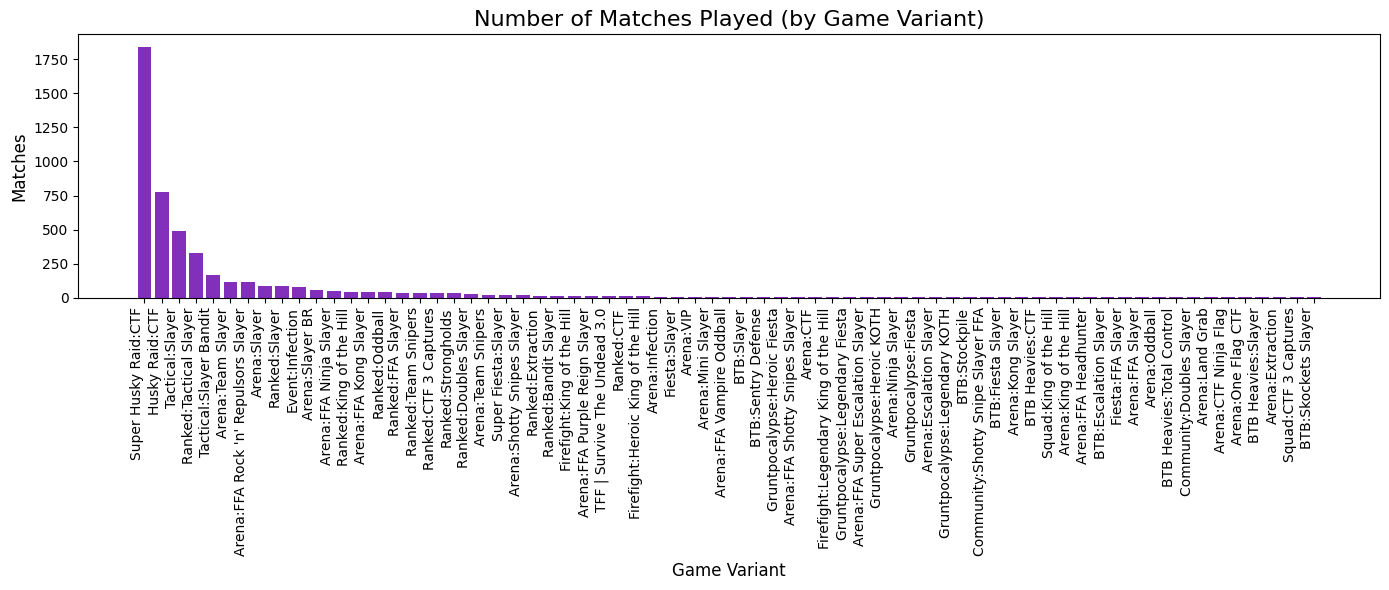

In [20]:
plt.figure(figsize=(14, 6))  # Set the figure size
plt.bar(df['PublicName'], df['Matches'], color='#822fbb')

plt.title('Number of Matches Played (by Game Variant)', fontsize=16)
plt.xlabel('Game Variant', fontsize=12)
plt.ylabel('Matches', fontsize=12)
plt.xticks(rotation=90, ha='right')

plt.tight_layout()
plt.show()

## Breakdown of matches played by map

In [21]:
df = pd.read_sql_query('''SELECT 
    json_extract(MatchStats.MatchInfo, '$.MapVariant.AssetId') AS MapVariantAssetId,
    Maps.PublicName,
    COUNT(DISTINCT MatchId) AS Matches
FROM MatchStats
JOIN Maps 
    ON json_extract(MatchStats.MatchInfo, '$.MapVariant.AssetId') = Maps.AssetId
WHERE 
    datetime(json_extract(MatchStats.MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00'
    AND json_extract(MatchStats.MatchInfo, '$.LifecycleMode') = 3
GROUP BY MapVariantAssetId
ORDER BY Matches DESC;
''', conn)

df.head(10)

MapVariantAssetId         PublicName  Matches
0  8be179f7-8940-4868-b881-44cad1ca8711              Corpo      246
1  50a1a3b5-c54d-4e40-8744-b92051d48897         Diminished      241
2  ea7b30e6-d1b9-4c2c-a9e0-de955c48525d            Outlook      180
3  2c9df7e9-89e7-430a-8615-32474d4617c1          Formation      166
4  be848f91-3d87-4b80-8eb9-df3b52cb8d10         Urban Raid      164
5  88d45250-97dd-4a28-8fb2-b52baaeebb39            Pharaoh      160
6  37a9b5f0-6be7-4a46-8010-1fe6f7ea5611            Ruujaya      160
7  e67f1328-48b5-4d63-a577-4e03a5ee0673          Megapolis      153
8  7dfec55d-d968-4a38-aa68-bc31e8874cfd  Merchant's Square      150
9  aab54656-a45c-4724-8205-6778ae62db64              Ronin      141

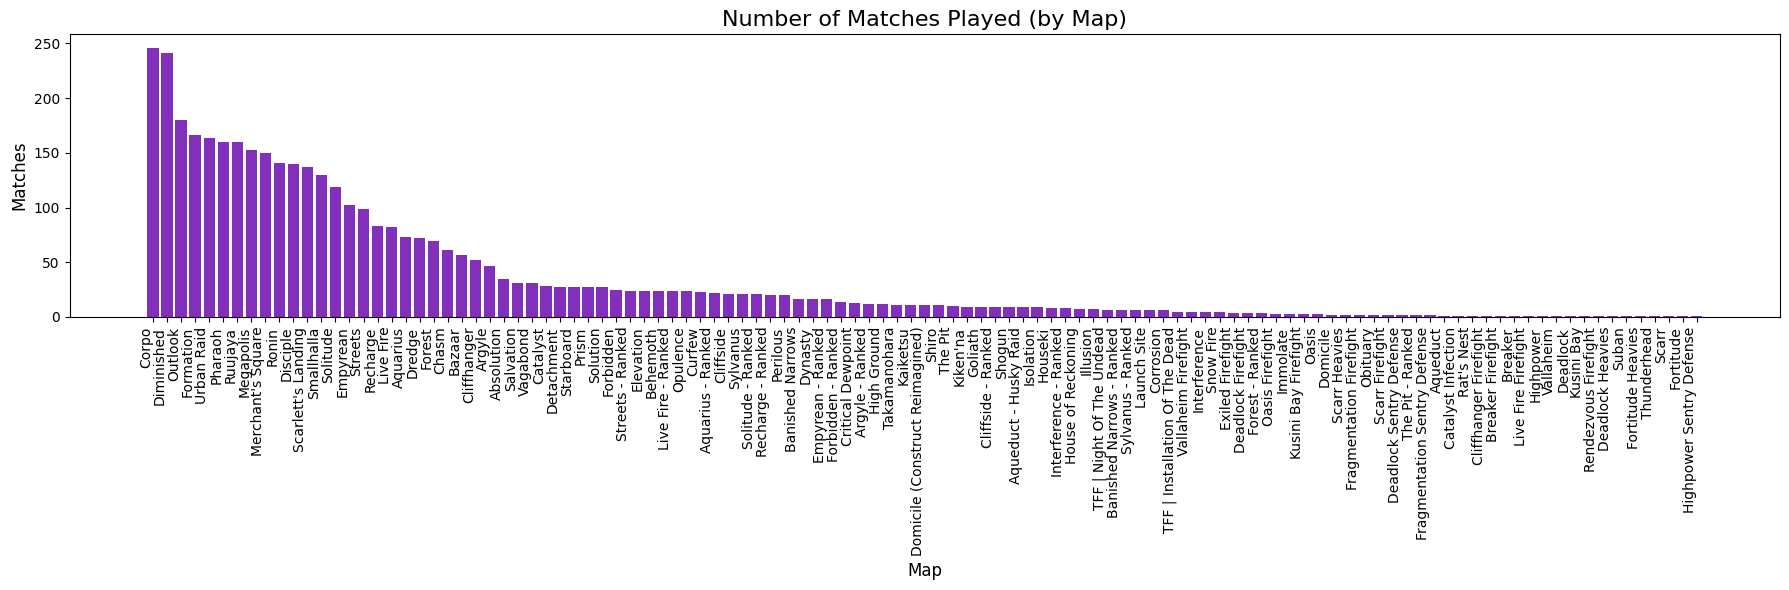

In [22]:
plt.figure(figsize=(18, 6))  # Set the figure size
plt.bar(df['PublicName'], df['Matches'], color='#822fbb')

plt.title('Number of Matches Played (by Map)', fontsize=16)
plt.xlabel('Map', fontsize=12)
plt.ylabel('Matches', fontsize=12)
plt.xticks(rotation=90, ha='right')

plt.tight_layout()
plt.show()

## Weekly outcomes

In [23]:
df = pd.read_sql_query('''SELECT
	COUNT(DISTINCT MatchId) Matches,
    date(datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime', 'weekday 0', '-6 days')) AS WeekStartDate,
    json_extract(player.value, '$.Outcome') AS Outcome
FROM MatchStats, json_each(Players) AS player
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
GROUP BY WeekStartDate, Outcome
ORDER BY WeekStartDate ASC;
''', conn)

df.head(10)

Matches WeekStartDate  Outcome
0        1    2023-06-19        1
1       38    2023-06-19        2
2       65    2023-06-19        3
3       23    2023-06-26        2
4       39    2023-06-26        3
5       24    2023-07-03        2
6       32    2023-07-03        3
7        1    2023-07-03        4
8       21    2023-07-10        2
9       23    2023-07-10        3

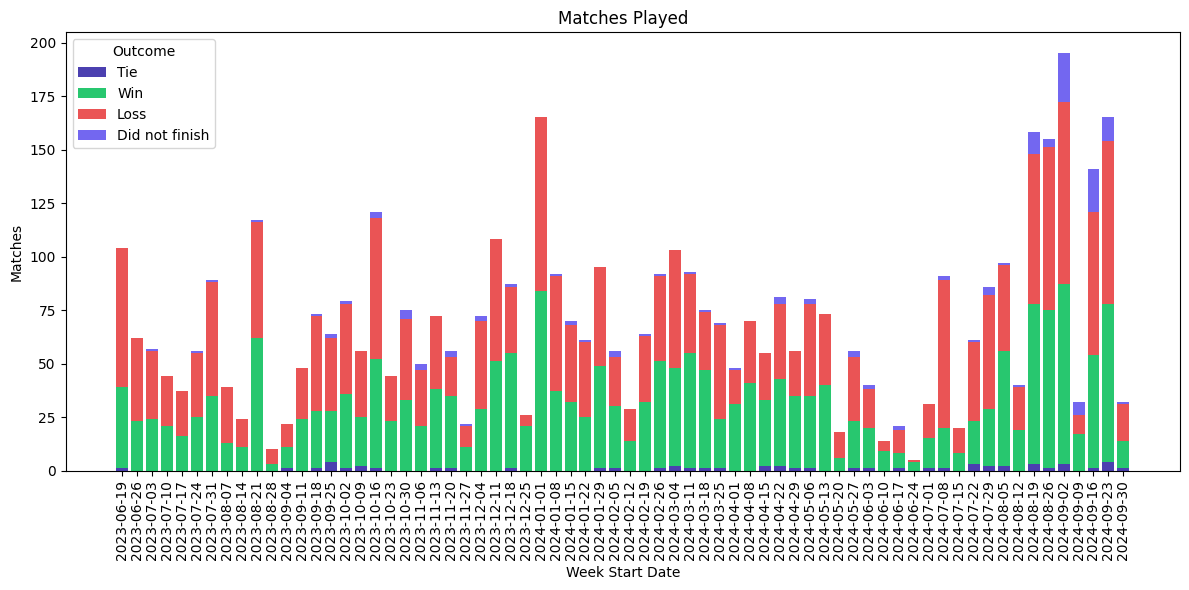

In [24]:
outcome_info = {
    1: {'label': 'Tie', 'color': '#4B40B0'},
    2: {'label': 'Win', 'color': '#28C76F'},
    3: {'label': 'Loss', 'color': '#EA5455'},
    4: {'label': 'Did not finish', 'color': '#7367F0'}
}

stacked_data = df.pivot_table(index='WeekStartDate', columns='Outcome', values='Matches', fill_value=0)

plt.figure(figsize=(12, 6))

bottom_values = [0] * len(stacked_data)

for outcome, info in outcome_info.items():
    if outcome in stacked_data.columns:
        plt.bar(stacked_data.index, stacked_data[outcome], 
                color=info['color'], 
                label=info['label'], 
                bottom=bottom_values)

        bottom_values = [bottom + stacked_data[outcome].values[i] for i, bottom in enumerate(bottom_values)]
        
plt.xlabel('Week Start Date')
plt.ylabel('Matches')
plt.title('Matches Played')
plt.xticks(rotation=90)
plt.tight_layout()

plt.legend(title='Outcome', loc='upper left')

plt.show()

## Win rate

In [25]:
df = pd.read_sql_query('''SELECT
    date(datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime', 'weekday 0', '-6 days')) AS WeekStartDate,
    COUNT(DISTINCT MatchId) AS TotalMatches,
    SUM(CASE 
        WHEN json_extract(player.value, '$.Outcome') = 2 THEN 1 
        WHEN json_extract(player.value, '$.Outcome') = 1 THEN 1 
        ELSE 0 
    END) AS WinsOrTies,
    ROUND(
        CAST(SUM(CASE 
            WHEN json_extract(player.value, '$.Outcome') = 2 THEN 1 
            WHEN json_extract(player.value, '$.Outcome') = 1 THEN 1 
            ELSE 0 
        END) AS FLOAT) / COUNT(DISTINCT MatchId), 2
    ) AS WinRatio
FROM MatchStats, json_each(Players) AS player
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
GROUP BY WeekStartDate
ORDER BY WeekStartDate ASC;
''', conn)

df.head(10)

WeekStartDate  TotalMatches  WinsOrTies  WinRatio
0    2023-06-19           104          39      0.38
1    2023-06-26            62          23      0.37
2    2023-07-03            57          24      0.42
3    2023-07-10            44          21      0.48
4    2023-07-17            37          16      0.43
5    2023-07-24            56          25      0.45
6    2023-07-31            89          35      0.39
7    2023-08-07            39          13      0.33
8    2023-08-14            24          11      0.46
9    2023-08-21           117          62      0.53

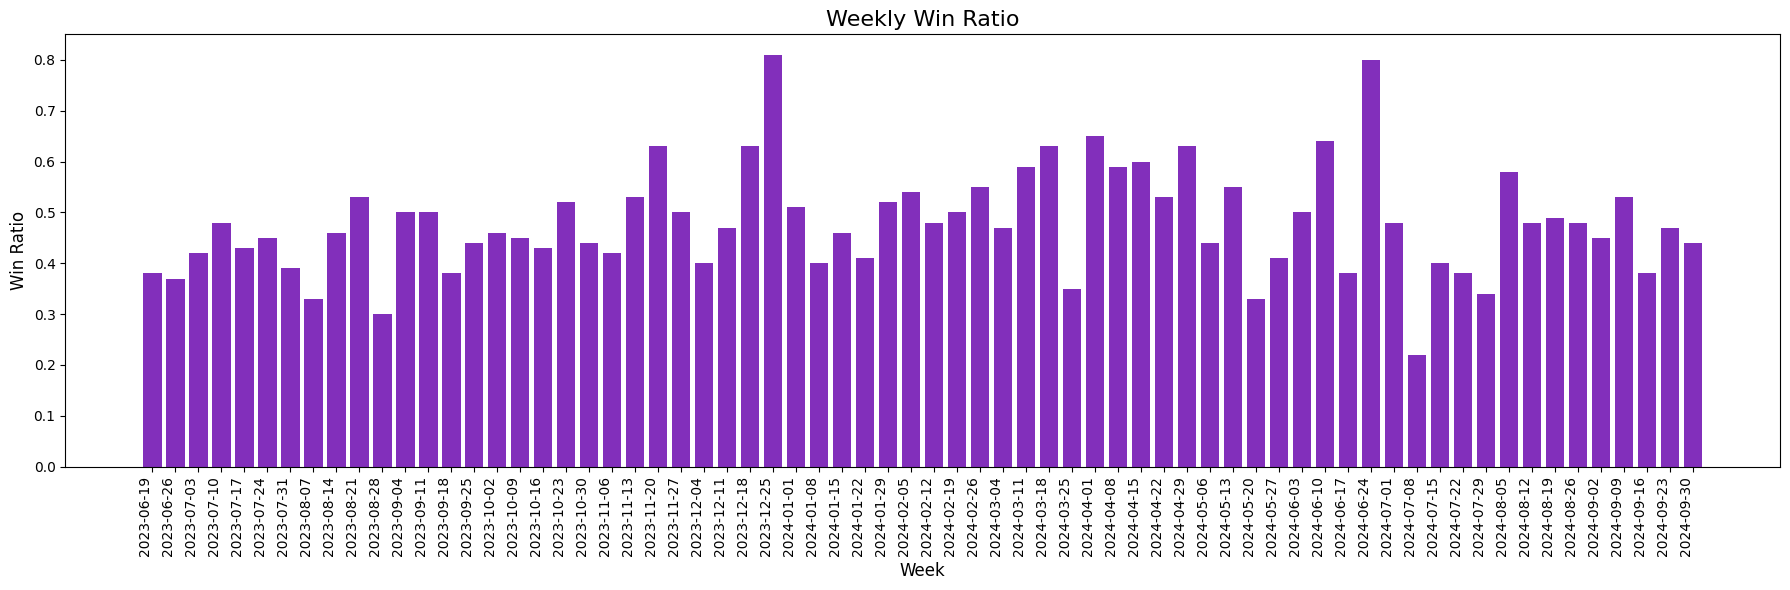

In [26]:
plt.figure(figsize=(18, 6))  # Set the figure size
plt.bar(df['WeekStartDate'], df['WinRatio'], color='#822fbb')

plt.title('Weekly Win Ratio', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Win Ratio', fontsize=12)
plt.xticks(rotation=90, ha='right')

plt.tight_layout()

plt.show()

## Median win ratio

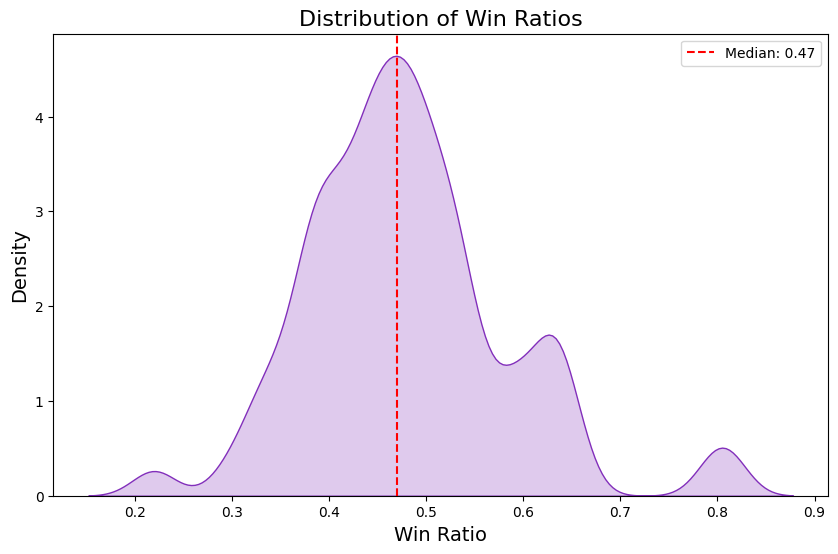

In [27]:
median_win_ratio = df['WinRatio'].median()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['WinRatio'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_win_ratio, color='red', linestyle='--', label=f'Median: {median_win_ratio:.2f}')

plt.title('Distribution of Win Ratios', fontsize=16)
plt.xlabel('Win Ratio', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.show()

## Winning streaks

In [28]:
df = pd.read_sql_query('''WITH RankedMatches AS (
    SELECT
        MatchId,
        date(datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime', 'weekday 0', '-6 days')) AS WeekStartDate,
        json_extract(player.value, '$.Outcome') AS Outcome,
        ROW_NUMBER() OVER (PARTITION BY date(datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime', 'weekday 0', '-6 days')) 
                           ORDER BY datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime')) AS RowNum
    FROM MatchStats, json_each(Players) AS player
    WHERE 
        datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
        AND json_extract(MatchInfo, '$.LifecycleMode') = 3
        AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
),
Streaks AS (
    SELECT
        WeekStartDate,
        Outcome,
        ROW_NUMBER() OVER (PARTITION BY WeekStartDate ORDER BY RowNum) - 
        ROW_NUMBER() OVER (PARTITION BY WeekStartDate, (CASE WHEN Outcome IN (1, 2) THEN 0 ELSE 1 END) ORDER BY RowNum) AS StreakGroup
    FROM RankedMatches
)
SELECT
    WeekStartDate,
    MAX(StreakLength) AS LongestWinningStreak
FROM (
    SELECT
        WeekStartDate,
        COUNT(*) AS StreakLength
    FROM Streaks
    WHERE Outcome IN (1, 2)  -- Include both wins and ties
    GROUP BY WeekStartDate, StreakGroup
)
GROUP BY WeekStartDate
ORDER BY WeekStartDate ASC;
''', conn)

df.head(10)

WeekStartDate  LongestWinningStreak
0    2023-06-19                     4
1    2023-06-26                     3
2    2023-07-03                     7
3    2023-07-10                     4
4    2023-07-17                     3
5    2023-07-24                     4
6    2023-07-31                     7
7    2023-08-07                     3
8    2023-08-14                     3
9    2023-08-21                     8

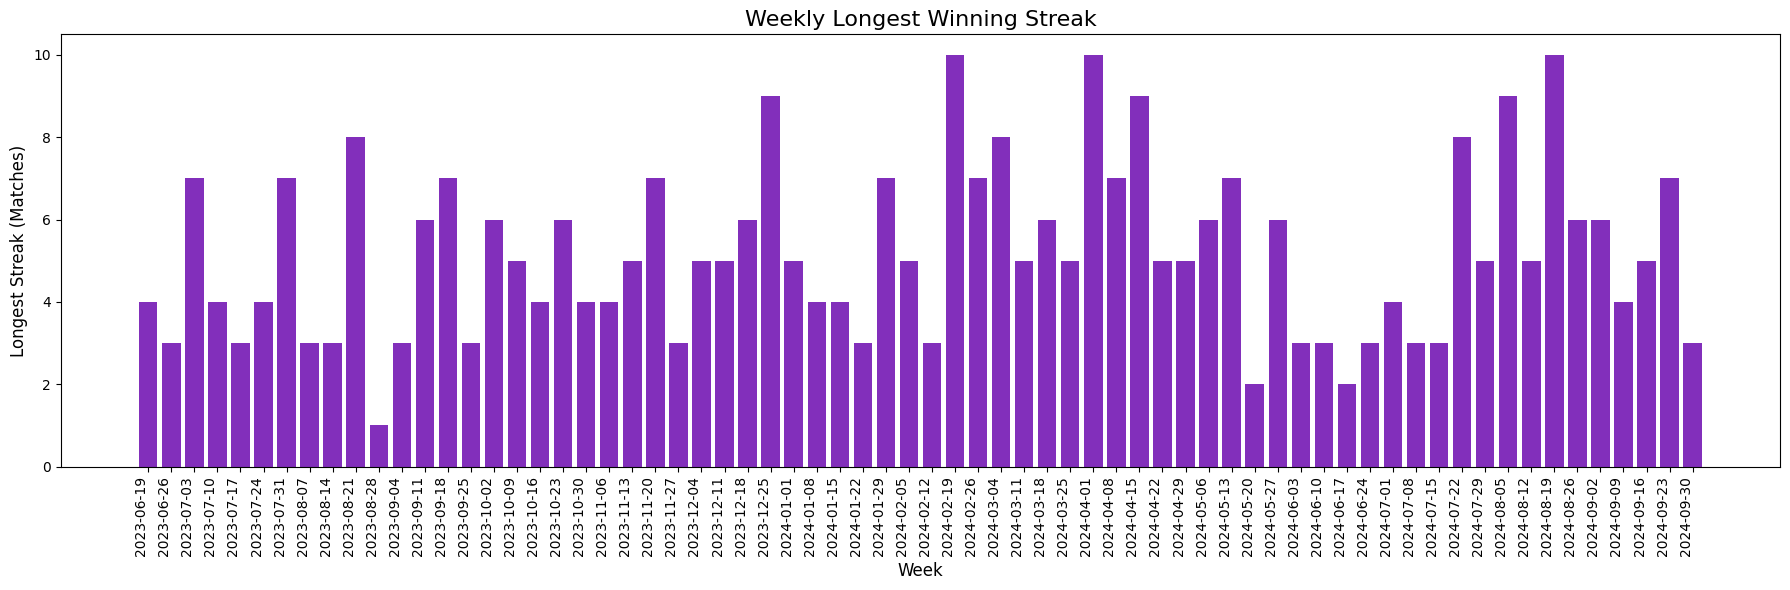

In [29]:
plt.figure(figsize=(18, 6))
plt.bar(df['WeekStartDate'], df['LongestWinningStreak'], color='#822fbb')

plt.title('Weekly Longest Winning Streak', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Longest Streak (Matches)', fontsize=12)
plt.xticks(rotation=90, ha='right')

plt.tight_layout()
plt.show()

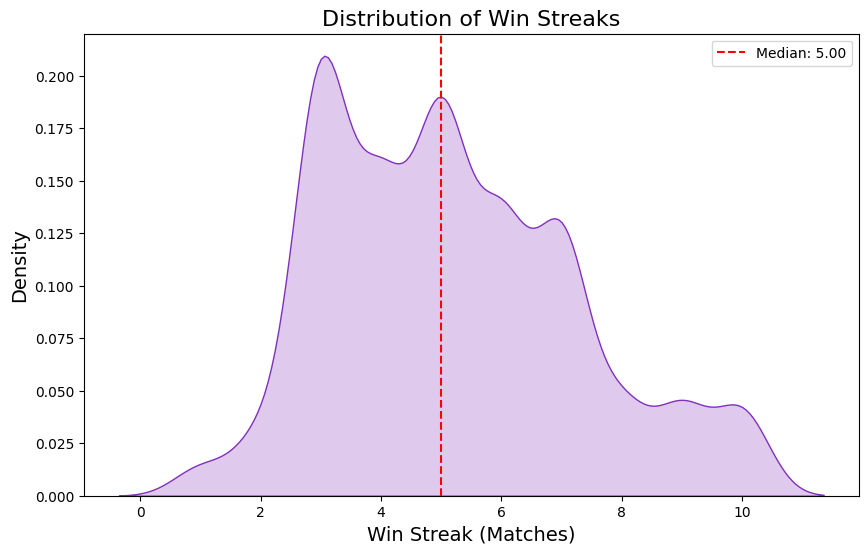

In [30]:
median_win_streak = df['LongestWinningStreak'].median()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['LongestWinningStreak'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_win_streak, color='red', linestyle='--', label=f'Median: {median_win_streak:.2f}')

plt.title('Distribution of Win Streaks', fontsize=16)
plt.xlabel('Win Streak (Matches)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.show()

## Losing streaks

In [31]:
df = pd.read_sql_query('''WITH RankedMatches AS (
    SELECT
        MatchId,
        date(datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime', 'weekday 0', '-6 days')) AS WeekStartDate,
        json_extract(player.value, '$.Outcome') AS Outcome,
        ROW_NUMBER() OVER (PARTITION BY date(datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime', 'weekday 0', '-6 days')) 
                           ORDER BY datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime')) AS RowNum
    FROM MatchStats, json_each(Players) AS player
    WHERE 
        datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
        AND json_extract(MatchInfo, '$.LifecycleMode') = 3
        AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
),
Streaks AS (
    SELECT
        WeekStartDate,
        Outcome,
        ROW_NUMBER() OVER (PARTITION BY WeekStartDate ORDER BY RowNum) - 
        ROW_NUMBER() OVER (PARTITION BY WeekStartDate, (CASE WHEN Outcome IN (3) THEN 0 ELSE 1 END) ORDER BY RowNum) AS StreakGroup
    FROM RankedMatches
)
SELECT
    WeekStartDate,
    MAX(StreakLength) AS LongestLosingStreak
FROM (
    SELECT
        WeekStartDate,
        COUNT(*) AS StreakLength
    FROM Streaks
    WHERE Outcome IN (3)  -- Include both wins and ties
    GROUP BY WeekStartDate, StreakGroup
)
GROUP BY WeekStartDate
ORDER BY WeekStartDate ASC;
''', conn)

df.head(10)

WeekStartDate  LongestLosingStreak
0    2023-06-19                    8
1    2023-06-26                    4
2    2023-07-03                    8
3    2023-07-10                    6
4    2023-07-17                    9
5    2023-07-24                    9
6    2023-07-31                   14
7    2023-08-07                   11
8    2023-08-14                    4
9    2023-08-21                    6

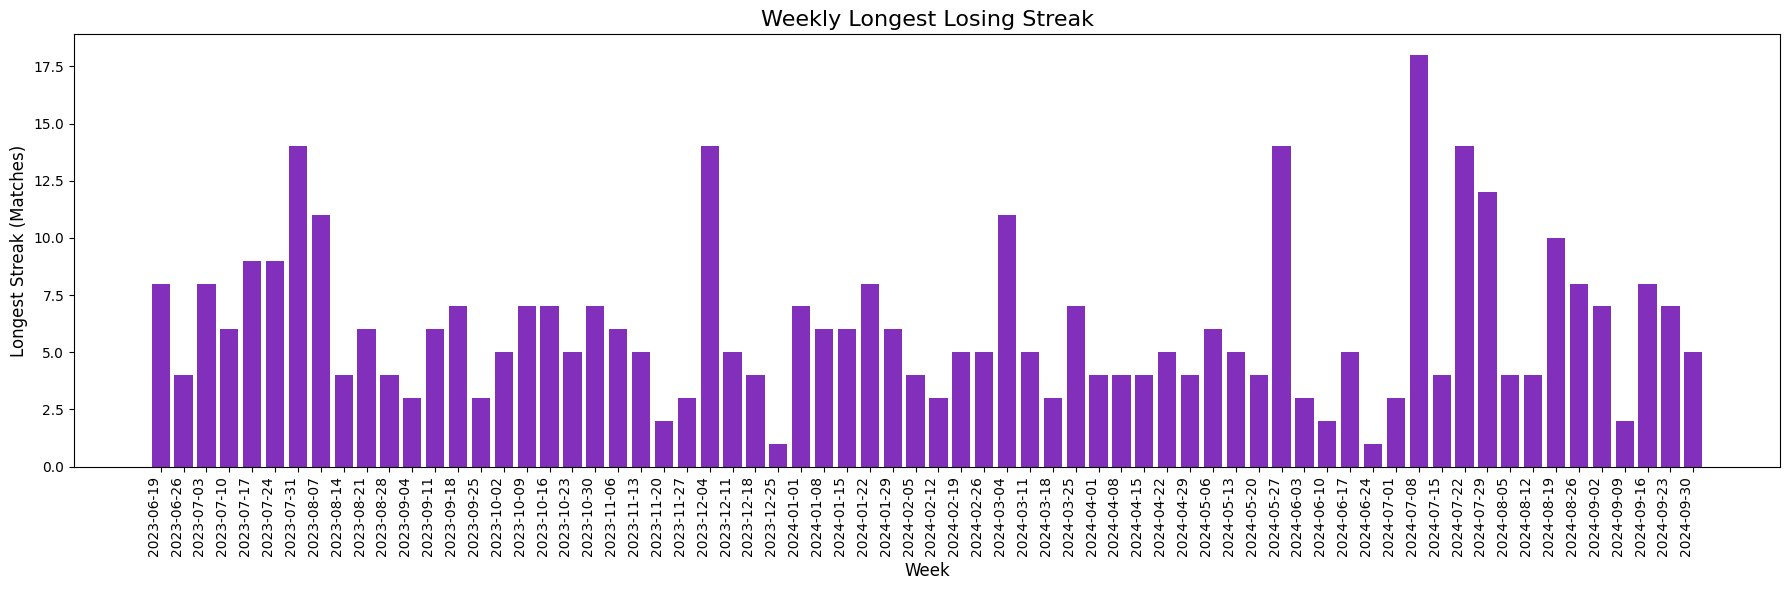

In [32]:
plt.figure(figsize=(18, 6))
plt.bar(df['WeekStartDate'], df['LongestLosingStreak'], color='#822fbb')

plt.title('Weekly Longest Losing Streak', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Longest Streak (Matches)', fontsize=12)
plt.xticks(rotation=90, ha='right')
plt.tight_layout()

plt.show()

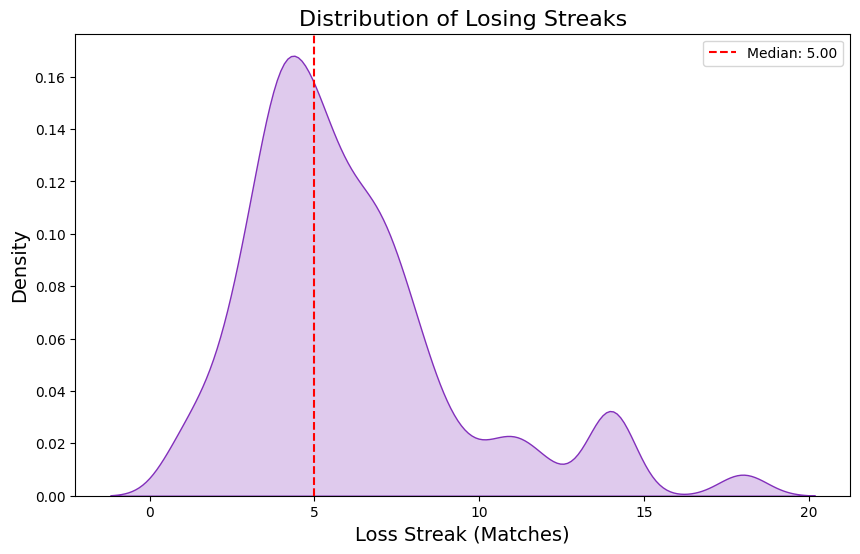

In [33]:
median_lose_streak = df['LongestLosingStreak'].median()
plt.figure(figsize=(10, 6))
sns.kdeplot(df['LongestLosingStreak'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_lose_streak, color='red', linestyle='--', label=f'Median: {median_lose_streak:.2f}')

plt.title('Distribution of Losing Streaks', fontsize=16)
plt.xlabel('Loss Streak (Matches)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.show()

## Match personal score

In [73]:
df = pd.read_sql_query('''SELECT
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') AS StartTime,
    MatchId,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.PersonalScore') AS PersonalScore
FROM MatchStats, json_each(Players) AS player
WHERE 
	datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
	AND json_extract(MatchInfo, '$.LifecycleMode') = 3
	AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
ORDER BY StartTime ASC
''', conn)

df.head(10)

StartTime                               MatchId  PersonalScore
0  2023-06-20 11:50:46  f16a7423-f9f4-470f-895e-9469e8132dac           1255
1  2023-06-20 12:02:21  9e93bf25-c9a7-45e8-ad50-e9b2f6da6b12           1350
2  2023-06-20 12:14:13  b6310997-144a-4e88-949e-516b2dd8c5df           1850
3  2023-06-20 12:26:10  8f5d828a-d447-4995-9ec0-74d776c987b8           1130
4  2023-06-20 13:08:06  34cab12e-8a19-4e78-84e1-fdfca8e182c2            690
5  2023-06-20 13:17:28  836e7403-4655-4552-8e70-f3352bef0890           1170
6  2023-06-20 13:32:37  22e65b58-6567-4593-a890-dc4b8a6d3699           1680
7  2023-06-20 13:49:06  ec0a8ee1-ccbf-4c8b-a6ec-c51078052fbe            950
8  2023-06-20 14:00:29  7963a124-e5b1-49fa-9763-8a779717c5c5            770
9  2023-06-20 14:16:34  bcafb0ca-f6fa-40f4-89e6-d3dd63b87f11           2060

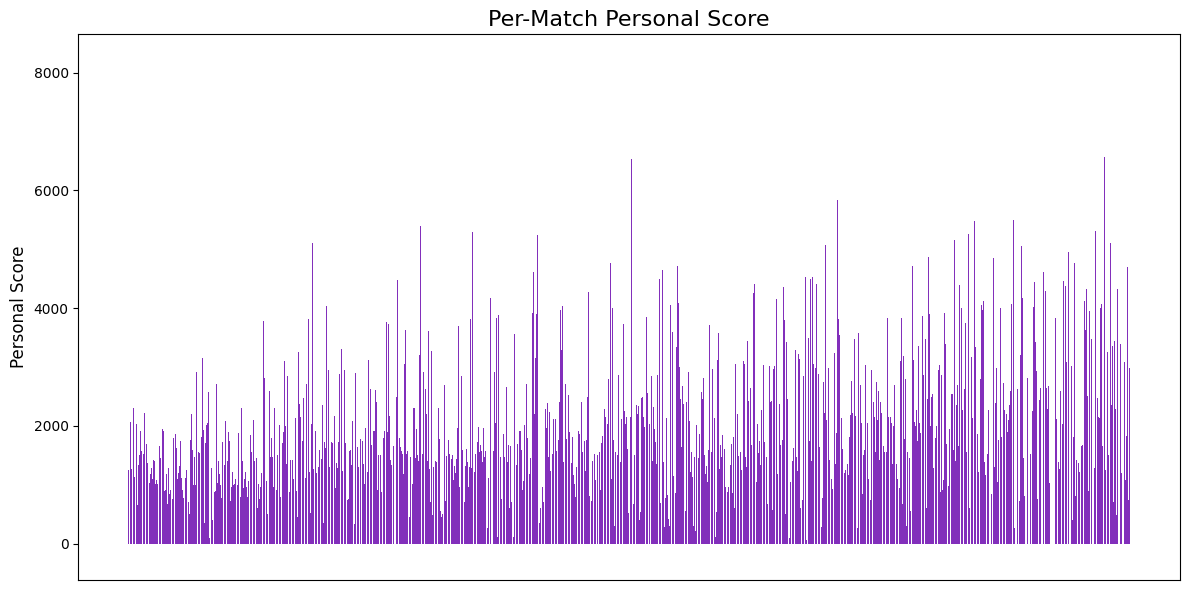

In [74]:
plt.figure(figsize=(12, 6))

plt.bar(df['MatchId'], df['PersonalScore'], color='#822fbb')

plt.title('Per-Match Personal Score', fontsize=16)
plt.ylabel('Personal Score', fontsize=12)

plt.gca().xaxis.set_visible(False)

plt.tight_layout()

plt.show()

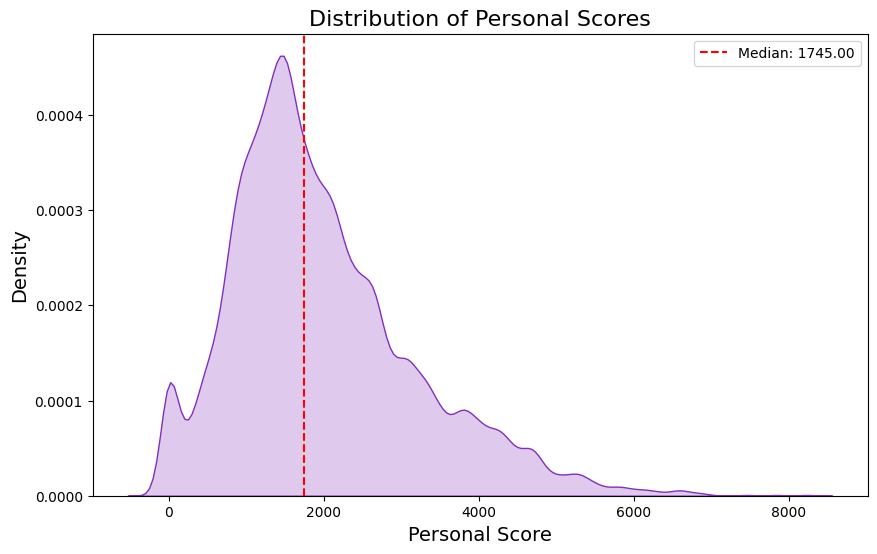

In [36]:
median_personal_score = df['PersonalScore'].median()

plt.figure(figsize=(10, 6))
sns.kdeplot(df['PersonalScore'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_personal_score, color='red', linestyle='--', label=f'Median: {median_personal_score:.2f}')

plt.title('Distribution of Personal Scores', fontsize=16)
plt.xlabel('Personal Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.show()

## Weekly personal score

In [37]:
df = pd.read_sql_query('''SELECT
    date(datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime', 'weekday 0', '-6 days')) AS WeekStartDate,
    SUM(CAST(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.PersonalScore') AS INTEGER)) AS TotalPersonalScore
FROM MatchStats, json_each(Players) AS player
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
GROUP BY WeekStartDate
ORDER BY WeekStartDate ASC;
''', conn)

df.head(10)

WeekStartDate  TotalPersonalScore
0    2023-06-19              146295
1    2023-06-26               84510
2    2023-07-03               72885
3    2023-07-10               52315
4    2023-07-17               49290
5    2023-07-24               94530
6    2023-07-31              130470
7    2023-08-07               47160
8    2023-08-14               29760
9    2023-08-21              151415

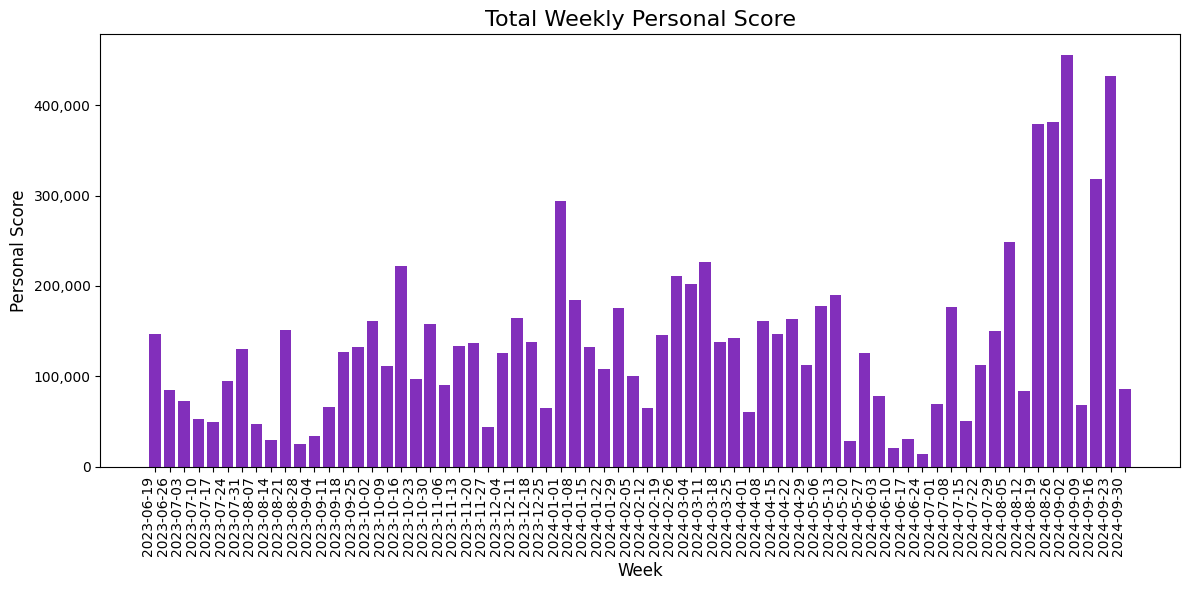

In [38]:
import matplotlib.ticker as mtick

plt.figure(figsize=(12, 6))

plt.bar(df['WeekStartDate'], df['TotalPersonalScore'], color='#822fbb')

plt.title('Total Weekly Personal Score', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Personal Score', fontsize=12)
plt.xticks(rotation=90, ha='right')

plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.tight_layout()
plt.show()

### Isolated to Super Husky Raid

In [39]:
df = pd.read_sql_query('''SELECT
    MatchId,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.PersonalScore') AS PersonalScore
FROM MatchStats, json_each(Players) AS player
WHERE 
	datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
	AND json_extract(MatchInfo, '$.LifecycleMode') = 3
	AND json_extract(MatchInfo, '$.UgcGameVariant.AssetId') = '0e198591-ac15-4f99-8ff2-dd390decad66'
	AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
''', conn)

df.head(10)

MatchId  PersonalScore
0  9c83a3ae-feab-4498-8a5d-f7b09833982d            900
1  d0a66ca6-1a39-41ec-afe6-6d98e9bfbcd5           2105
2  2bee1c75-17af-4624-a9b5-76bbe846b7bb           3750
3  75190e3a-a2f0-41b1-9ffc-9a7fc9efe5d9           3980
4  3f85e2c9-23de-4f3b-b2cb-4584d6da3598           1500
5  49bffea6-aa6f-4880-9c33-1b415f0cf28a           5065
6  8e7c42b4-8233-4afd-b283-991e3d5c4074           1160
7  10b9d038-4ab8-4209-9ddb-e85038d1a85d              0
8  1b2f85cc-0518-4e68-bc0a-5a5398e55d27           1885
9  e5063c19-f61f-4487-b919-e841c0c43216           2225

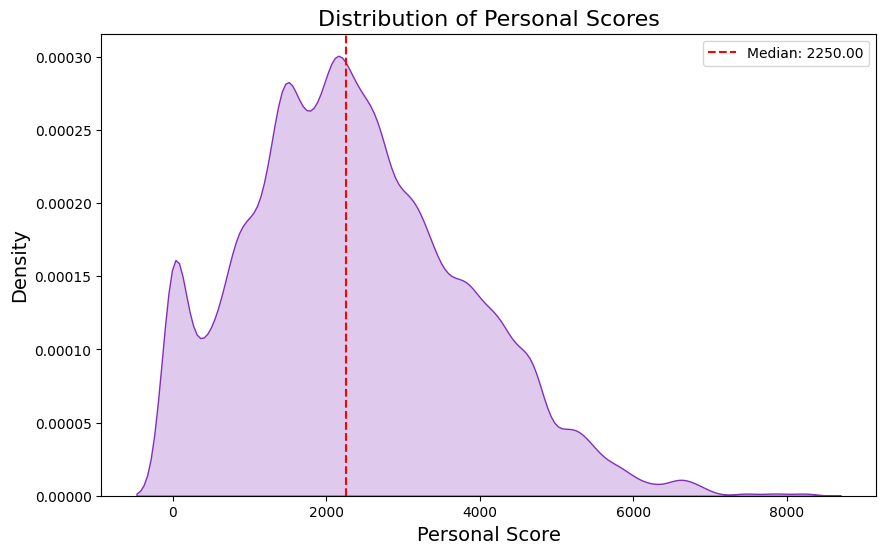

In [40]:
median_personal_score = df['PersonalScore'].median()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['PersonalScore'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_personal_score, color='red', linestyle='--', label=f'Median: {median_personal_score:.2f}')

plt.title('Distribution of Personal Scores', fontsize=16)
plt.xlabel('Personal Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.show()

## Median kills

In [41]:
df = pd.read_sql_query('''SELECT
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Kills') AS Kills
FROM MatchStats, json_each(Players) AS player
WHERE 
	datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
	AND json_extract(MatchInfo, '$.LifecycleMode') = 3
	AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
''', conn)

df.head(10)

Kills
0      9
1     10
2     29
3     12
4     18
5     23
6     30
7     18
8      8
9     37

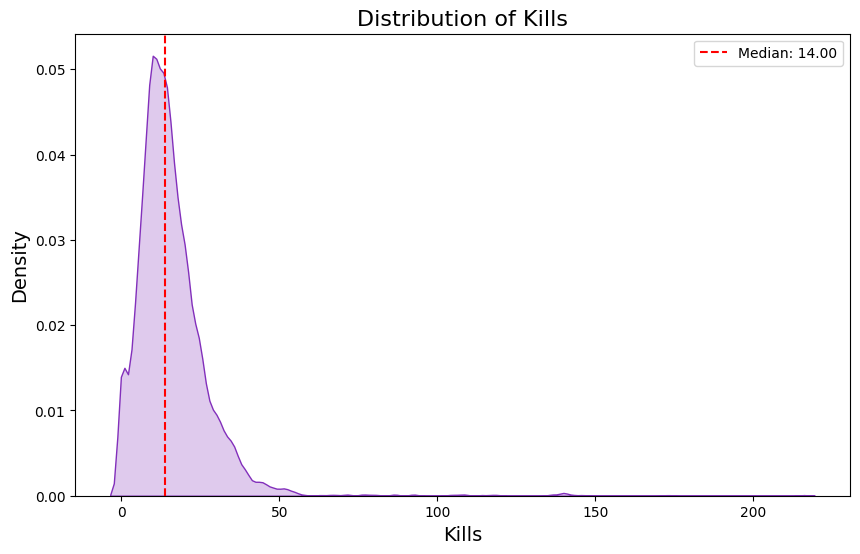

In [42]:
median_personal_score = df['Kills'].median()

plt.figure(figsize=(10, 6))
sns.kdeplot(df['Kills'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_personal_score, color='red', linestyle='--', label=f'Median: {median_personal_score:.2f}')

plt.title('Distribution of Kills', fontsize=16)
plt.xlabel('Kills', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.show()

### Excluding Firefight

In [43]:
df = pd.read_sql_query('''SELECT
    MatchId,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Kills') AS Kills
FROM MatchStats, json_each(Players) AS player
WHERE 
	datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
	AND json_extract(MatchInfo, '$.LifecycleMode') = 3
	AND json_extract(MatchInfo, '$.UgcGameVariant.AssetId') NOT IN ('1d641733-7cb2-4556-9ec3-f27923af32a1', '15480417-fa8e-49a9-9d4b-e2ae90815562', 'ff451042-bcf2-4173-bd87-0ba8c463c3e0', 'bc7f495b-c516-414e-acff-9718babe97a5', '2c438c28-ac97-4c72-92e4-75f9ab2f612e', 'bff8b7d6-f9f3-44b8-b3c3-59669e154e10', '3ec67f6c-4113-46d3-b94e-b70986625a15', '219f8162-ef34-419e-939b-c3b9dafe3109', 'a598de90-4b3f-420a-83d4-c84ba89bf94c')
	AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
''', conn)

df.head(10)

MatchId  Kills
0  9c83a3ae-feab-4498-8a5d-f7b09833982d      9
1  ccaacac1-84bb-4c6c-9ba1-589655c26e83     10
2  d9201be8-8e7f-4091-b85d-89ab8edc55bf     29
3  dc1fa349-3344-4a97-bd1a-fbad0f5cc77c     12
4  d0a66ca6-1a39-41ec-afe6-6d98e9bfbcd5     18
5  2bee1c75-17af-4624-a9b5-76bbe846b7bb     23
6  75190e3a-a2f0-41b1-9ffc-9a7fc9efe5d9     30
7  f1373ec5-19fc-4b04-ba7a-7bf8b7f0a11b     18
8  3f85e2c9-23de-4f3b-b2cb-4584d6da3598      8
9  49bffea6-aa6f-4880-9c33-1b415f0cf28a     37

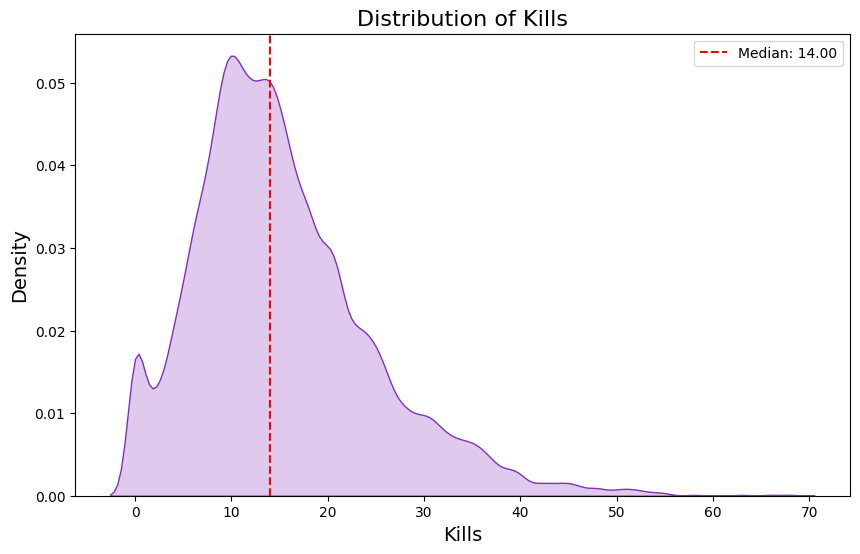

In [44]:
median_personal_score = df['Kills'].median()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['Kills'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_personal_score, color='red', linestyle='--', label=f'Median: {median_personal_score:.2f}')

plt.title('Distribution of Kills', fontsize=16)
plt.xlabel('Kills', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.show()

## Median deaths

In [45]:
df = pd.read_sql_query('''SELECT
    MatchId,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Deaths') AS Deaths
FROM MatchStats, json_each(Players) AS player
WHERE 
	datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
	AND json_extract(MatchInfo, '$.LifecycleMode') = 3
	AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
''', conn)

df.head(10)

MatchId  Deaths
0  9c83a3ae-feab-4498-8a5d-f7b09833982d      16
1  ccaacac1-84bb-4c6c-9ba1-589655c26e83      12
2  d9201be8-8e7f-4091-b85d-89ab8edc55bf      23
3  dc1fa349-3344-4a97-bd1a-fbad0f5cc77c      16
4  d0a66ca6-1a39-41ec-afe6-6d98e9bfbcd5      16
5  2bee1c75-17af-4624-a9b5-76bbe846b7bb      19
6  75190e3a-a2f0-41b1-9ffc-9a7fc9efe5d9      26
7  f1373ec5-19fc-4b04-ba7a-7bf8b7f0a11b      11
8  3f85e2c9-23de-4f3b-b2cb-4584d6da3598      20
9  49bffea6-aa6f-4880-9c33-1b415f0cf28a      20

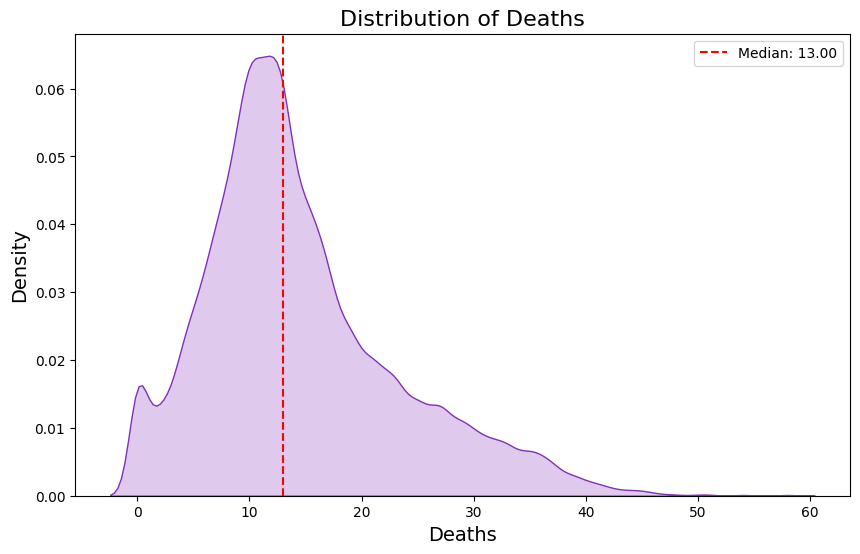

In [46]:
median_personal_score = df['Deaths'].median()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['Deaths'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_personal_score, color='red', linestyle='--', label=f'Median: {median_personal_score:.2f}')

plt.title('Distribution of Deaths', fontsize=16)
plt.xlabel('Deaths', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.show()

## Median assists

In [47]:
df = pd.read_sql_query('''SELECT
    MatchId,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Assists') AS Assists
FROM MatchStats, json_each(Players) AS player
WHERE 
	datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
	AND json_extract(MatchInfo, '$.LifecycleMode') = 3
	AND json_extract(MatchInfo, '$.UgcGameVariant.AssetId') NOT IN ('1d641733-7cb2-4556-9ec3-f27923af32a1', '15480417-fa8e-49a9-9d4b-e2ae90815562', 'ff451042-bcf2-4173-bd87-0ba8c463c3e0', 'bc7f495b-c516-414e-acff-9718babe97a5', '2c438c28-ac97-4c72-92e4-75f9ab2f612e', 'bff8b7d6-f9f3-44b8-b3c3-59669e154e10', '3ec67f6c-4113-46d3-b94e-b70986625a15', '219f8162-ef34-419e-939b-c3b9dafe3109', 'a598de90-4b3f-420a-83d4-c84ba89bf94c')
	AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
''', conn)

df.head(10)

MatchId  Assists
0  9c83a3ae-feab-4498-8a5d-f7b09833982d        2
1  ccaacac1-84bb-4c6c-9ba1-589655c26e83        3
2  d9201be8-8e7f-4091-b85d-89ab8edc55bf       13
3  dc1fa349-3344-4a97-bd1a-fbad0f5cc77c        9
4  d0a66ca6-1a39-41ec-afe6-6d98e9bfbcd5        4
5  2bee1c75-17af-4624-a9b5-76bbe846b7bb        9
6  75190e3a-a2f0-41b1-9ffc-9a7fc9efe5d9       12
7  f1373ec5-19fc-4b04-ba7a-7bf8b7f0a11b        3
8  3f85e2c9-23de-4f3b-b2cb-4584d6da3598        5
9  49bffea6-aa6f-4880-9c33-1b415f0cf28a       10

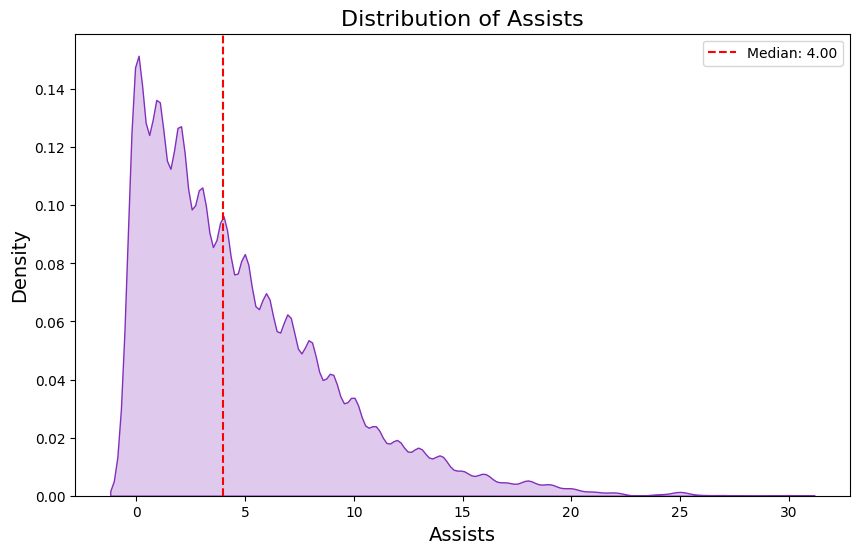

In [48]:
median_personal_score = df['Assists'].median()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['Assists'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_personal_score, color='red', linestyle='--', label=f'Median: {median_personal_score:.2f}')

plt.title('Distribution of Assists', fontsize=16)
plt.xlabel('Assists', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.show()

## Median life duration

In [49]:
df = pd.read_sql_query('''SELECT
    MatchId,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration') AS AverageLifeDuration
FROM MatchStats, json_each(Players) AS player
WHERE 
	datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
	AND json_extract(MatchInfo, '$.LifecycleMode') = 3
	AND json_extract(MatchInfo, '$.UgcGameVariant.AssetId') NOT IN ('1d641733-7cb2-4556-9ec3-f27923af32a1', '15480417-fa8e-49a9-9d4b-e2ae90815562', 'ff451042-bcf2-4173-bd87-0ba8c463c3e0', 'bc7f495b-c516-414e-acff-9718babe97a5', '2c438c28-ac97-4c72-92e4-75f9ab2f612e', 'bff8b7d6-f9f3-44b8-b3c3-59669e154e10', '3ec67f6c-4113-46d3-b94e-b70986625a15', '219f8162-ef34-419e-939b-c3b9dafe3109', 'a598de90-4b3f-420a-83d4-c84ba89bf94c')
	AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
''', conn)

df.head(10)

MatchId AverageLifeDuration
0  9c83a3ae-feab-4498-8a5d-f7b09833982d              PT8.5S
1  ccaacac1-84bb-4c6c-9ba1-589655c26e83              PT9.7S
2  d9201be8-8e7f-4091-b85d-89ab8edc55bf             PT17.1S
3  dc1fa349-3344-4a97-bd1a-fbad0f5cc77c             PT17.1S
4  d0a66ca6-1a39-41ec-afe6-6d98e9bfbcd5             PT12.5S
5  2bee1c75-17af-4624-a9b5-76bbe846b7bb               PT22S
6  75190e3a-a2f0-41b1-9ffc-9a7fc9efe5d9             PT16.4S
7  f1373ec5-19fc-4b04-ba7a-7bf8b7f0a11b               PT22S
8  3f85e2c9-23de-4f3b-b2cb-4584d6da3598             PT12.7S
9  49bffea6-aa6f-4880-9c33-1b415f0cf28a             PT18.4S

In [50]:
def duration_to_seconds(duration_str):
    match = re.match(r'PT(?:(\d+)H)?(?:(\d+)M)?(?:(\d+\.?\d*)S)?', duration_str)
    
    hours = float(match.group(1)) if match.group(1) else 0
    minutes = float(match.group(2)) if match.group(2) else 0
    seconds = float(match.group(3)) if match.group(3) else 0
    
    total_seconds = hours * 3600 + minutes * 60 + seconds
    return total_seconds

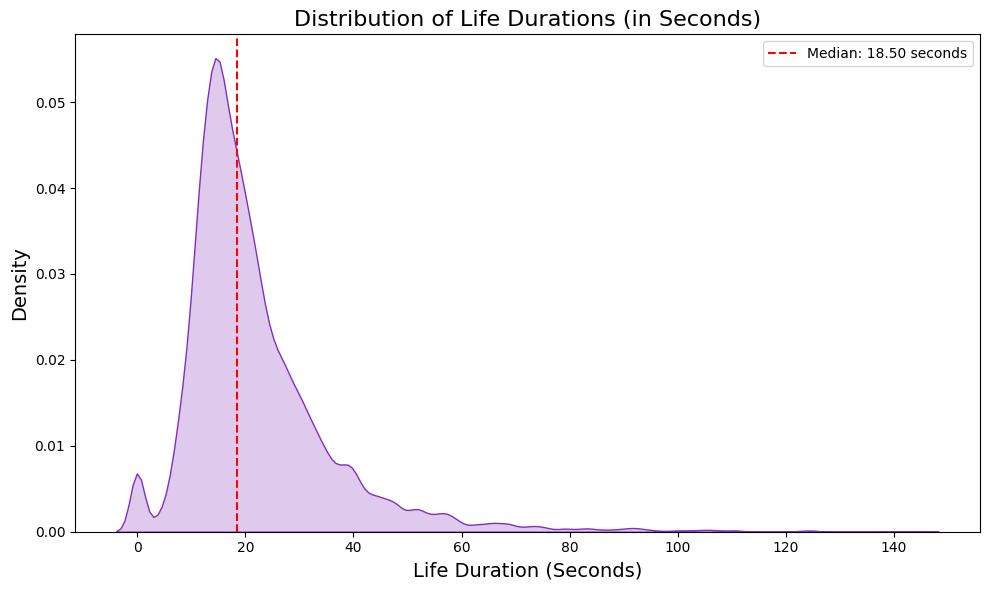

In [51]:
df['AverageLifeDurationSeconds'] = df['AverageLifeDuration'].apply(duration_to_seconds)

median_life_duration = df['AverageLifeDurationSeconds'].median()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['AverageLifeDurationSeconds'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_life_duration, color='red', linestyle='--', label=f'Median: {median_life_duration:.2f} seconds')

plt.title('Distribution of Life Durations (in Seconds)', fontsize=16)
plt.xlabel('Life Duration (Seconds)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

## Median accuracy

In [52]:
df = pd.read_sql_query('''SELECT
    MatchId,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Accuracy') AS Accuracy
FROM MatchStats, json_each(Players) AS player
WHERE 
	datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
	AND json_extract(MatchInfo, '$.LifecycleMode') = 3
	AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
''', conn)

df.head(10)

MatchId  Accuracy
0  9c83a3ae-feab-4498-8a5d-f7b09833982d     30.32
1  ccaacac1-84bb-4c6c-9ba1-589655c26e83     40.20
2  d9201be8-8e7f-4091-b85d-89ab8edc55bf     53.47
3  dc1fa349-3344-4a97-bd1a-fbad0f5cc77c     50.64
4  d0a66ca6-1a39-41ec-afe6-6d98e9bfbcd5     34.61
5  2bee1c75-17af-4624-a9b5-76bbe846b7bb     37.05
6  75190e3a-a2f0-41b1-9ffc-9a7fc9efe5d9     40.00
7  f1373ec5-19fc-4b04-ba7a-7bf8b7f0a11b     54.05
8  3f85e2c9-23de-4f3b-b2cb-4584d6da3598     30.47
9  49bffea6-aa6f-4880-9c33-1b415f0cf28a     34.78

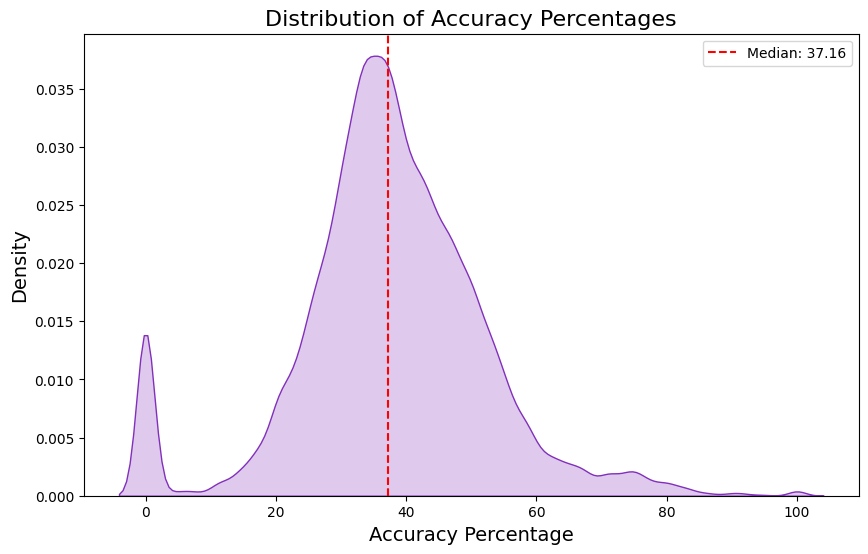

In [53]:
median_accuracy = df['Accuracy'].median()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['Accuracy'], fill=True, color='#822fbb', bw_adjust=0.5)
plt.axvline(median_accuracy, color='red', linestyle='--', label=f'Median: {median_accuracy:.2f}')
plt.title('Distribution of Accuracy Percentages', fontsize=16)
plt.xlabel('Accuracy Percentage', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.show()

## Median KDA

In [54]:
df = pd.read_sql_query('''SELECT
    MatchId,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.KDA') AS KDA
FROM MatchStats, json_each(Players) AS player
WHERE 
	datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
	AND json_extract(MatchInfo, '$.LifecycleMode') = 3
	AND json_extract(MatchInfo, '$.UgcGameVariant.AssetId') NOT IN ('1d641733-7cb2-4556-9ec3-f27923af32a1', '15480417-fa8e-49a9-9d4b-e2ae90815562', 'ff451042-bcf2-4173-bd87-0ba8c463c3e0', 'bc7f495b-c516-414e-acff-9718babe97a5', '2c438c28-ac97-4c72-92e4-75f9ab2f612e', 'bff8b7d6-f9f3-44b8-b3c3-59669e154e10', '3ec67f6c-4113-46d3-b94e-b70986625a15', '219f8162-ef34-419e-939b-c3b9dafe3109', 'a598de90-4b3f-420a-83d4-c84ba89bf94c')
	AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
''', conn)

df.head(10)

MatchId    KDA
0  9c83a3ae-feab-4498-8a5d-f7b09833982d  -6.33
1  ccaacac1-84bb-4c6c-9ba1-589655c26e83  -1.00
2  d9201be8-8e7f-4091-b85d-89ab8edc55bf  10.33
3  dc1fa349-3344-4a97-bd1a-fbad0f5cc77c  -1.00
4  d0a66ca6-1a39-41ec-afe6-6d98e9bfbcd5   3.33
5  2bee1c75-17af-4624-a9b5-76bbe846b7bb   7.00
6  75190e3a-a2f0-41b1-9ffc-9a7fc9efe5d9   8.00
7  f1373ec5-19fc-4b04-ba7a-7bf8b7f0a11b   8.00
8  3f85e2c9-23de-4f3b-b2cb-4584d6da3598 -10.33
9  49bffea6-aa6f-4880-9c33-1b415f0cf28a  20.33

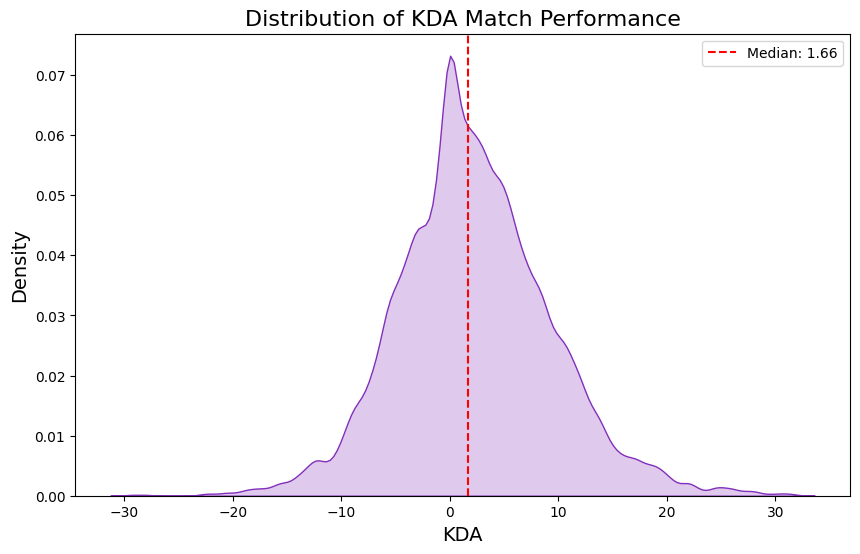

In [55]:
median_kda = df['KDA'].median()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['KDA'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_kda, color='red', linestyle='--', label=f'Median: {median_kda:.2f}')

plt.title('Distribution of KDA Match Performance', fontsize=16)
plt.xlabel('KDA', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.show()

## Median match duration

In [56]:
df = pd.read_sql_query('''SELECT
    MatchId,
	json_extract(MatchInfo, '$.Duration') AS Duration
FROM MatchStats, json_each(Players) AS player
WHERE 
	datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
	AND json_extract(MatchInfo, '$.LifecycleMode') = 3
	AND json_extract(MatchInfo, '$.UgcGameVariant.AssetId') NOT IN ('1d641733-7cb2-4556-9ec3-f27923af32a1', '15480417-fa8e-49a9-9d4b-e2ae90815562', 'ff451042-bcf2-4173-bd87-0ba8c463c3e0', 'bc7f495b-c516-414e-acff-9718babe97a5', '2c438c28-ac97-4c72-92e4-75f9ab2f612e', 'bff8b7d6-f9f3-44b8-b3c3-59669e154e10', '3ec67f6c-4113-46d3-b94e-b70986625a15', '219f8162-ef34-419e-939b-c3b9dafe3109', 'a598de90-4b3f-420a-83d4-c84ba89bf94c')
	AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
	AND json_extract(player.value, '$.Outcome') IN (1, 2, 3) 
''', conn)

df['DurationSeconds'] = df['Duration'].apply(duration_to_seconds)

df.head(10)

MatchId          Duration  DurationSeconds
0  9c83a3ae-feab-4498-8a5d-f7b09833982d   PT4M55.0169756S       295.016976
1  ccaacac1-84bb-4c6c-9ba1-589655c26e83    PT4M16.470175S       256.470175
2  d9201be8-8e7f-4091-b85d-89ab8edc55bf   PT10M30.679894S       630.679894
3  dc1fa349-3344-4a97-bd1a-fbad0f5cc77c     PT7M4.479578S       424.479578
4  d0a66ca6-1a39-41ec-afe6-6d98e9bfbcd5   PT5M53.2941253S       353.294125
5  2bee1c75-17af-4624-a9b5-76bbe846b7bb  PT10M21.4530865S       621.453087
6  75190e3a-a2f0-41b1-9ffc-9a7fc9efe5d9   PT11M0.9800707S       660.980071
7  f1373ec5-19fc-4b04-ba7a-7bf8b7f0a11b   PT6M44.1583369S       404.158337
8  3f85e2c9-23de-4f3b-b2cb-4584d6da3598     PT8M4.504352S       484.504352
9  49bffea6-aa6f-4880-9c33-1b415f0cf28a   PT9M45.8091015S       585.809101

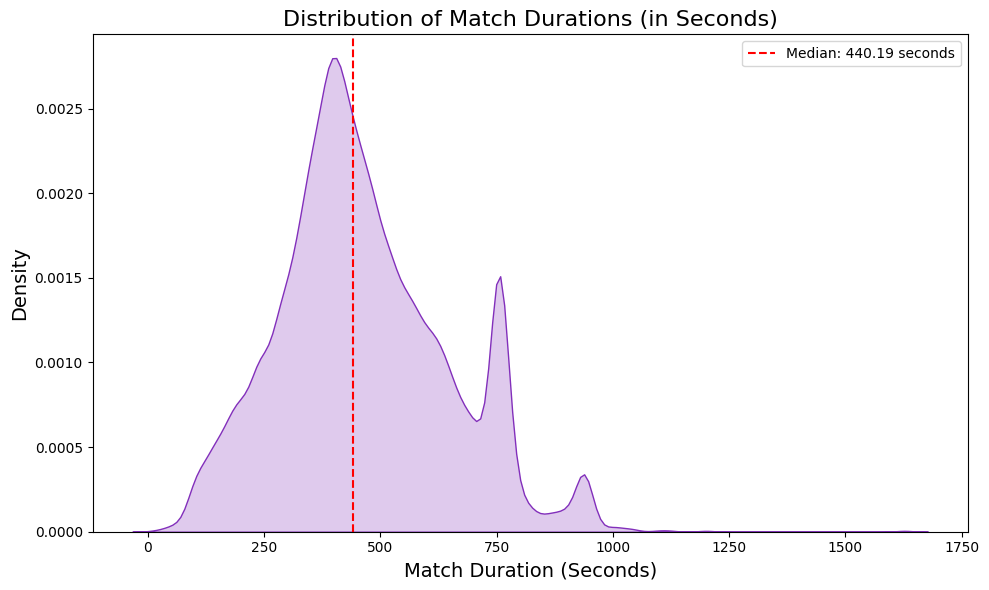

In [57]:
median_duration = df['DurationSeconds'].median()

plt.figure(figsize=(10, 6))
sns.kdeplot(df['DurationSeconds'], fill=True, color='#822fbb', bw_adjust=0.5)
plt.axvline(median_duration, color='red', linestyle='--', label=f'Median: {median_duration:.2f} seconds')
plt.title('Distribution of Match Durations (in Seconds)', fontsize=16)
plt.xlabel('Match Duration (Seconds)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

## Median damage dealt

In [58]:
df = pd.read_sql_query('''SELECT
    MatchId,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.DamageDealt') AS DamageDealt
FROM MatchStats, json_each(Players) AS player
WHERE 
	datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
	AND json_extract(MatchInfo, '$.LifecycleMode') = 3
	AND json_extract(MatchInfo, '$.UgcGameVariant.AssetId') NOT IN ('1d641733-7cb2-4556-9ec3-f27923af32a1', '15480417-fa8e-49a9-9d4b-e2ae90815562', 'ff451042-bcf2-4173-bd87-0ba8c463c3e0', 'bc7f495b-c516-414e-acff-9718babe97a5', '2c438c28-ac97-4c72-92e4-75f9ab2f612e', 'bff8b7d6-f9f3-44b8-b3c3-59669e154e10', '3ec67f6c-4113-46d3-b94e-b70986625a15', '219f8162-ef34-419e-939b-c3b9dafe3109', 'a598de90-4b3f-420a-83d4-c84ba89bf94c')
	AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
''', conn)

df.head(10)

MatchId  DamageDealt
0  9c83a3ae-feab-4498-8a5d-f7b09833982d         2166
1  ccaacac1-84bb-4c6c-9ba1-589655c26e83         2426
2  d9201be8-8e7f-4091-b85d-89ab8edc55bf         7530
3  dc1fa349-3344-4a97-bd1a-fbad0f5cc77c         4411
4  d0a66ca6-1a39-41ec-afe6-6d98e9bfbcd5         4572
5  2bee1c75-17af-4624-a9b5-76bbe846b7bb         5824
6  75190e3a-a2f0-41b1-9ffc-9a7fc9efe5d9         8699
7  f1373ec5-19fc-4b04-ba7a-7bf8b7f0a11b         4222
8  3f85e2c9-23de-4f3b-b2cb-4584d6da3598         3244
9  49bffea6-aa6f-4880-9c33-1b415f0cf28a         9875

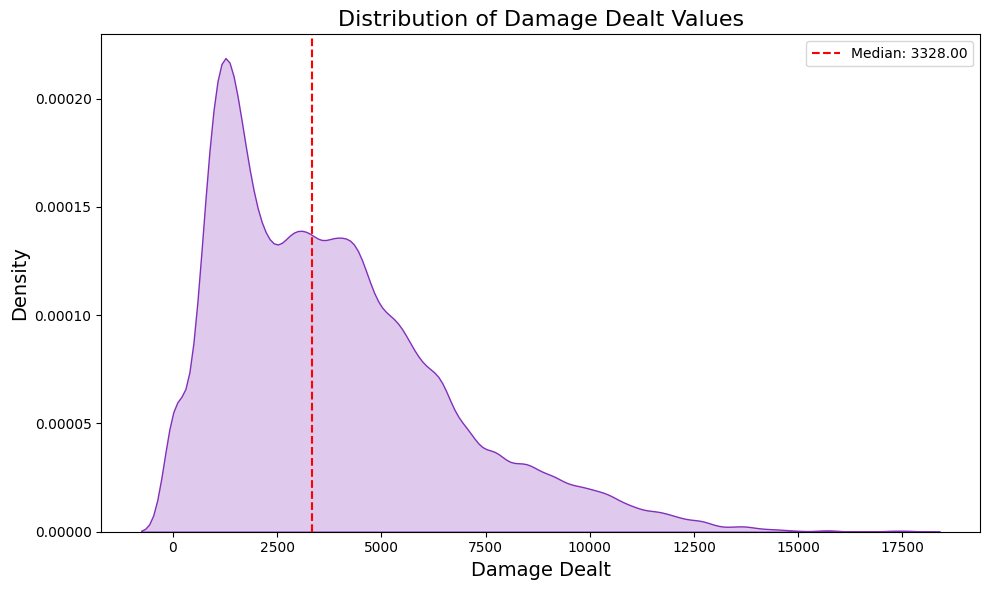

In [59]:

median_damage_dealt = df['DamageDealt'].median()

plt.figure(figsize=(10, 6))
sns.kdeplot(df['DamageDealt'], fill=True, color='#822fbb', bw_adjust=0.5)
plt.axvline(median_damage_dealt, color='red', linestyle='--', label=f'Median: {median_damage_dealt:.2f}')
plt.title('Distribution of Damage Dealt Values', fontsize=16)
plt.xlabel('Damage Dealt', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

## Median damage taken

In [60]:
df = pd.read_sql_query('''SELECT
    MatchId,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.DamageTaken') AS DamageTaken
FROM MatchStats, json_each(Players) AS player
WHERE 
	datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
	AND json_extract(MatchInfo, '$.LifecycleMode') = 3
	AND json_extract(MatchInfo, '$.UgcGameVariant.AssetId') NOT IN ('1d641733-7cb2-4556-9ec3-f27923af32a1', '15480417-fa8e-49a9-9d4b-e2ae90815562', 'ff451042-bcf2-4173-bd87-0ba8c463c3e0', 'bc7f495b-c516-414e-acff-9718babe97a5', '2c438c28-ac97-4c72-92e4-75f9ab2f612e', 'bff8b7d6-f9f3-44b8-b3c3-59669e154e10', '3ec67f6c-4113-46d3-b94e-b70986625a15', '219f8162-ef34-419e-939b-c3b9dafe3109', 'a598de90-4b3f-420a-83d4-c84ba89bf94c')
	AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
''', conn)

df.head(10)

MatchId  DamageTaken
0  9c83a3ae-feab-4498-8a5d-f7b09833982d         3659
1  ccaacac1-84bb-4c6c-9ba1-589655c26e83         2777
2  d9201be8-8e7f-4091-b85d-89ab8edc55bf         6000
3  dc1fa349-3344-4a97-bd1a-fbad0f5cc77c         4155
4  d0a66ca6-1a39-41ec-afe6-6d98e9bfbcd5         3816
5  2bee1c75-17af-4624-a9b5-76bbe846b7bb         5555
6  75190e3a-a2f0-41b1-9ffc-9a7fc9efe5d9         6916
7  f1373ec5-19fc-4b04-ba7a-7bf8b7f0a11b         3413
8  3f85e2c9-23de-4f3b-b2cb-4584d6da3598         4663
9  49bffea6-aa6f-4880-9c33-1b415f0cf28a         5875

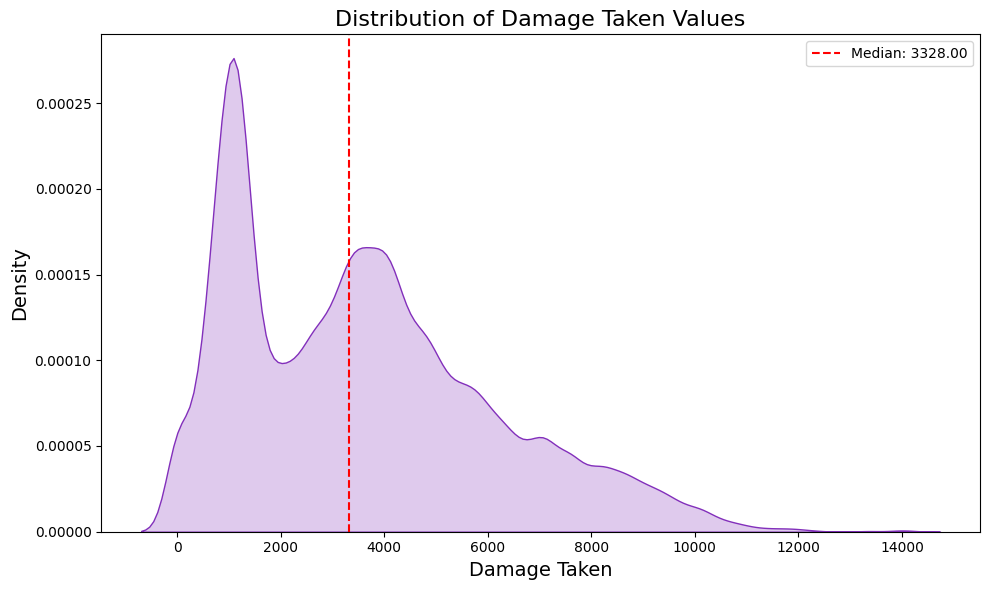

In [61]:
median_damage_taken = df['DamageTaken'].median()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['DamageTaken'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_damage_dealt, color='red', linestyle='--', label=f'Median: {median_damage_dealt:.2f}')

plt.title('Distribution of Damage Taken Values', fontsize=16)
plt.xlabel('Damage Taken', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

## Median time to first kill

In [62]:
def milliseconds_to_seconds(ms_str):
    total_seconds = ms_str / 1000
    return total_seconds

In [63]:
df = pd.read_sql_query('''SELECT MatchID, MIN(EventTime) AS MinEventTime
FROM EventLog
WHERE XUID = '2533274855333605'
  AND EventType = 50
GROUP BY MatchID;
''', event_conn)

df['TimeToEventSeconds'] = df['MinEventTime'].apply(milliseconds_to_seconds)

df.head(10)

MatchID  MinEventTime  TimeToEventSeconds
0  001085B6-163A-41A4-AF83-C63BF7A4A59C         69746              69.746
1  0026E8C0-7D32-4E33-8A87-B2C031047E44         71229              71.229
2  00275CB5-A76D-4788-B0CA-43845D693EBA        156995             156.995
3  002F007A-D0F9-498F-BBBA-B2D740DDC40F         34568              34.568
4  00359920-24F5-431A-AA4F-A6A1FAD1E71F         43376              43.376
5  00386052-DC9E-43AD-A11F-66C602EF4821         60858              60.858
6  003FAB59-B1FA-4D42-8288-949950E600DD         32650              32.650
7  00704A1F-3214-4867-995D-7E317E5B96AB         39487              39.487
8  0074FE21-9F16-4317-8379-3F4CCC5DFB05         63373              63.373
9  00894B56-7DE3-4305-B4EE-80247F0F9D28        113469             113.469

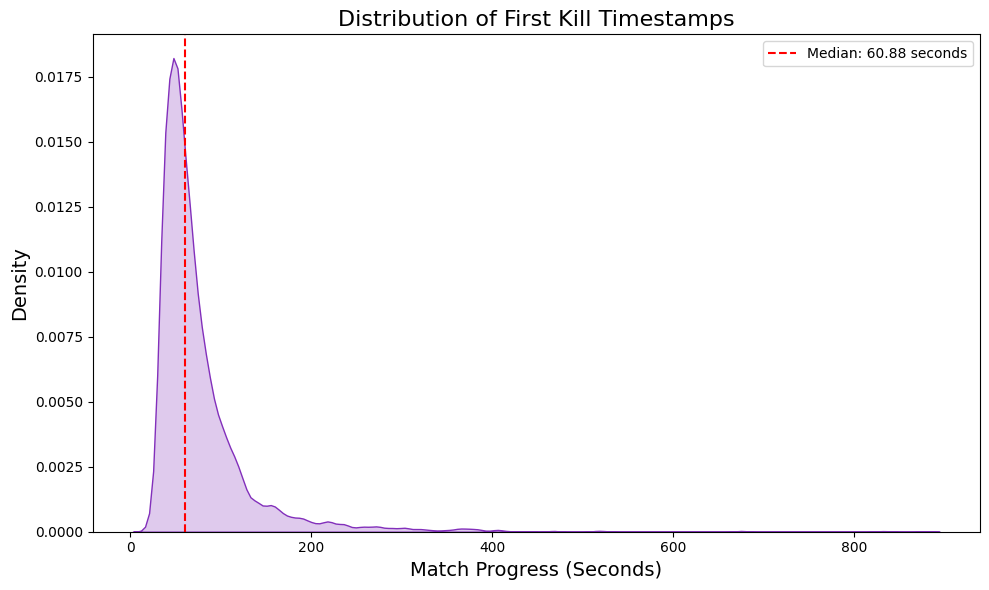

In [64]:
median_tte = df['TimeToEventSeconds'].median()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['TimeToEventSeconds'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_tte, color='red', linestyle='--', label=f'Median: {median_tte:.2f} seconds')


plt.title('Distribution of First Kill Timestamps', fontsize=16)
plt.xlabel('Match Progress (Seconds)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()


plt.tight_layout()
plt.show()

## Limiting to matches I did not join in progress

In [65]:
conn.execute(f"ATTACH DATABASE 'eventlog.db' AS EventLog;")

In [66]:
df = pd.read_sql_query('''WITH EventLogData AS (
    SELECT LOWER(MatchID) MatchID, MIN(EventTime) AS MinEventTime
    FROM EventLog
    WHERE XUID = '2533274855333605'
      AND EventType = 50
    GROUP BY MatchID
)

SELECT
    ms.MatchId,
    el.MinEventTime
FROM MatchStats AS ms
JOIN EventLogData AS el ON ms.MatchId = el.MatchID
JOIN json_each(ms.Players) AS player ON json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
WHERE 
    datetime(json_extract(ms.MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(ms.MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(ms.MatchInfo, '$.UgcGameVariant.AssetId') NOT IN (
        '1d641733-7cb2-4556-9ec3-f27923af32a1', 
        '15480417-fa8e-49a9-9d4b-e2ae90815562', 
        'ff451042-bcf2-4173-bd87-0ba8c463c3e0', 
        'bc7f495b-c516-414e-acff-9718babe97a5', 
        '2c438c28-ac97-4c72-92e4-75f9ab2f612e', 
        'bff8b7d6-f9f3-44b8-b3c3-59669e154e10', 
        '3ec67f6c-4113-46d3-b94e-b70986625a15', 
        '219f8162-ef34-419e-939b-c3b9dafe3109', 
        'a598de90-4b3f-420a-83d4-c84ba89bf94c'
    )
    AND json_extract(player.value, '$.ParticipationInfo.JoinedInProgress') = false;
''', conn)

df['TimeToEventSeconds'] = df['MinEventTime'].apply(milliseconds_to_seconds)

df.head(10)

MatchId  MinEventTime  TimeToEventSeconds
0  001085b6-163a-41a4-af83-c63bf7a4a59c         69746              69.746
1  0026e8c0-7d32-4e33-8a87-b2c031047e44         71229              71.229
2  00275cb5-a76d-4788-b0ca-43845d693eba        156995             156.995
3  002f007a-d0f9-498f-bbba-b2d740ddc40f         34568              34.568
4  00359920-24f5-431a-aa4f-a6a1fad1e71f         43376              43.376
5  00386052-dc9e-43ad-a11f-66c602ef4821         60858              60.858
6  003fab59-b1fa-4d42-8288-949950e600dd         32650              32.650
7  00704a1f-3214-4867-995d-7e317e5b96ab         39487              39.487
8  0074fe21-9f16-4317-8379-3f4ccc5dfb05         63373              63.373
9  008ac343-f36e-46a1-9a0e-c22f29c552f4         77564              77.564

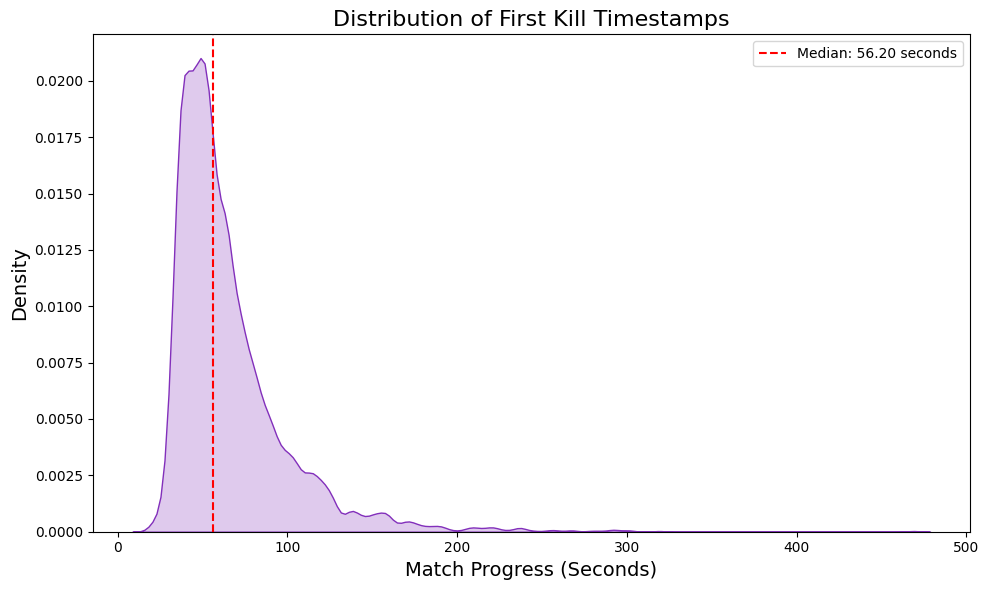

In [67]:

median_tte = df['TimeToEventSeconds'].median()
plt.figure(figsize=(10, 6))
sns.kdeplot(df['TimeToEventSeconds'], fill=True, color='#822fbb', bw_adjust=0.5)
plt.axvline(median_tte, color='red', linestyle='--', label=f'Median: {median_tte:.2f} seconds')
plt.title('Distribution of First Kill Timestamps', fontsize=16)
plt.xlabel('Match Progress (Seconds)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

## Median time to first death

In [68]:
df = pd.read_sql_query('''WITH EventLogData AS (
    SELECT LOWER(MatchID) MatchID, MIN(EventTime) AS MinEventTime
    FROM EventLog
    WHERE XUID = '2533274855333605'
      AND EventType = 20
    GROUP BY MatchID
)

SELECT
    ms.MatchId,
    el.MinEventTime
FROM MatchStats AS ms
JOIN EventLogData AS el ON ms.MatchId = el.MatchID
JOIN json_each(ms.Players) AS player ON json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
WHERE 
    datetime(json_extract(ms.MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(ms.MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(ms.MatchInfo, '$.UgcGameVariant.AssetId') NOT IN (
        '1d641733-7cb2-4556-9ec3-f27923af32a1', 
        '15480417-fa8e-49a9-9d4b-e2ae90815562', 
        'ff451042-bcf2-4173-bd87-0ba8c463c3e0', 
        'bc7f495b-c516-414e-acff-9718babe97a5', 
        '2c438c28-ac97-4c72-92e4-75f9ab2f612e', 
        'bff8b7d6-f9f3-44b8-b3c3-59669e154e10', 
        '3ec67f6c-4113-46d3-b94e-b70986625a15', 
        '219f8162-ef34-419e-939b-c3b9dafe3109', 
        'a598de90-4b3f-420a-83d4-c84ba89bf94c'
    )
    AND json_extract(player.value, '$.ParticipationInfo.JoinedInProgress') = false;
''', conn)

df['TimeToEventSeconds'] = df['MinEventTime'].apply(milliseconds_to_seconds)

df.head(10)

MatchId  MinEventTime  TimeToEventSeconds
0  001085b6-163a-41a4-af83-c63bf7a4a59c         57980              57.980
1  0026e8c0-7d32-4e33-8a87-b2c031047e44         60103              60.103
2  00275cb5-a76d-4788-b0ca-43845d693eba         46835              46.835
3  002f007a-d0f9-498f-bbba-b2d740ddc40f         63998              63.998
4  00359920-24f5-431a-aa4f-a6a1fad1e71f         48897              48.897
5  00386052-dc9e-43ad-a11f-66c602ef4821         43490              43.490
6  003fab59-b1fa-4d42-8288-949950e600dd         45866              45.866
7  00704a1f-3214-4867-995d-7e317e5b96ab         83108              83.108
8  0074fe21-9f16-4317-8379-3f4ccc5dfb05         52229              52.229
9  008ac343-f36e-46a1-9a0e-c22f29c552f4         48735              48.735

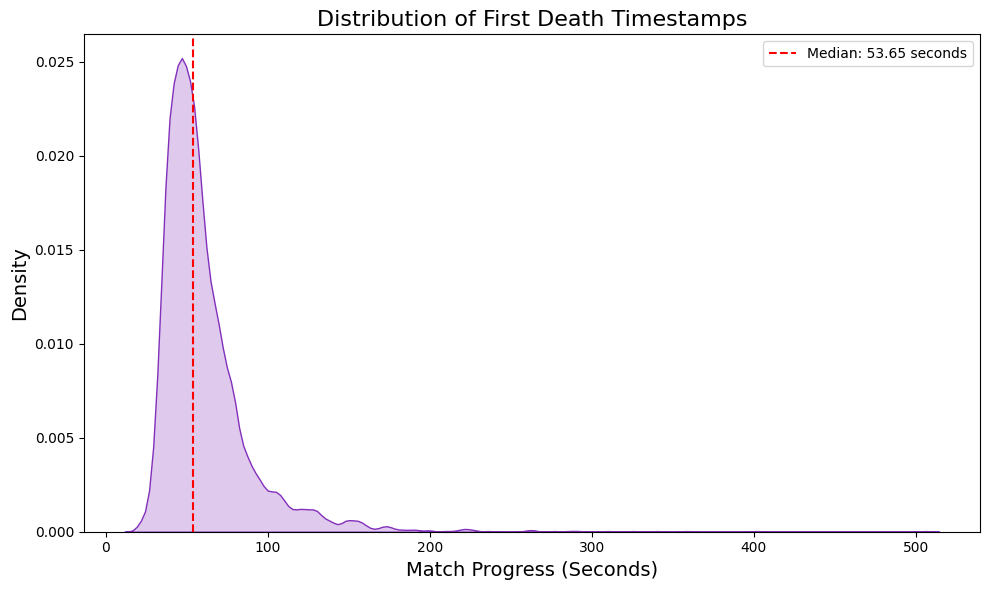

In [69]:

median_tte = df['TimeToEventSeconds'].median()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['TimeToEventSeconds'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_tte, color='red', linestyle='--', label=f'Median: {median_tte:.2f} seconds')

plt.title('Distribution of First Death Timestamps', fontsize=16)
plt.xlabel('Match Progress (Seconds)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

## Median time to first medal

In [70]:
df = pd.read_sql_query('''WITH EventLogData AS (
    SELECT LOWER(MatchID) MatchID, MIN(EventTime) AS MinEventTime
    FROM EventLog
    WHERE XUID = '2533274855333605'
      AND MedalFlag = 1
    GROUP BY MatchID
)

SELECT
    ms.MatchId,
    el.MinEventTime
FROM MatchStats AS ms
JOIN EventLogData AS el ON ms.MatchId = el.MatchID
JOIN json_each(ms.Players) AS player ON json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
WHERE 
    datetime(json_extract(ms.MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(ms.MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(ms.MatchInfo, '$.UgcGameVariant.AssetId') NOT IN (
        '1d641733-7cb2-4556-9ec3-f27923af32a1', 
        '15480417-fa8e-49a9-9d4b-e2ae90815562', 
        'ff451042-bcf2-4173-bd87-0ba8c463c3e0', 
        'bc7f495b-c516-414e-acff-9718babe97a5', 
        '2c438c28-ac97-4c72-92e4-75f9ab2f612e', 
        'bff8b7d6-f9f3-44b8-b3c3-59669e154e10', 
        '3ec67f6c-4113-46d3-b94e-b70986625a15', 
        '219f8162-ef34-419e-939b-c3b9dafe3109', 
        'a598de90-4b3f-420a-83d4-c84ba89bf94c'
    )
    AND json_extract(player.value, '$.ParticipationInfo.JoinedInProgress') = false;
''', conn)

df['TimeToEventSeconds'] = df['MinEventTime'].apply(milliseconds_to_seconds)

df.head(10)

MatchId  MinEventTime  TimeToEventSeconds
0  001085b6-163a-41a4-af83-c63bf7a4a59c         69746              69.746
1  0026e8c0-7d32-4e33-8a87-b2c031047e44        163172             163.172
2  00275cb5-a76d-4788-b0ca-43845d693eba        195669             195.669
3  002f007a-d0f9-498f-bbba-b2d740ddc40f         76811              76.811
4  00359920-24f5-431a-aa4f-a6a1fad1e71f         43376              43.376
5  00386052-dc9e-43ad-a11f-66c602ef4821         61927              61.927
6  003fab59-b1fa-4d42-8288-949950e600dd         32650              32.650
7  00704a1f-3214-4867-995d-7e317e5b96ab         39489              39.489
8  0074fe21-9f16-4317-8379-3f4ccc5dfb05         63373              63.373
9  008ac343-f36e-46a1-9a0e-c22f29c552f4         92846              92.846

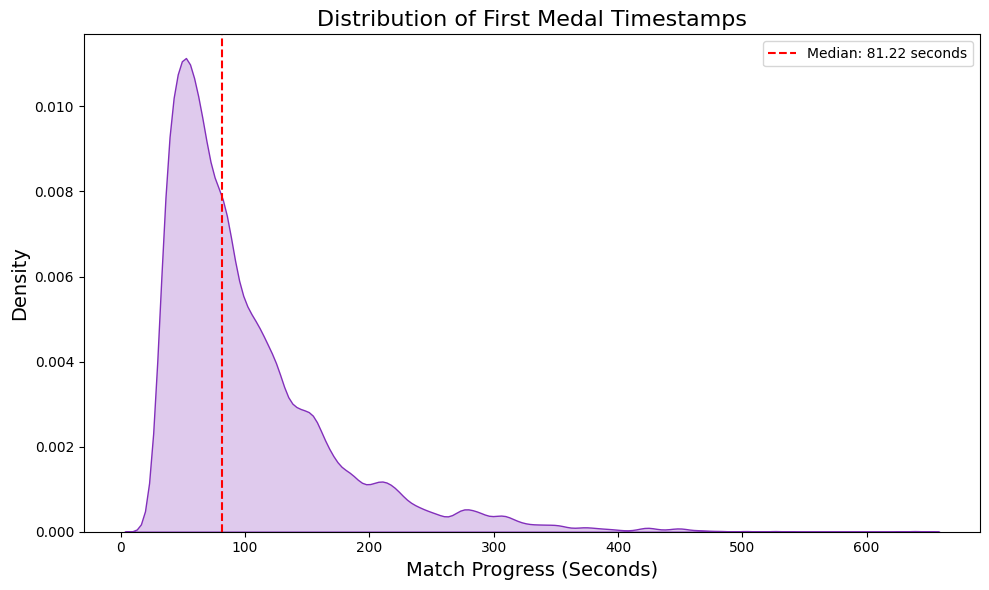

In [71]:
median_tte = df['TimeToEventSeconds'].median()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['TimeToEventSeconds'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_tte, color='red', linestyle='--', label=f'Median: {median_tte:.2f} seconds')

plt.title('Distribution of First Medal Timestamps', fontsize=16)
plt.xlabel('Match Progress (Seconds)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

## Experience per minute

In [75]:
df = pd.read_sql_query('''WITH PlayerStats AS (
    SELECT
		datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') AS StartTime,
        MatchId,
        json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.PersonalScore') AS PersonalScore,
        CAST(
            SUBSTR(json_extract(player.value, '$.ParticipationInfo.TimePlayed'), 3, INSTR(json_extract(player.value, '$.ParticipationInfo.TimePlayed'), 'M') - 3) AS INTEGER
        ) * 60 +
        CAST(
            SUBSTR(
                json_extract(player.value, '$.ParticipationInfo.TimePlayed'),
                INSTR(json_extract(player.value, '$.ParticipationInfo.TimePlayed'), 'M') + 1,
                LENGTH(json_extract(player.value, '$.ParticipationInfo.TimePlayed')) - INSTR(json_extract(player.value, '$.ParticipationInfo.TimePlayed'), 'M') - 1
            ) AS REAL
        ) AS TimePlayedInSeconds
    FROM MatchStats, json_each(Players) AS player
    WHERE 
        datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
        AND json_extract(MatchInfo, '$.LifecycleMode') = 3
        AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
)
SELECT
	StartTime,
    MatchId,
    PersonalScore,
    TimePlayedInSeconds,
    IFNULL((PersonalScore / TimePlayedInSeconds) * 60, 0) AS PersonalScorePerMinute
FROM PlayerStats
ORDER BY StartTime ASC
''', conn)

df.head(10)

StartTime                               MatchId  PersonalScore  \
0  2023-06-20 11:50:46  f16a7423-f9f4-470f-895e-9469e8132dac           1255   
1  2023-06-20 12:02:21  9e93bf25-c9a7-45e8-ad50-e9b2f6da6b12           1350   
2  2023-06-20 12:14:13  b6310997-144a-4e88-949e-516b2dd8c5df           1850   
3  2023-06-20 12:26:10  8f5d828a-d447-4995-9ec0-74d776c987b8           1130   
4  2023-06-20 13:08:06  34cab12e-8a19-4e78-84e1-fdfca8e182c2            690   
5  2023-06-20 13:17:28  836e7403-4655-4552-8e70-f3352bef0890           1170   
6  2023-06-20 13:32:37  22e65b58-6567-4593-a890-dc4b8a6d3699           1680   
7  2023-06-20 13:49:06  ec0a8ee1-ccbf-4c8b-a6ec-c51078052fbe            950   
8  2023-06-20 14:00:29  7963a124-e5b1-49fa-9763-8a779717c5c5            770   
9  2023-06-20 14:16:34  bcafb0ca-f6fa-40f4-89e6-d3dd63b87f11           2060   

   TimePlayedInSeconds  PersonalScorePerMinute  
0              573.484              131.302704  
1              623.844              129.840152  
2              617.610              179.725069  
3              452.563              149.813396  
4              455.797               90.829909  
5              728.812               96.321136  
6              676.719              148.953997  
7              563.078              101.229315  
8              447.453              103.251068  
9              630.656              195.986401

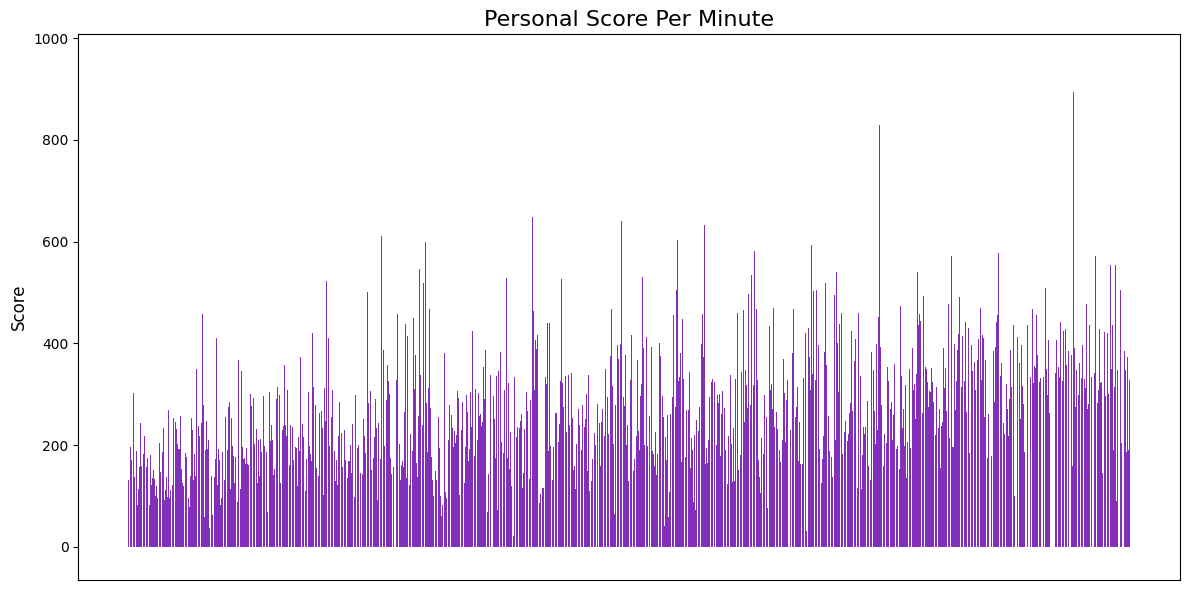

In [77]:
plt.figure(figsize=(12, 6))

plt.bar(df['StartTime'], df['PersonalScorePerMinute'], color='#822fbb')

plt.title('Personal Score Per Minute', fontsize=16)
plt.ylabel('Score', fontsize=12)

plt.gca().xaxis.set_visible(False)

plt.tight_layout()

plt.show()

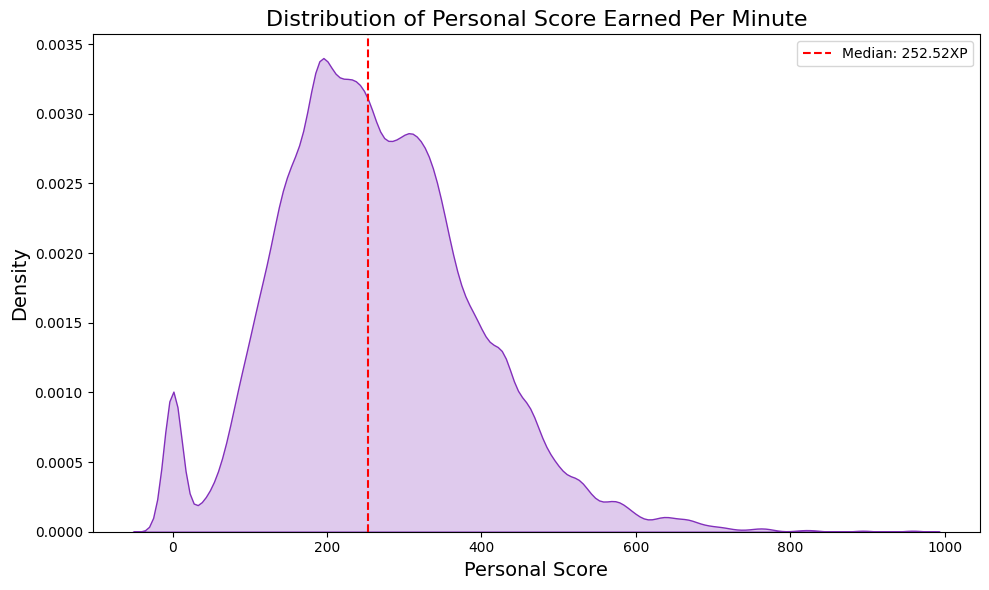

In [79]:
median_pspm = df['PersonalScorePerMinute'].median()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['PersonalScorePerMinute'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_pspm, color='red', linestyle='--', label=f'Median: {median_pspm:.2f}XP')

plt.title('Distribution of Personal Score Earned Per Minute', fontsize=16)
plt.xlabel('Personal Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

## Correlation of kills, average life duration, and outcomes

In [133]:
df = pd.read_sql_query('''SELECT
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') AS StartTime,
    MatchId,
    json_extract(player.value, '$.Outcome') AS Outcome,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration') AS ISOAverageLifeDuration,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Kills') AS Kills,
    CASE
        WHEN INSTR(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration'), 'M') > 0 THEN
            CAST(
                SUBSTR(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration'), 3, INSTR(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration'), 'M') - 3) AS INTEGER
            ) * 60 +
            CAST(
                SUBSTR(
                    json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration'),
                    INSTR(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration'), 'M') + 1,
                    LENGTH(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration')) - INSTR(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration'), 'M') - 1
                ) AS REAL
            )
        ELSE
            CAST(
                SUBSTR(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration'), 3, LENGTH(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration')) - 3) AS REAL
            )
    END AS AverageLifeDuration
FROM MatchStats, json_each(Players) AS player
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
	AND json_extract(MatchInfo, '$.UgcGameVariant.AssetId') NOT IN ('1d641733-7cb2-4556-9ec3-f27923af32a1', '15480417-fa8e-49a9-9d4b-e2ae90815562', 'ff451042-bcf2-4173-bd87-0ba8c463c3e0', 'bc7f495b-c516-414e-acff-9718babe97a5', '2c438c28-ac97-4c72-92e4-75f9ab2f612e', 'bff8b7d6-f9f3-44b8-b3c3-59669e154e10', '3ec67f6c-4113-46d3-b94e-b70986625a15', '219f8162-ef34-419e-939b-c3b9dafe3109', 'a598de90-4b3f-420a-83d4-c84ba89bf94c')
ORDER BY StartTime ASC;
''', conn)

df.head(10)

StartTime                               MatchId  Outcome  \
0  2023-06-20 11:50:46  f16a7423-f9f4-470f-895e-9469e8132dac        3   
1  2023-06-20 12:02:21  9e93bf25-c9a7-45e8-ad50-e9b2f6da6b12        2   
2  2023-06-20 12:14:13  b6310997-144a-4e88-949e-516b2dd8c5df        2   
3  2023-06-20 12:26:10  8f5d828a-d447-4995-9ec0-74d776c987b8        2   
4  2023-06-20 13:08:06  34cab12e-8a19-4e78-84e1-fdfca8e182c2        3   
5  2023-06-20 13:17:28  836e7403-4655-4552-8e70-f3352bef0890        2   
6  2023-06-20 13:32:37  22e65b58-6567-4593-a890-dc4b8a6d3699        3   
7  2023-06-20 13:49:06  ec0a8ee1-ccbf-4c8b-a6ec-c51078052fbe        3   
8  2023-06-20 14:00:29  7963a124-e5b1-49fa-9763-8a779717c5c5        3   
9  2023-06-20 14:16:34  bcafb0ca-f6fa-40f4-89e6-d3dd63b87f11        2   

  ISOAverageLifeDuration  Kills  AverageLifeDuration  
0                PT36.9S     10                 36.9  
1                PT51.6S      9                 51.6  
2                PT37.4S     14                 37.4  
3                PT29.7S     10                 29.7  
4                PT19.2S      5                 19.2  
5                PT51.1S      9                 51.1  
6                PT37.5S     13                 37.5  
7                PT25.4S      9                 25.4  
8                PT16.7S      7                 16.7  
9                PT51.6S     16                 51.6

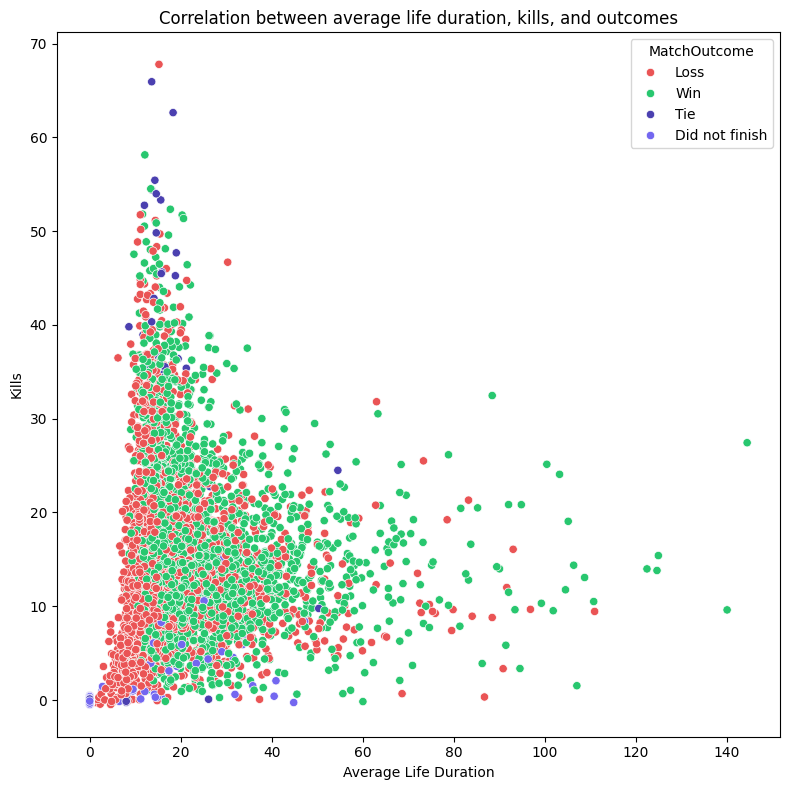

In [134]:
df['Outcome'] = pd.to_numeric(df['Outcome'], errors='coerce')
df['Kills'] = pd.to_numeric(df['Kills'], errors='coerce')

outcome_info = {
    1: {'label': 'Tie', 'color': '#4B40B0'},
    2: {'label': 'Win', 'color': '#28C76F'},
    3: {'label': 'Loss', 'color': '#EA5455'},
    4: {'label': 'Did not finish', 'color': '#7367F0'}
}

df['MatchOutcome'] = df['Outcome'].map(lambda x: outcome_info.get(int(x), {}).get('label', 'Unknown'))
df['Kills_jitter'] = df['Kills'] + np.random.uniform(-0.5, 0.5, size=len(df))

palette = {outcome_info[key]['label']: outcome_info[key]['color'] for key in outcome_info}

plt.figure(figsize=(8, 8))

sns.scatterplot(x='AverageLifeDuration', y='Kills_jitter', hue='MatchOutcome', data=df, palette=palette)
plt.title('Correlation between average life duration, kills, and outcomes')

plt.xlabel('Average Life Duration')
plt.ylabel('Kills')

plt.tight_layout()
plt.show()


## Correlation of deaths, average life duration, and outcomes

In [131]:
df = pd.read_sql_query('''SELECT
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') AS StartTime,
    MatchId,
    json_extract(player.value, '$.Outcome') AS Outcome,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration') AS ISOAverageLifeDuration,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Deaths') AS Deaths,
    CASE
        WHEN INSTR(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration'), 'M') > 0 THEN
            CAST(
                SUBSTR(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration'), 3, INSTR(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration'), 'M') - 3) AS INTEGER
            ) * 60 +
            CAST(
                SUBSTR(
                    json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration'),
                    INSTR(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration'), 'M') + 1,
                    LENGTH(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration')) - INSTR(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration'), 'M') - 1
                ) AS REAL
            )
        ELSE
            CAST(
                SUBSTR(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration'), 3, LENGTH(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.AverageLifeDuration')) - 3) AS REAL
            )
    END AS AverageLifeDuration
FROM MatchStats, json_each(Players) AS player
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
	AND json_extract(MatchInfo, '$.UgcGameVariant.AssetId') NOT IN ('1d641733-7cb2-4556-9ec3-f27923af32a1', '15480417-fa8e-49a9-9d4b-e2ae90815562', 'ff451042-bcf2-4173-bd87-0ba8c463c3e0', 'bc7f495b-c516-414e-acff-9718babe97a5', '2c438c28-ac97-4c72-92e4-75f9ab2f612e', 'bff8b7d6-f9f3-44b8-b3c3-59669e154e10', '3ec67f6c-4113-46d3-b94e-b70986625a15', '219f8162-ef34-419e-939b-c3b9dafe3109', 'a598de90-4b3f-420a-83d4-c84ba89bf94c')
ORDER BY StartTime ASC;
''', conn)

df.head(10)

StartTime                               MatchId  Outcome  \
0  2023-06-20 11:50:46  f16a7423-f9f4-470f-895e-9469e8132dac        3   
1  2023-06-20 12:02:21  9e93bf25-c9a7-45e8-ad50-e9b2f6da6b12        2   
2  2023-06-20 12:14:13  b6310997-144a-4e88-949e-516b2dd8c5df        2   
3  2023-06-20 12:26:10  8f5d828a-d447-4995-9ec0-74d776c987b8        2   
4  2023-06-20 13:08:06  34cab12e-8a19-4e78-84e1-fdfca8e182c2        3   
5  2023-06-20 13:17:28  836e7403-4655-4552-8e70-f3352bef0890        2   
6  2023-06-20 13:32:37  22e65b58-6567-4593-a890-dc4b8a6d3699        3   
7  2023-06-20 13:49:06  ec0a8ee1-ccbf-4c8b-a6ec-c51078052fbe        3   
8  2023-06-20 14:00:29  7963a124-e5b1-49fa-9763-8a779717c5c5        3   
9  2023-06-20 14:16:34  bcafb0ca-f6fa-40f4-89e6-d3dd63b87f11        2   

  ISOAverageLifeDuration  Deaths  AverageLifeDuration  
0                PT36.9S       9                 36.9  
1                PT51.6S       9                 51.6  
2                PT37.4S      12                 37.4  
3                PT29.7S      10                 29.7  
4                PT19.2S      16                 19.2  
5                PT51.1S      11                 51.1  
6                PT37.5S      14                 37.5  
7                PT25.4S      15                 25.4  
8                PT16.7S      16                 16.7  
9                PT51.6S       9                 51.6

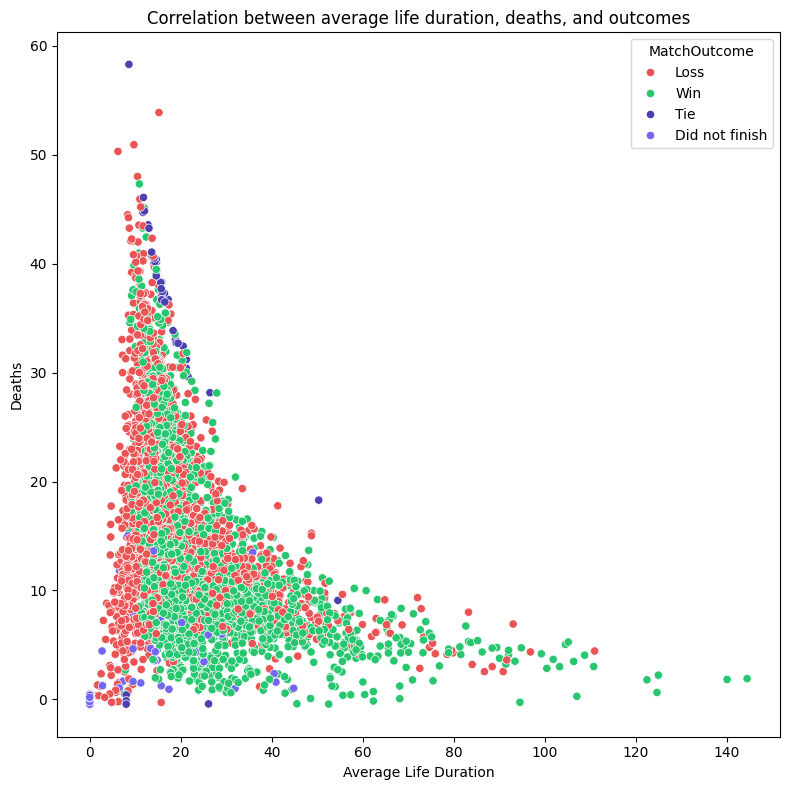

In [132]:
df['Outcome'] = pd.to_numeric(df['Outcome'], errors='coerce')
df['Deaths'] = pd.to_numeric(df['Deaths'], errors='coerce')

outcome_info = {
    1: {'label': 'Tie', 'color': '#4B40B0'},
    2: {'label': 'Win', 'color': '#28C76F'},
    3: {'label': 'Loss', 'color': '#EA5455'},
    4: {'label': 'Did not finish', 'color': '#7367F0'}
}

df['MatchOutcome'] = df['Outcome'].map(lambda x: outcome_info.get(int(x), {}).get('label', 'Unknown'))
df['Deaths_jitter'] = df['Deaths'] + np.random.uniform(-0.5, 0.5, size=len(df))

palette = {outcome_info[key]['label']: outcome_info[key]['color'] for key in outcome_info}

plt.figure(figsize=(8, 8))

sns.scatterplot(x='AverageLifeDuration', y='Deaths_jitter', hue='MatchOutcome', data=df, palette=palette)
plt.title('Correlation between average life duration, deaths, and outcomes')

plt.xlabel('Average Life Duration')
plt.ylabel('Deaths')

plt.tight_layout()
plt.show()


## Correlation between kills, deaths, and outcomes

In [121]:
df = pd.read_sql_query('''SELECT
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') AS StartTime,
    MatchId,
    json_extract(player.value, '$.Outcome') AS Outcome,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Kills') AS Kills,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Deaths') AS Deaths
FROM MatchStats, json_each(Players) AS player
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
	AND json_extract(MatchInfo, '$.UgcGameVariant.AssetId') NOT IN ('1d641733-7cb2-4556-9ec3-f27923af32a1', '15480417-fa8e-49a9-9d4b-e2ae90815562', 'ff451042-bcf2-4173-bd87-0ba8c463c3e0', 'bc7f495b-c516-414e-acff-9718babe97a5', '2c438c28-ac97-4c72-92e4-75f9ab2f612e', 'bff8b7d6-f9f3-44b8-b3c3-59669e154e10', '3ec67f6c-4113-46d3-b94e-b70986625a15', '219f8162-ef34-419e-939b-c3b9dafe3109', 'a598de90-4b3f-420a-83d4-c84ba89bf94c')
ORDER BY StartTime ASC;
''', conn)

df.head(10)

StartTime                               MatchId  Outcome  Kills  \
0  2023-06-20 11:50:46  f16a7423-f9f4-470f-895e-9469e8132dac        3     10   
1  2023-06-20 12:02:21  9e93bf25-c9a7-45e8-ad50-e9b2f6da6b12        2      9   
2  2023-06-20 12:14:13  b6310997-144a-4e88-949e-516b2dd8c5df        2     14   
3  2023-06-20 12:26:10  8f5d828a-d447-4995-9ec0-74d776c987b8        2     10   
4  2023-06-20 13:08:06  34cab12e-8a19-4e78-84e1-fdfca8e182c2        3      5   
5  2023-06-20 13:17:28  836e7403-4655-4552-8e70-f3352bef0890        2      9   
6  2023-06-20 13:32:37  22e65b58-6567-4593-a890-dc4b8a6d3699        3     13   
7  2023-06-20 13:49:06  ec0a8ee1-ccbf-4c8b-a6ec-c51078052fbe        3      9   
8  2023-06-20 14:00:29  7963a124-e5b1-49fa-9763-8a779717c5c5        3      7   
9  2023-06-20 14:16:34  bcafb0ca-f6fa-40f4-89e6-d3dd63b87f11        2     16   

   Deaths  
0       9  
1       9  
2      12  
3      10  
4      16  
5      11  
6      14  
7      15  
8      16  
9       9

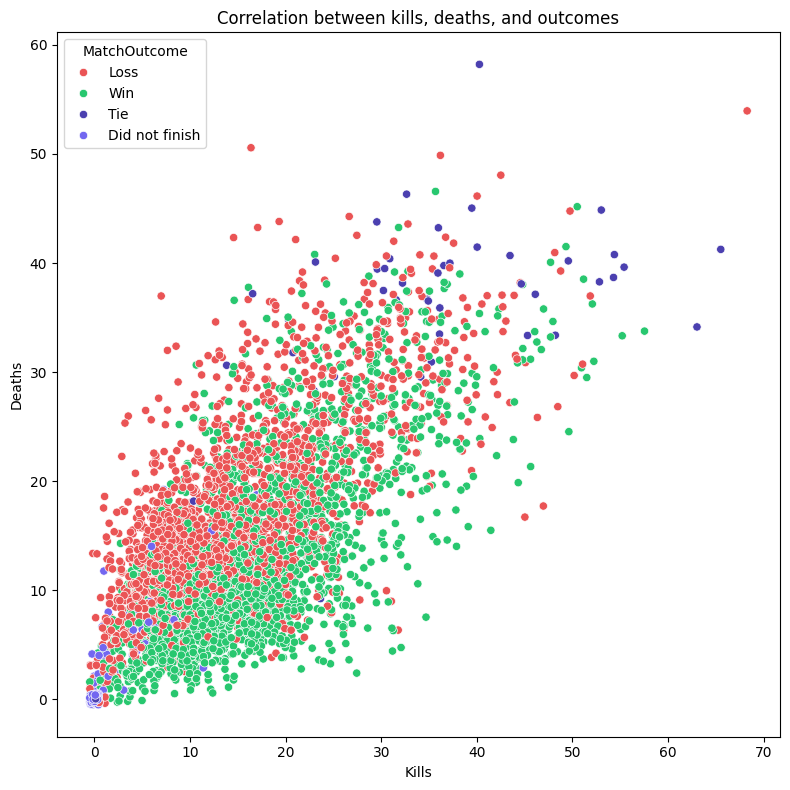

In [122]:
df['Outcome'] = pd.to_numeric(df['Outcome'], errors='coerce')
df['Deaths'] = pd.to_numeric(df['Deaths'], errors='coerce')
df['Kills'] = pd.to_numeric(df['Kills'], errors='coerce')

outcome_info = {
    1: {'label': 'Tie', 'color': '#4B40B0'},
    2: {'label': 'Win', 'color': '#28C76F'},
    3: {'label': 'Loss', 'color': '#EA5455'},
    4: {'label': 'Did not finish', 'color': '#7367F0'}
}

df['MatchOutcome'] = df['Outcome'].map(lambda x: outcome_info.get(int(x), {}).get('label', 'Unknown'))

palette = {outcome_info[key]['label']: outcome_info[key]['color'] for key in outcome_info}

df['Kills_jitter'] = df['Kills'] + np.random.uniform(-0.5, 0.5, size=len(df))
df['Deaths_jitter'] = df['Deaths'] + np.random.uniform(-0.5, 0.5, size=len(df))

plt.figure(figsize=(8, 8))

sns.scatterplot(x='Kills_jitter', y='Deaths_jitter', hue='MatchOutcome', data=df, palette=palette)
plt.title('Correlation between kills, deaths, and outcomes')

plt.xlabel('Kills')
plt.ylabel('Deaths')

plt.tight_layout()
plt.show()

## Correlation between kills, callout assists, and outcomes

In [123]:
df = pd.read_sql_query('''SELECT
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') AS StartTime,
    MatchId,
    json_extract(player.value, '$.Outcome') AS Outcome,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Kills') AS Kills,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.CalloutAssists') AS CalloutAssists
FROM MatchStats, json_each(Players) AS player
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
	AND json_extract(MatchInfo, '$.UgcGameVariant.AssetId') NOT IN ('1d641733-7cb2-4556-9ec3-f27923af32a1', '15480417-fa8e-49a9-9d4b-e2ae90815562', 'ff451042-bcf2-4173-bd87-0ba8c463c3e0', 'bc7f495b-c516-414e-acff-9718babe97a5', '2c438c28-ac97-4c72-92e4-75f9ab2f612e', 'bff8b7d6-f9f3-44b8-b3c3-59669e154e10', '3ec67f6c-4113-46d3-b94e-b70986625a15', '219f8162-ef34-419e-939b-c3b9dafe3109', 'a598de90-4b3f-420a-83d4-c84ba89bf94c')
ORDER BY StartTime ASC;
''', conn)

df.head(10)

StartTime                               MatchId  Outcome  Kills  \
0  2023-06-20 11:50:46  f16a7423-f9f4-470f-895e-9469e8132dac        3     10   
1  2023-06-20 12:02:21  9e93bf25-c9a7-45e8-ad50-e9b2f6da6b12        2      9   
2  2023-06-20 12:14:13  b6310997-144a-4e88-949e-516b2dd8c5df        2     14   
3  2023-06-20 12:26:10  8f5d828a-d447-4995-9ec0-74d776c987b8        2     10   
4  2023-06-20 13:08:06  34cab12e-8a19-4e78-84e1-fdfca8e182c2        3      5   
5  2023-06-20 13:17:28  836e7403-4655-4552-8e70-f3352bef0890        2      9   
6  2023-06-20 13:32:37  22e65b58-6567-4593-a890-dc4b8a6d3699        3     13   
7  2023-06-20 13:49:06  ec0a8ee1-ccbf-4c8b-a6ec-c51078052fbe        3      9   
8  2023-06-20 14:00:29  7963a124-e5b1-49fa-9763-8a779717c5c5        3      7   
9  2023-06-20 14:16:34  bcafb0ca-f6fa-40f4-89e6-d3dd63b87f11        2     16   

   CalloutAssists  
0               6  
1               5  
2              10  
3               3  
4               4  
5               7  
6               8  
7               0  
8               2  
9               6

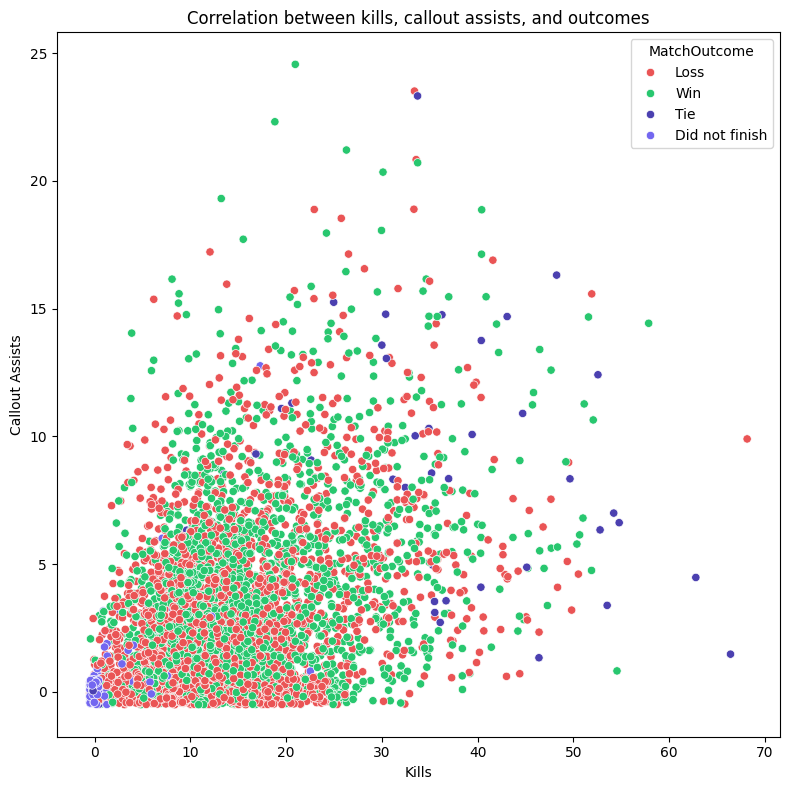

In [124]:
df['Outcome'] = pd.to_numeric(df['Outcome'], errors='coerce')
df['CalloutAssists'] = pd.to_numeric(df['CalloutAssists'], errors='coerce')
df['Kills'] = pd.to_numeric(df['Kills'], errors='coerce')

outcome_info = {
    1: {'label': 'Tie', 'color': '#4B40B0'},
    2: {'label': 'Win', 'color': '#28C76F'},
    3: {'label': 'Loss', 'color': '#EA5455'},
    4: {'label': 'Did not finish', 'color': '#7367F0'}
}

df['MatchOutcome'] = df['Outcome'].map(lambda x: outcome_info.get(int(x), {}).get('label', 'Unknown'))

palette = {outcome_info[key]['label']: outcome_info[key]['color'] for key in outcome_info}

df['Kills_jitter'] = df['Kills'] + np.random.uniform(-0.5, 0.5, size=len(df))
df['CalloutAssists_jitter'] = df['CalloutAssists'] + np.random.uniform(-0.5, 0.5, size=len(df))

plt.figure(figsize=(8, 8))

sns.scatterplot(x='Kills_jitter', y='CalloutAssists_jitter', hue='MatchOutcome', data=df, palette=palette)
plt.title('Correlation between kills, callout assists, and outcomes')

plt.xlabel('Kills')
plt.ylabel('Callout Assists')

plt.tight_layout()
plt.show()

## Correlation between match length, kills, and end-state

In [140]:
df = pd.read_sql_query('''SELECT
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') AS StartTime,
    MatchId,
    json_extract(player.value, '$.Outcome') AS Outcome,
	json_extract(MatchInfo, '$.Duration') AS ISOMatchDuration,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Kills') AS Kills,
    CASE
        WHEN INSTR(json_extract(MatchInfo, '$.Duration'), 'M') > 0 THEN
            CAST(
                SUBSTR(json_extract(MatchInfo, '$.Duration'), 3, INSTR(json_extract(MatchInfo, '$.Duration'), 'M') - 3) AS INTEGER
            ) * 60 +
            CAST(
                SUBSTR(
                    json_extract(MatchInfo, '$.Duration'),
                    INSTR(json_extract(MatchInfo, '$.Duration'), 'M') + 1,
                    LENGTH(json_extract(MatchInfo, '$.Duration')) - INSTR(json_extract(MatchInfo, '$.Duration'), 'M') - 1
                ) AS REAL
            )
        ELSE
            CAST(
                SUBSTR(json_extract(MatchInfo, '$.Duration'), 3, LENGTH(json_extract(MatchInfo, '$.Duration')) - 3) AS REAL
            )
    END AS MatchDurationInSeconds
FROM MatchStats, json_each(Players) AS player
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
	AND json_extract(MatchInfo, '$.UgcGameVariant.AssetId') NOT IN ('1d641733-7cb2-4556-9ec3-f27923af32a1', '15480417-fa8e-49a9-9d4b-e2ae90815562', 'ff451042-bcf2-4173-bd87-0ba8c463c3e0', 'bc7f495b-c516-414e-acff-9718babe97a5', '2c438c28-ac97-4c72-92e4-75f9ab2f612e', 'bff8b7d6-f9f3-44b8-b3c3-59669e154e10', '3ec67f6c-4113-46d3-b94e-b70986625a15', '219f8162-ef34-419e-939b-c3b9dafe3109', 'a598de90-4b3f-420a-83d4-c84ba89bf94c')
ORDER BY StartTime ASC;
''', conn)

df.head(10)

StartTime                               MatchId  Outcome  \
0  2023-06-20 11:50:46  f16a7423-f9f4-470f-895e-9469e8132dac        3   
1  2023-06-20 12:02:21  9e93bf25-c9a7-45e8-ad50-e9b2f6da6b12        2   
2  2023-06-20 12:14:13  b6310997-144a-4e88-949e-516b2dd8c5df        2   
3  2023-06-20 12:26:10  8f5d828a-d447-4995-9ec0-74d776c987b8        2   
4  2023-06-20 13:08:06  34cab12e-8a19-4e78-84e1-fdfca8e182c2        3   
5  2023-06-20 13:17:28  836e7403-4655-4552-8e70-f3352bef0890        2   
6  2023-06-20 13:32:37  22e65b58-6567-4593-a890-dc4b8a6d3699        3   
7  2023-06-20 13:49:06  ec0a8ee1-ccbf-4c8b-a6ec-c51078052fbe        3   
8  2023-06-20 14:00:29  7963a124-e5b1-49fa-9763-8a779717c5c5        3   
9  2023-06-20 14:16:34  bcafb0ca-f6fa-40f4-89e6-d3dd63b87f11        2   

   ISOMatchDuration  Kills  MatchDurationInSeconds  
0   PT9M56.1103872S     10              596.110387  
1  PT10M23.8386314S      9              623.838631  
2  PT10M17.6203188S     14              617.620319  
3   PT7M32.5915182S     10              452.591518  
4   PT7M35.8175632S      5              455.817563  
5   PT12M8.8120301S      9              728.812030  
6  PT11M16.7177428S     13              676.717743  
7    PT9M23.085693S      9              563.085693  
8   PT7M27.4440444S      7              447.444044  
9   PT10M30.661304S     16              630.661304

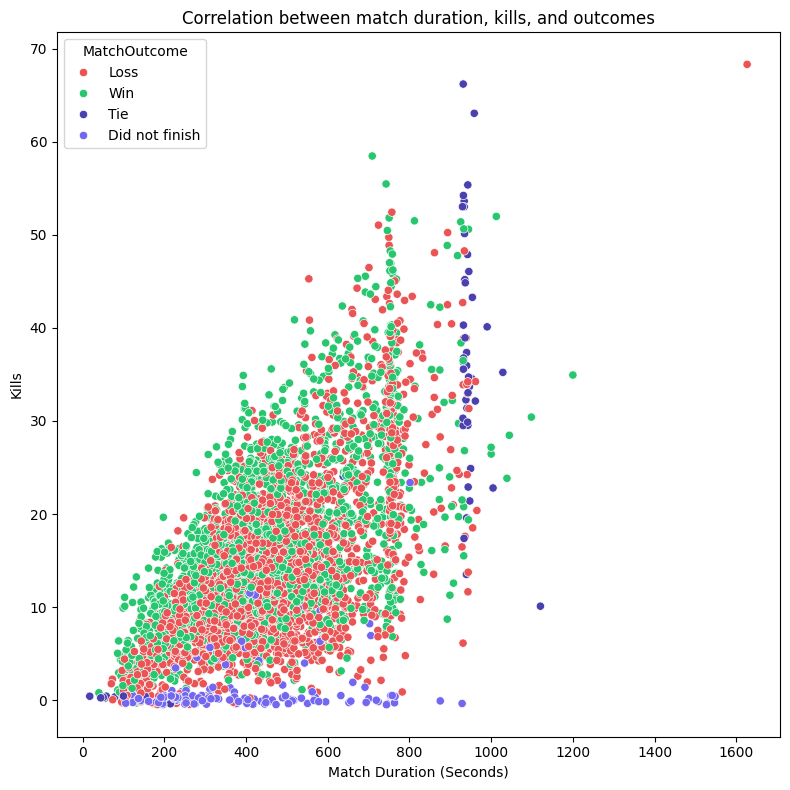

In [141]:
df['Outcome'] = pd.to_numeric(df['Outcome'], errors='coerce')
df['Kills'] = pd.to_numeric(df['Kills'], errors='coerce')

outcome_info = {
    1: {'label': 'Tie', 'color': '#4B40B0'},
    2: {'label': 'Win', 'color': '#28C76F'},
    3: {'label': 'Loss', 'color': '#EA5455'},
    4: {'label': 'Did not finish', 'color': '#7367F0'}
}

df['MatchOutcome'] = df['Outcome'].map(lambda x: outcome_info.get(int(x), {}).get('label', 'Unknown'))

palette = {outcome_info[key]['label']: outcome_info[key]['color'] for key in outcome_info}

df['Kills_jitter'] = df['Kills'] + np.random.uniform(-0.5, 0.5, size=len(df))

plt.figure(figsize=(8, 8))

sns.scatterplot(x='MatchDurationInSeconds', y='Kills_jitter', hue='MatchOutcome', data=df, palette=palette)
plt.title('Correlation between match duration, kills, and outcomes')

plt.ylabel('Kills')
plt.xlabel('Match Duration (Seconds)')

plt.tight_layout()
plt.show()

## Correlation between match length, personal score, and end-state

In [142]:
df = pd.read_sql_query('''SELECT
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') AS StartTime,
    MatchId,
    json_extract(player.value, '$.Outcome') AS Outcome,
	json_extract(MatchInfo, '$.Duration') AS ISOMatchDuration,
	json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.PersonalScore') AS PersonalScore,
    CASE
        WHEN INSTR(json_extract(MatchInfo, '$.Duration'), 'M') > 0 THEN
            CAST(
                SUBSTR(json_extract(MatchInfo, '$.Duration'), 3, INSTR(json_extract(MatchInfo, '$.Duration'), 'M') - 3) AS INTEGER
            ) * 60 +
            CAST(
                SUBSTR(
                    json_extract(MatchInfo, '$.Duration'),
                    INSTR(json_extract(MatchInfo, '$.Duration'), 'M') + 1,
                    LENGTH(json_extract(MatchInfo, '$.Duration')) - INSTR(json_extract(MatchInfo, '$.Duration'), 'M') - 1
                ) AS REAL
            )
        ELSE
            CAST(
                SUBSTR(json_extract(MatchInfo, '$.Duration'), 3, LENGTH(json_extract(MatchInfo, '$.Duration')) - 3) AS REAL
            )
    END AS MatchDurationInSeconds
FROM MatchStats, json_each(Players) AS player
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
	AND json_extract(MatchInfo, '$.UgcGameVariant.AssetId') NOT IN ('1d641733-7cb2-4556-9ec3-f27923af32a1', '15480417-fa8e-49a9-9d4b-e2ae90815562', 'ff451042-bcf2-4173-bd87-0ba8c463c3e0', 'bc7f495b-c516-414e-acff-9718babe97a5', '2c438c28-ac97-4c72-92e4-75f9ab2f612e', 'bff8b7d6-f9f3-44b8-b3c3-59669e154e10', '3ec67f6c-4113-46d3-b94e-b70986625a15', '219f8162-ef34-419e-939b-c3b9dafe3109', 'a598de90-4b3f-420a-83d4-c84ba89bf94c')
ORDER BY StartTime ASC;
''', conn)

df.head(10)

StartTime                               MatchId  Outcome  \
0  2023-06-20 11:50:46  f16a7423-f9f4-470f-895e-9469e8132dac        3   
1  2023-06-20 12:02:21  9e93bf25-c9a7-45e8-ad50-e9b2f6da6b12        2   
2  2023-06-20 12:14:13  b6310997-144a-4e88-949e-516b2dd8c5df        2   
3  2023-06-20 12:26:10  8f5d828a-d447-4995-9ec0-74d776c987b8        2   
4  2023-06-20 13:08:06  34cab12e-8a19-4e78-84e1-fdfca8e182c2        3   
5  2023-06-20 13:17:28  836e7403-4655-4552-8e70-f3352bef0890        2   
6  2023-06-20 13:32:37  22e65b58-6567-4593-a890-dc4b8a6d3699        3   
7  2023-06-20 13:49:06  ec0a8ee1-ccbf-4c8b-a6ec-c51078052fbe        3   
8  2023-06-20 14:00:29  7963a124-e5b1-49fa-9763-8a779717c5c5        3   
9  2023-06-20 14:16:34  bcafb0ca-f6fa-40f4-89e6-d3dd63b87f11        2   

   ISOMatchDuration  PersonalScore  MatchDurationInSeconds  
0   PT9M56.1103872S           1255              596.110387  
1  PT10M23.8386314S           1350              623.838631  
2  PT10M17.6203188S           1850              617.620319  
3   PT7M32.5915182S           1130              452.591518  
4   PT7M35.8175632S            690              455.817563  
5   PT12M8.8120301S           1170              728.812030  
6  PT11M16.7177428S           1680              676.717743  
7    PT9M23.085693S            950              563.085693  
8   PT7M27.4440444S            770              447.444044  
9   PT10M30.661304S           2060              630.661304

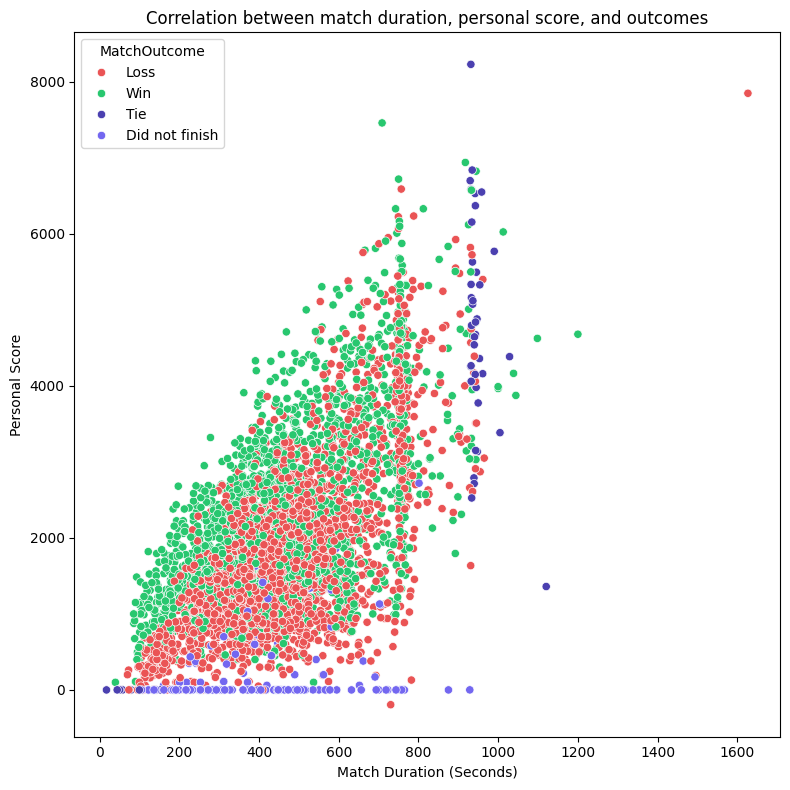

In [143]:
df['Outcome'] = pd.to_numeric(df['Outcome'], errors='coerce')
df['PersonalScore'] = pd.to_numeric(df['PersonalScore'], errors='coerce')

outcome_info = {
    1: {'label': 'Tie', 'color': '#4B40B0'},
    2: {'label': 'Win', 'color': '#28C76F'},
    3: {'label': 'Loss', 'color': '#EA5455'},
    4: {'label': 'Did not finish', 'color': '#7367F0'}
}

df['MatchOutcome'] = df['Outcome'].map(lambda x: outcome_info.get(int(x), {}).get('label', 'Unknown'))

palette = {outcome_info[key]['label']: outcome_info[key]['color'] for key in outcome_info}

df['PS_jitter'] = df['PersonalScore'] + np.random.uniform(-0.5, 0.5, size=len(df))

plt.figure(figsize=(8, 8))

sns.scatterplot(x='MatchDurationInSeconds', y='PS_jitter', hue='MatchOutcome', data=df, palette=palette)
plt.title('Correlation between match duration, personal score, and outcomes')

plt.ylabel('Personal Score')
plt.xlabel('Match Duration (Seconds)')

plt.tight_layout()
plt.show()

## Medals earned

In [25]:
df = pd.read_sql_query('''WITH MatchMedals AS (SELECT
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') AS StartTime,
    MatchId,
	json_extract(medal.value, '$.Count') AS MedalCount,
	json_extract(medal.value, '$.NameId') AS MedalNameId
FROM MatchStats, json_each(Players) AS player, json_each(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Medals')) AS medal
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
ORDER BY StartTime ASC)

SELECT SUM(MedalCount) Medals, MedalNameId
FROM MatchMedals
GROUP BY MedalNameId
ORDER BY Medals DESC
''', conn)

df.head(10)

Medals  MedalNameId
0   10799    622331684
1    7649   1169571763
2    3234     87172902
3    2361   2063152177
4    2066   2123530881
5    1793   3233952928
6    1786   2602963073
7    1727   2780740615
8    1395   2625820422
9    1320   2477555653

In [26]:
with open('medals.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

name_id_to_medal = {medal['nameId']: medal['name']['value'] for medal in data['medals']}

In [63]:
df['MedalName'] = df['MedalNameId'].map(name_id_to_medal)
df['MedalName'] = df['MedalName'].astype(str)

df.head(120)

Medals  MedalNameId        MedalName
0     10799    622331684      Double Kill
1      7649   1169571763      Shot Caller
2      3234     87172902     Odin's Raven
3      2361   2063152177      Triple Kill
4      2066   2123530881         Reversal
..      ...          ...              ...
108       1   1685043466  Treasure Hunter
109       1   1472686630  Always Rotating
110       1   1210968206              nan
111       1    976049027       Flag Joust
112       1    175594566        Hold This

[113 rows x 3 columns]

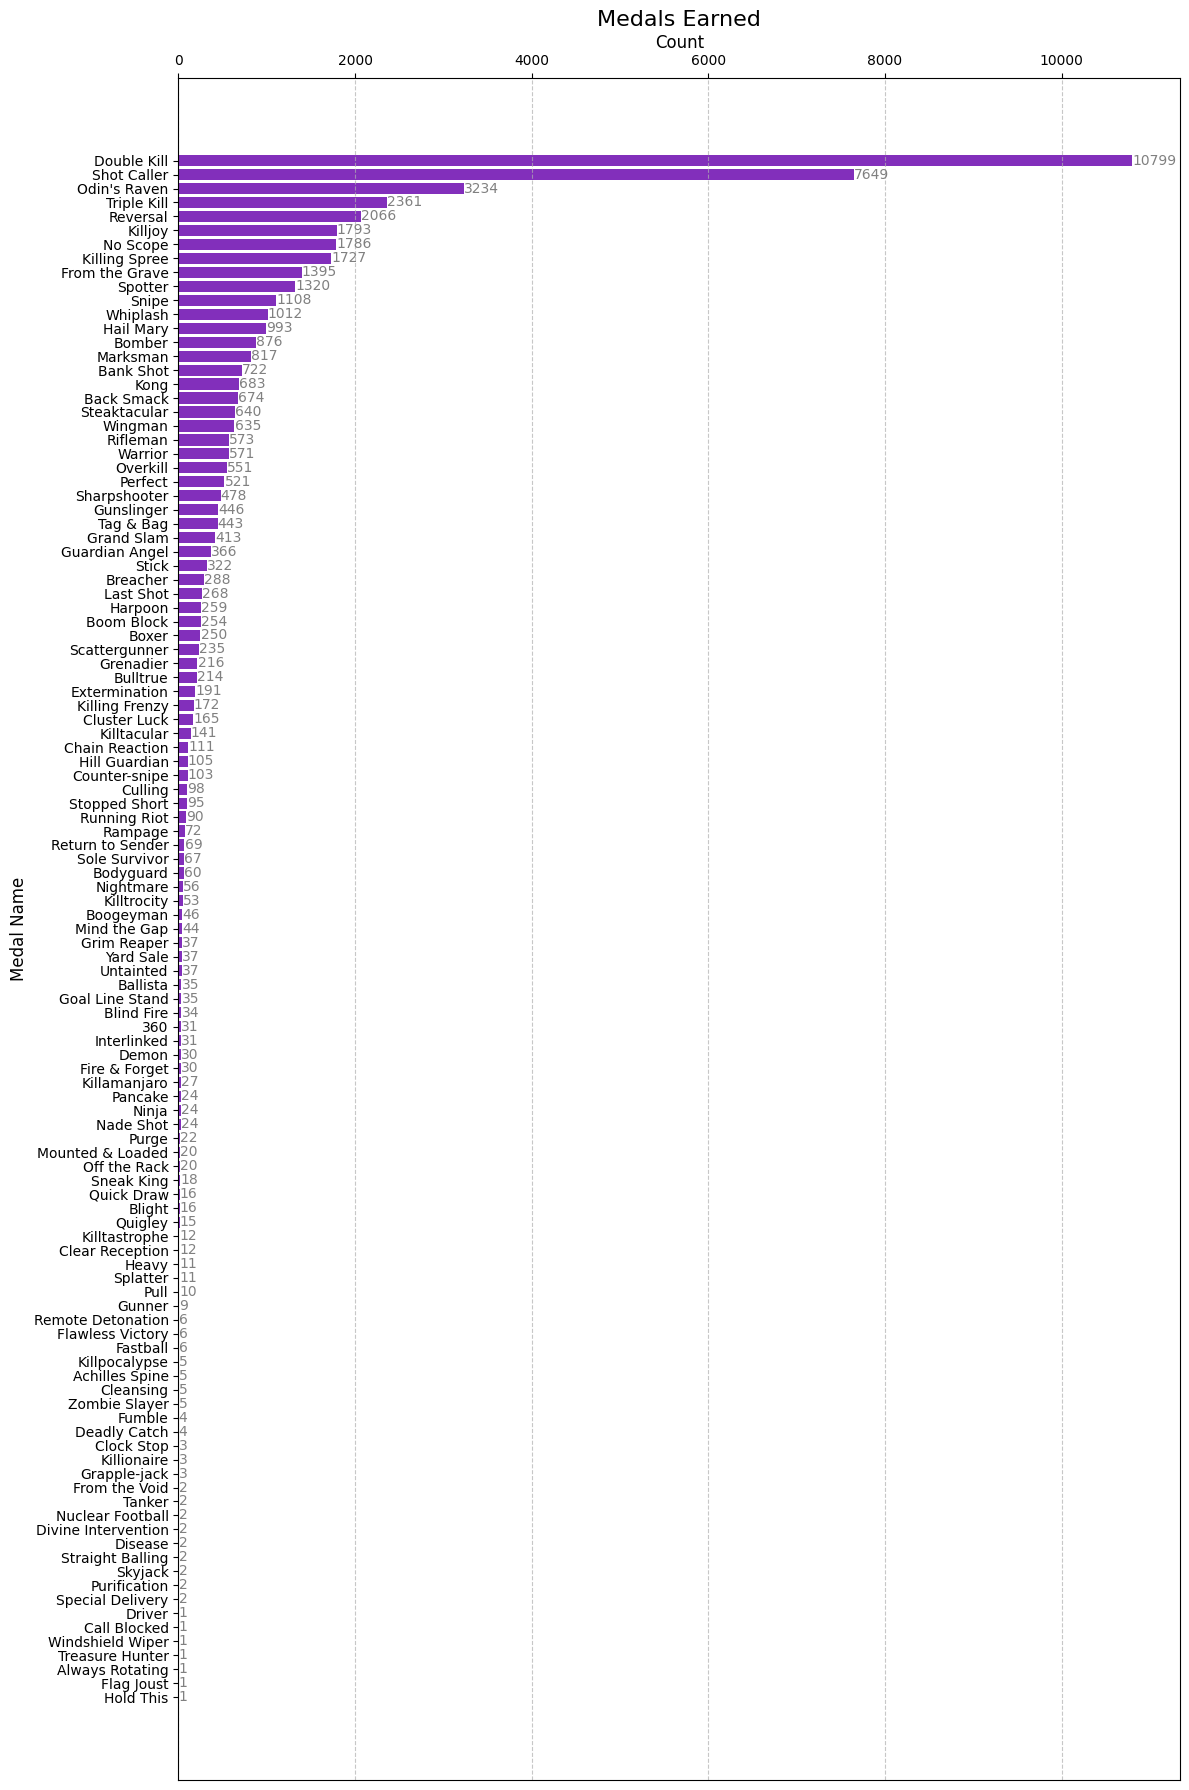

In [65]:
df = df[df['MedalName'] != 'nan']

plt.figure(figsize=(12, 18))
bars = plt.barh(df['MedalName'], df['Medals'], color='#822fbb')

plt.title('Medals Earned', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Medal Name', fontsize=12)
plt.gca().invert_yaxis()
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()

plt.grid(True, axis='x', linestyle='--', alpha=0.7)

for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{bar.get_width()}', 
             va='center', ha='left', fontsize=10, color='gray')

plt.tight_layout()
plt.show()

## Medals earned per match

In [5]:
df = pd.read_sql_query('''WITH MatchMedals AS (SELECT
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') AS StartTime,
    MatchId,
	json_extract(medal.value, '$.Count') AS MedalCount,
	json_extract(medal.value, '$.NameId') AS MedalNameId
FROM MatchStats, json_each(Players) AS player, json_each(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Medals')) AS medal
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
	AND json_extract(MatchInfo, '$.UgcGameVariant.AssetId') NOT IN ('1d641733-7cb2-4556-9ec3-f27923af32a1', '15480417-fa8e-49a9-9d4b-e2ae90815562', 'ff451042-bcf2-4173-bd87-0ba8c463c3e0', 'bc7f495b-c516-414e-acff-9718babe97a5', '2c438c28-ac97-4c72-92e4-75f9ab2f612e', 'bff8b7d6-f9f3-44b8-b3c3-59669e154e10', '3ec67f6c-4113-46d3-b94e-b70986625a15', '219f8162-ef34-419e-939b-c3b9dafe3109', 'a598de90-4b3f-420a-83d4-c84ba89bf94c')
ORDER BY StartTime ASC)

SELECT StartTime, SUM(MedalCount) Medals, MatchId
FROM MatchMedals
GROUP BY MatchId
ORDER BY StartTime ASC
''', conn)

df.head(10)

StartTime  Medals                               MatchId
0  2023-06-20 11:50:46       3  f16a7423-f9f4-470f-895e-9469e8132dac
1  2023-06-20 12:02:21       6  9e93bf25-c9a7-45e8-ad50-e9b2f6da6b12
2  2023-06-20 12:14:13       7  b6310997-144a-4e88-949e-516b2dd8c5df
3  2023-06-20 12:26:10       6  8f5d828a-d447-4995-9ec0-74d776c987b8
4  2023-06-20 13:08:06       6  34cab12e-8a19-4e78-84e1-fdfca8e182c2
5  2023-06-20 13:17:28       8  836e7403-4655-4552-8e70-f3352bef0890
6  2023-06-20 13:32:37       7  22e65b58-6567-4593-a890-dc4b8a6d3699
7  2023-06-20 13:49:06       2  ec0a8ee1-ccbf-4c8b-a6ec-c51078052fbe
8  2023-06-20 14:00:29       4  7963a124-e5b1-49fa-9763-8a779717c5c5
9  2023-06-20 14:16:34      11  bcafb0ca-f6fa-40f4-89e6-d3dd63b87f11

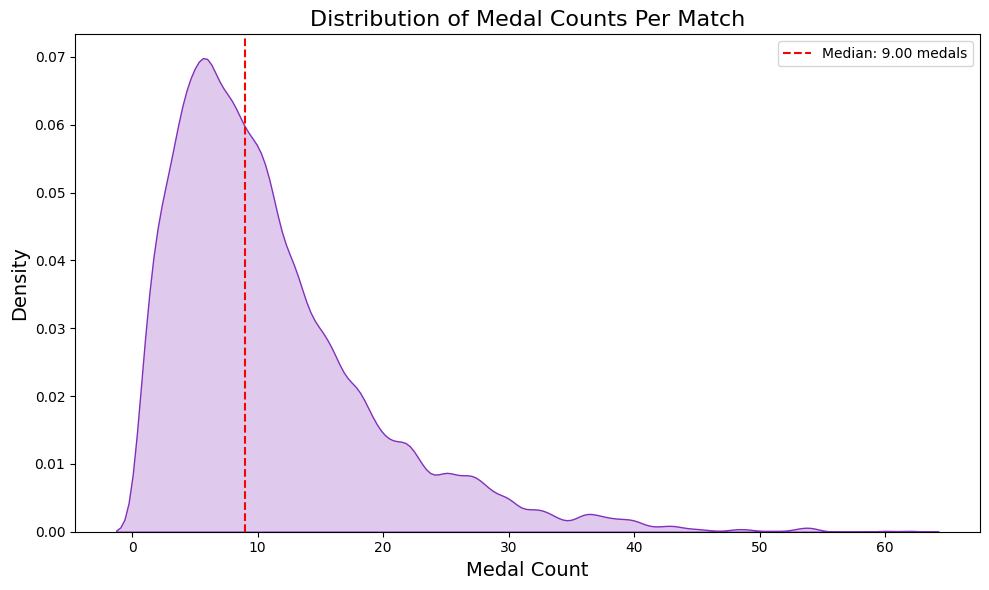

In [6]:
median_mepm = df['Medals'].median()

plt.figure(figsize=(10, 6))

sns.kdeplot(df['Medals'], fill=True, color='#822fbb', bw_adjust=0.5)

plt.axvline(median_mepm, color='red', linestyle='--', label=f'Median: {median_mepm:.2f} medals')

plt.title('Distribution of Medal Counts Per Match', fontsize=16)
plt.xlabel('Medal Count', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()

plt.tight_layout()
plt.show()

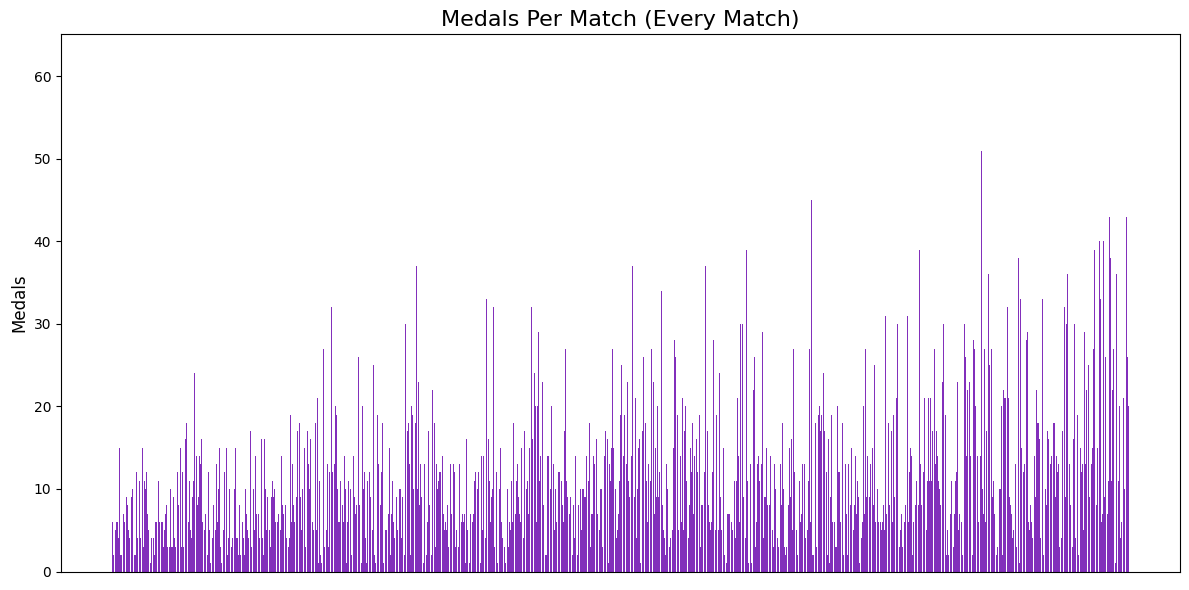

In [7]:
plt.figure(figsize=(12, 6))

plt.bar(df['StartTime'], df['Medals'], color='#822fbb')

plt.title('Medals Per Match (Every Match)', fontsize=16)
plt.ylabel('Medals', fontsize=12)

plt.gca().xaxis.set_visible(False)

plt.tight_layout()

plt.show()

## Medals per month

In [8]:
df = pd.read_sql_query('''WITH MatchMedals AS (SELECT
    strftime('%Y-%m', datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime')) AS StartTime,
    MatchId,
	json_extract(medal.value, '$.Count') AS MedalCount,
	json_extract(medal.value, '$.NameId') AS MedalNameId
FROM MatchStats, json_each(Players) AS player, json_each(json_extract(player.value, '$.PlayerTeamStats[0].Stats.CoreStats.Medals')) AS medal
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
	AND json_extract(MatchInfo, '$.UgcGameVariant.AssetId') NOT IN ('1d641733-7cb2-4556-9ec3-f27923af32a1', '15480417-fa8e-49a9-9d4b-e2ae90815562', 'ff451042-bcf2-4173-bd87-0ba8c463c3e0', 'bc7f495b-c516-414e-acff-9718babe97a5', '2c438c28-ac97-4c72-92e4-75f9ab2f612e', 'bff8b7d6-f9f3-44b8-b3c3-59669e154e10', '3ec67f6c-4113-46d3-b94e-b70986625a15', '219f8162-ef34-419e-939b-c3b9dafe3109', 'a598de90-4b3f-420a-83d4-c84ba89bf94c')
ORDER BY StartTime ASC)

SELECT StartTime, SUM(MedalCount) Medals
FROM MatchMedals
GROUP BY StartTime
ORDER BY StartTime ASC
''', conn)

df.head(10)

StartTime  Medals
0   2023-06    1249
1   2023-07    1327
2   2023-08    1848
3   2023-09    1688
4   2023-10    2922
5   2023-11    2742
6   2023-12    2817
7   2024-01    4181
8   2024-02    2974
9   2024-03    4251

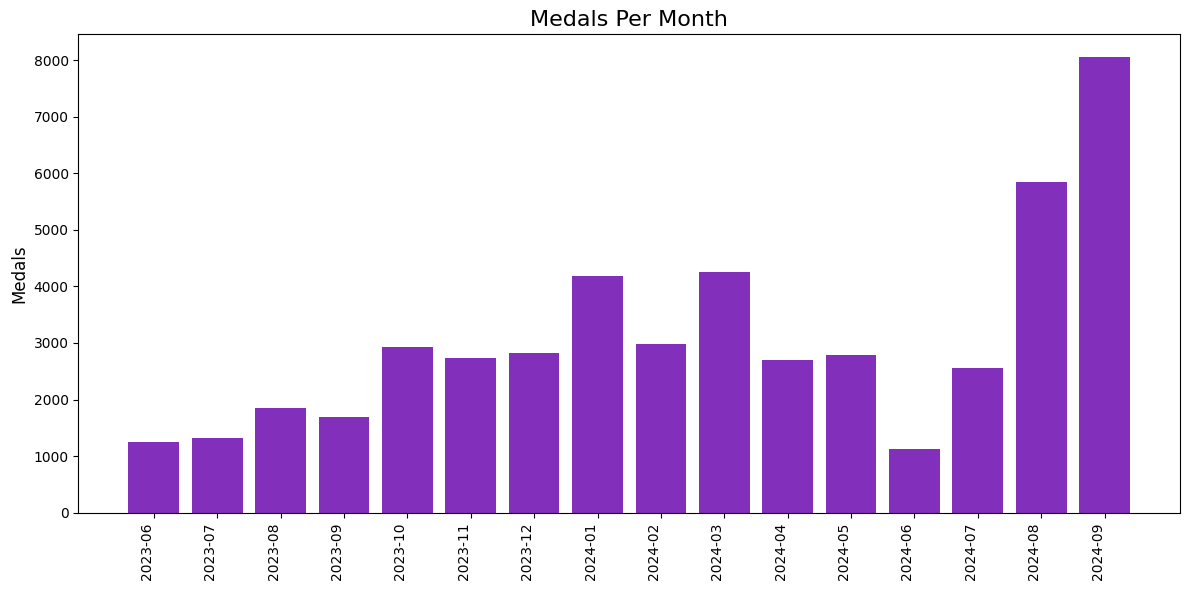

In [12]:
plt.figure(figsize=(12, 6))

plt.bar(df['StartTime'], df['Medals'], color='#822fbb')

plt.title('Medals Per Month', fontsize=16)
plt.ylabel('Medals', fontsize=12)
plt.xticks(rotation=90, ha='right')
plt.tight_layout()

plt.show()

## Match frequency per date and time

In [38]:
df = pd.read_sql_query('''WITH MatchMedals AS (SELECT
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') AS StartTime,
    MatchId
FROM MatchStats, json_each(Players) AS player
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
ORDER BY StartTime ASC)

SELECT StartTime, MatchId
FROM MatchMedals
GROUP BY MatchId
ORDER BY StartTime ASC
''', conn)

df.head(10)

StartTime                               MatchId
0  2023-06-20 11:50:46  f16a7423-f9f4-470f-895e-9469e8132dac
1  2023-06-20 12:02:21  9e93bf25-c9a7-45e8-ad50-e9b2f6da6b12
2  2023-06-20 12:14:13  b6310997-144a-4e88-949e-516b2dd8c5df
3  2023-06-20 12:26:10  8f5d828a-d447-4995-9ec0-74d776c987b8
4  2023-06-20 13:08:06  34cab12e-8a19-4e78-84e1-fdfca8e182c2
5  2023-06-20 13:17:28  836e7403-4655-4552-8e70-f3352bef0890
6  2023-06-20 13:32:37  22e65b58-6567-4593-a890-dc4b8a6d3699
7  2023-06-20 13:49:06  ec0a8ee1-ccbf-4c8b-a6ec-c51078052fbe
8  2023-06-20 14:00:29  7963a124-e5b1-49fa-9763-8a779717c5c5
9  2023-06-20 14:16:34  bcafb0ca-f6fa-40f4-89e6-d3dd63b87f11

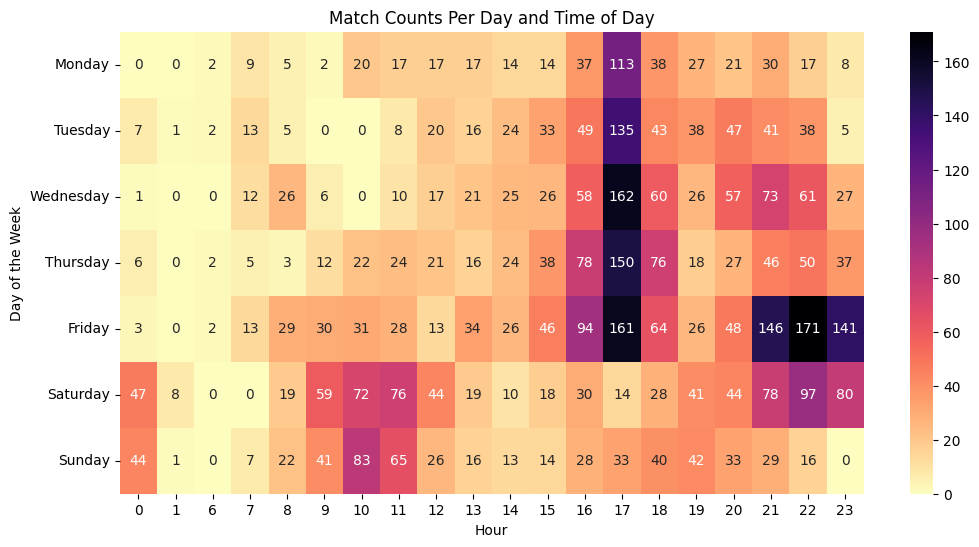

In [39]:
df['StartTime'] = pd.to_datetime(df['StartTime'])

# Extract day of the week and hour of the day
df['DayOfWeek'] = df['StartTime'].dt.day_name()
df['Hour'] = df['StartTime'].dt.hour

# Pivot table to get counts of entries for each combination of day and hour
heatmap_data = df.pivot_table(index='DayOfWeek', columns='Hour', aggfunc='size', fill_value=0)

# Reorder the days of the week for proper visualization
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(days_order)

purple_palette = sns.color_palette("magma_r", as_cmap=True)

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap=purple_palette, annot=True, fmt="d")
plt.title('Match Counts Per Day and Time of Day')
plt.xlabel('Hour')
plt.ylabel('Day of the Week')
plt.show()

## Likelihood of winning depending on time of day and day of week

In [40]:
df = pd.read_sql_query('''WITH MatchMedals AS (SELECT
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') AS StartTime,
    MatchId,
    json_extract(player.value, '$.Outcome') AS Outcome
FROM MatchStats, json_each(Players) AS player
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
ORDER BY StartTime ASC)

SELECT StartTime, MatchId, Outcome
FROM MatchMedals
GROUP BY MatchId
ORDER BY StartTime ASC
''', conn)

df.head(10)

StartTime                               MatchId  Outcome
0  2023-06-20 11:50:46  f16a7423-f9f4-470f-895e-9469e8132dac        3
1  2023-06-20 12:02:21  9e93bf25-c9a7-45e8-ad50-e9b2f6da6b12        2
2  2023-06-20 12:14:13  b6310997-144a-4e88-949e-516b2dd8c5df        2
3  2023-06-20 12:26:10  8f5d828a-d447-4995-9ec0-74d776c987b8        2
4  2023-06-20 13:08:06  34cab12e-8a19-4e78-84e1-fdfca8e182c2        3
5  2023-06-20 13:17:28  836e7403-4655-4552-8e70-f3352bef0890        2
6  2023-06-20 13:32:37  22e65b58-6567-4593-a890-dc4b8a6d3699        3
7  2023-06-20 13:49:06  ec0a8ee1-ccbf-4c8b-a6ec-c51078052fbe        3
8  2023-06-20 14:00:29  7963a124-e5b1-49fa-9763-8a779717c5c5        3
9  2023-06-20 14:16:34  bcafb0ca-f6fa-40f4-89e6-d3dd63b87f11        2

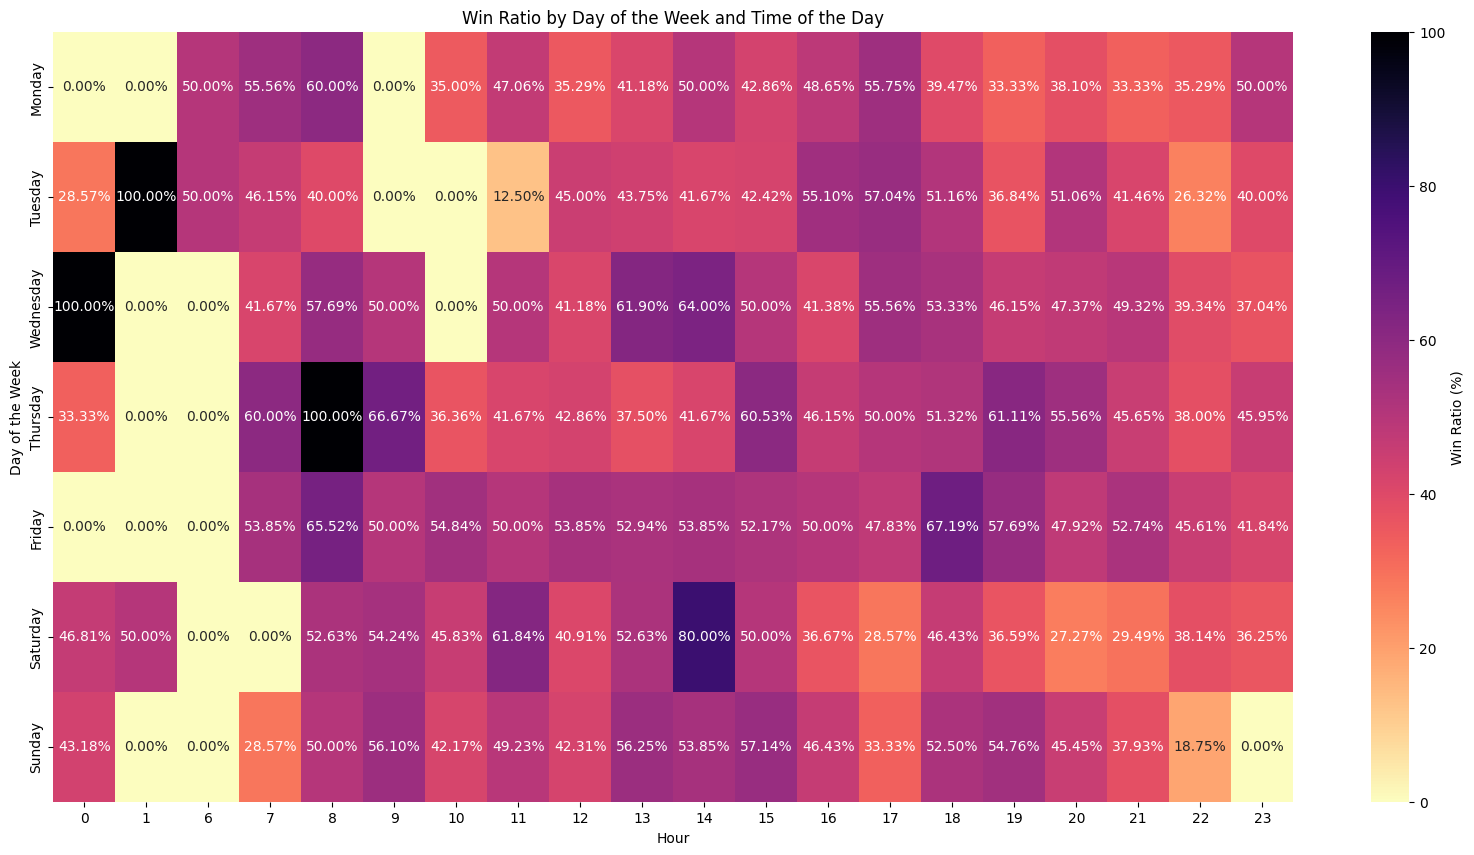

In [41]:
# Convert 'StartTime' to datetime format
df['StartTime'] = pd.to_datetime(df['StartTime'])

# Extract day of the week and hour of the day
df['DayOfWeek'] = df['StartTime'].dt.day_name()
df['Hour'] = df['StartTime'].dt.hour

# Filter outcomes (1 or 2 are considered wins)
df['IsWin'] = df['Outcome'].isin([1, 2]).astype(int)

# Group by day of the week and hour, calculate win ratio (mean of 'IsWin')
win_ratio = df.groupby(['DayOfWeek', 'Hour'])['IsWin'].mean().unstack(fill_value=0)

# Multiply the win ratios by 100 to convert them into percentages
win_ratio *= 100

# Reorder the days of the week for proper visualization
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
win_ratio = win_ratio.reindex(days_order)

# Create a cubehelix palette for the heatmap
purple_palette = sns.color_palette("magma_r", as_cmap=True)
#purple_palette = sns.color_palette("rocket_r", as_cmap=True)

# Plot the heatmap with the cubehelix palette
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(win_ratio, cmap=purple_palette, annot=True, fmt=".2f", cbar_kws={'label': 'Win Ratio (%)'})

# Custom format to append % sign
for text in heatmap.texts:
    text.set_text(f'{float(text.get_text()):.2f}%')

plt.title('Win Ratio by Day of the Week and Time of the Day')
plt.xlabel('Hour')
plt.ylabel('Day of the Week')
plt.show()

## Matches at the top of the board

In [76]:
df = pd.read_sql_query('''WITH MatchMedals AS (
    SELECT
        date(datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime', 'weekday 0', '-6 days')) AS WeekStartDate,
        MatchId,
        json_extract(player.value, '$.Outcome') AS Outcome,
        json_extract(player.value, '$.Rank') AS Rank,
        json_extract(player.value, '$.LastTeamId') AS LastTeamId,
        json_array_length(Teams) AS NumberOfTeams,
        json_extract(player.value, '$.PlayerId') AS PlayerId
    FROM MatchStats, json_each(Players) AS player
    WHERE 
        datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
        AND json_extract(MatchInfo, '$.LifecycleMode') = 3
	ORDER BY WeekStartDate ASC
),

BestTeamRank AS (
    SELECT
        MatchId,
        json_extract(player.value, '$.LastTeamId') AS LastTeamId,
        MIN(CAST(json_extract(player.value, '$.Rank') AS INTEGER)) AS BestTeamRank
    FROM MatchStats, json_each(Players) AS player
    GROUP BY MatchId, json_extract(player.value, '$.LastTeamId')
)

SELECT 
    mm.WeekStartDate, 
    mm.PlayerId, 
    COUNT(DISTINCT mm.MatchId) AS MatchesAtTop,
    (SELECT COUNT(DISTINCT MatchId) 
     FROM MatchMedals 
     WHERE PlayerId = mm.PlayerId 
     AND WeekStartDate = mm.WeekStartDate) AS TotalMatchesPlayedThisWeek
FROM MatchMedals AS mm
JOIN BestTeamRank AS tmr
    ON mm.MatchId = tmr.MatchId AND mm.LastTeamId = tmr.LastTeamId
WHERE 
    mm.PlayerId = 'xuid(2533274855333605)' AND
    (
        (mm.Outcome = 2 AND mm.Rank = 1) -- Case where the player won the match and was ranked 1st
        OR (mm.LastTeamId = tmr.LastTeamId AND mm.Rank = tmr.BestTeamRank AND mm.NumberOfTeams >=2) -- Case where the player was the highest-ranked player on their team
    )
GROUP BY mm.WeekStartDate, mm.PlayerId
ORDER BY mm.WeekStartDate ASC;
''', conn)

df.head(10)

WeekStartDate                PlayerId  MatchesAtTop  \
0    2023-06-19  xuid(2533274855333605)            34   
1    2023-06-26  xuid(2533274855333605)            23   
2    2023-07-03  xuid(2533274855333605)            13   
3    2023-07-10  xuid(2533274855333605)            13   
4    2023-07-17  xuid(2533274855333605)            10   
5    2023-07-24  xuid(2533274855333605)            30   
6    2023-07-31  xuid(2533274855333605)            29   
7    2023-08-07  xuid(2533274855333605)             8   
8    2023-08-14  xuid(2533274855333605)             8   
9    2023-08-21  xuid(2533274855333605)            36   

   TotalMatchesPlayedThisWeek  
0                         104  
1                          62  
2                          57  
3                          44  
4                          37  
5                          56  
6                          89  
7                          39  
8                          24  
9                         117

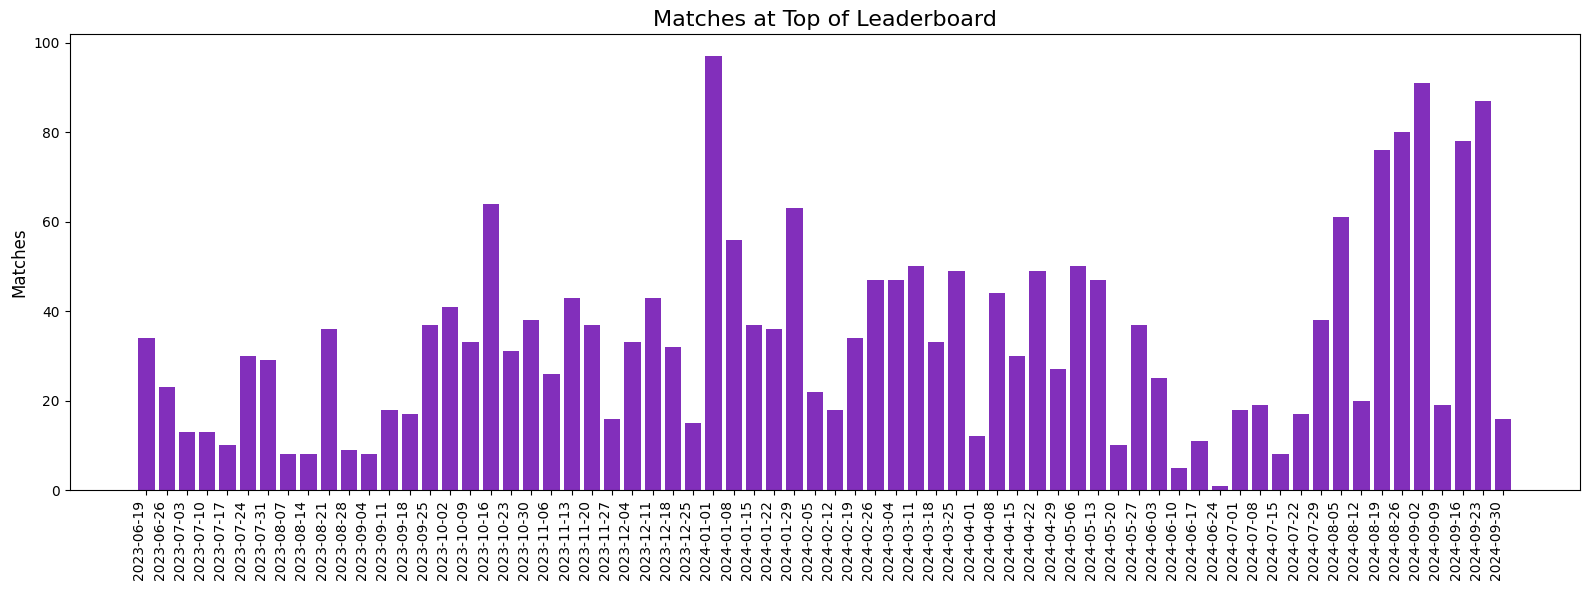

In [77]:
plt.figure(figsize=(16, 6))

plt.bar(df['WeekStartDate'], df['MatchesAtTop'], color='#822fbb')

plt.title('Matches at Top of Leaderboard', fontsize=16)
plt.ylabel('Matches', fontsize=12)
plt.xticks(rotation=90, ha='right')
plt.tight_layout()

plt.show()

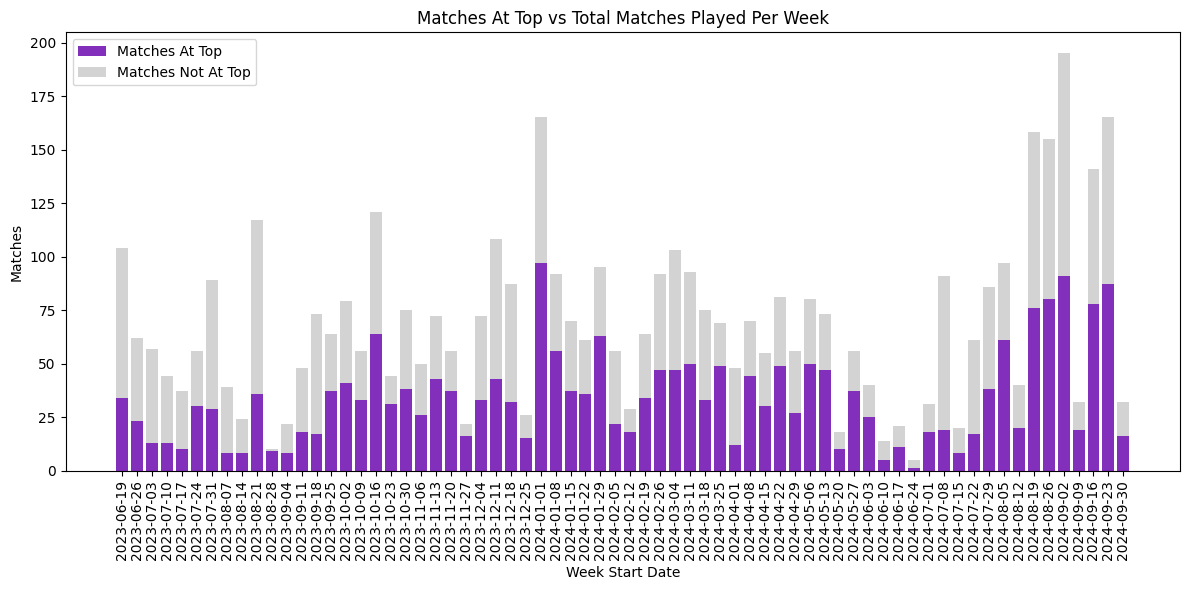

In [78]:
df['NotAtTop'] = df['TotalMatchesPlayedThisWeek'] - df['MatchesAtTop']

# Set the position of bars on the x-axis
x = np.arange(len(df['WeekStartDate']))

# Create the figure and axis with a larger size
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the width and height as needed

# Create the stacked bar chart
bars1 = ax.bar(x, df['MatchesAtTop'], label='Matches At Top', color='#822fbb')
bars2 = ax.bar(x, df['NotAtTop'], bottom=df['MatchesAtTop'], label='Matches Not At Top', color='lightgrey')

# Adding labels and title
ax.set_xlabel('Week Start Date')
ax.set_ylabel('Matches')
ax.set_title('Matches At Top vs Total Matches Played Per Week')
ax.set_xticks(x)
ax.set_xticklabels(df['WeekStartDate'], rotation=90)  # Rotate x-axis labels by 90 degrees
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

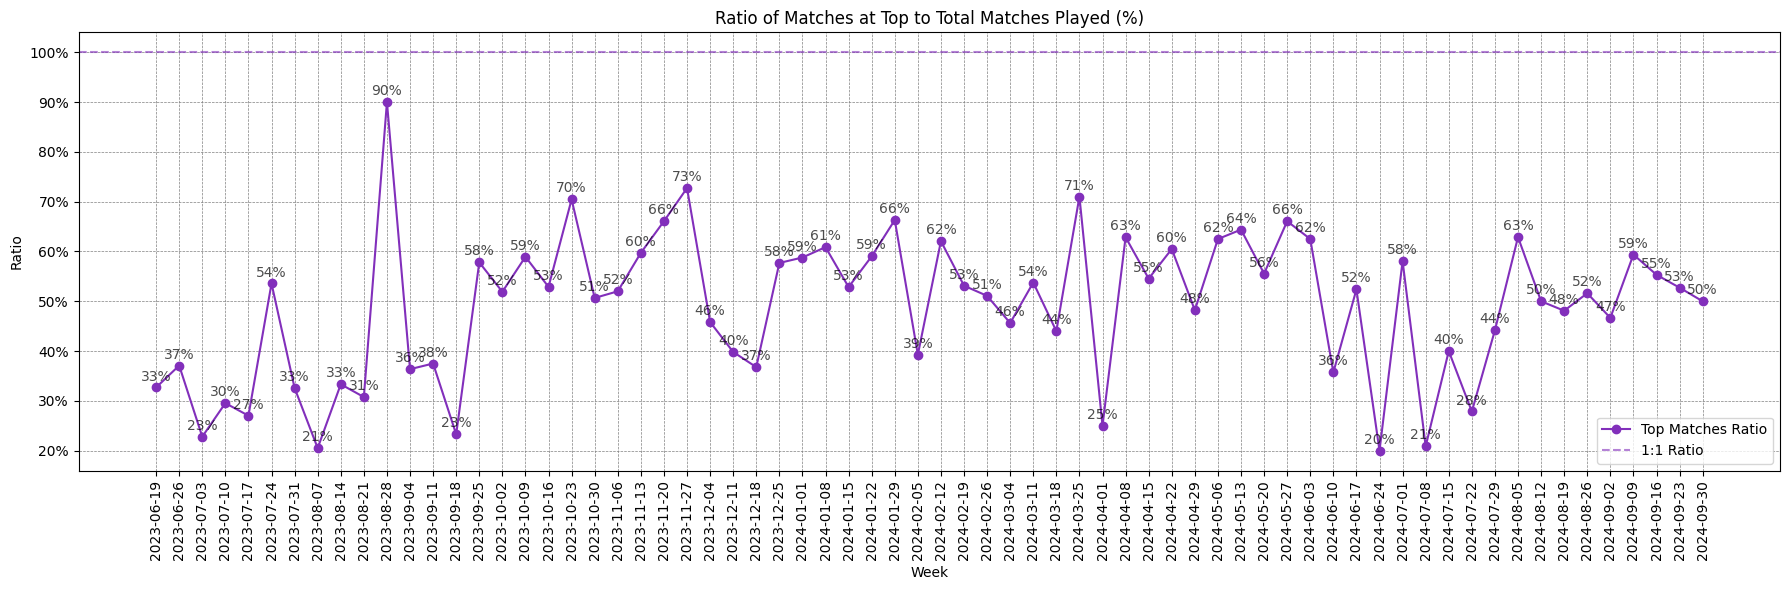

In [79]:
df['Ratio'] = df['MatchesAtTop'] / df['TotalMatchesPlayedThisWeek']

# Create the figure and axis with a larger size
fig, ax = plt.subplots(figsize=(18, 6))

# Plot the ratio with updated color
ax.plot(df['WeekStartDate'], df['Ratio'], marker='o', color='#822fbb', label='Top Matches Ratio')

# Annotate each data point with the percentage
for i, txt in enumerate(df['Ratio']):
    ax.annotate(f'{txt:.0%}', (df['WeekStartDate'][i], df['Ratio'][i]), 
                textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10, color='black', alpha=0.7)

# Set labels and title
ax.set_xlabel('Week')
ax.set_ylabel('Ratio')
ax.set_title('Ratio of Matches at Top to Total Matches Played (%)')
ax.set_xticks(df['WeekStartDate'])
ax.set_xticklabels(df['WeekStartDate'], rotation=90)  # Rotate x-axis labels by 90 degrees

# Add a reference line for the 1:1 ratio
ax.axhline(1, color='#822fbb', linestyle='--', label='1:1 Ratio', alpha=0.6)  # Reference line at ratio = 1
ax.legend()

# Set y-axis to percentage format
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))

# Add grid lines
ax.grid(color='gray', linestyle='--', linewidth=0.5)  # Customize grid appearance as needed

# Show the plot
plt.tight_layout()
plt.show()

## MMR variability

In [3]:
df = pd.read_sql_query('''WITH PlayerInfo AS (
    SELECT
		MatchId,
        json_extract(player.value, '$.Result.TeamId') AS PlayerTeamId,
        json_extract(player.value, '$.Result.TeamMmr') AS PlayerTeamMmr,
        player.value AS PlayerStats
    FROM PlayerMatchStats, json_each(PlayerStats) AS player
    WHERE json_extract(player.value, '$.Id') = 'xuid(2533274855333605)'
),

RequiredMatches AS (
	SELECT
		datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') AS StartDate,
        MatchId,
        json_extract(player.value, '$.Outcome') AS Outcome,
        json_extract(player.value, '$.LastTeamId') AS LastTeamId,
        json_array_length(Teams) AS NumberOfTeams,
        json_extract(player.value, '$.PlayerId') AS PlayerId
    FROM MatchStats, json_each(Players) AS player
    WHERE 
        datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
        AND json_extract(MatchInfo, '$.LifecycleMode') = 3
		AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
		AND NumberOfTeams = 2
	ORDER BY StartDate ASC
)

SELECT
	rm.StartDate,
	rm.MatchId,
    PlayerTeamId,
	rm.LastTeamId,
    PlayerTeamMmr,
    json_extract(PlayerStats, '$.Result.TeamMmrs.' || key) AS EnemyTeamMmr
FROM PlayerInfo pi, json_each(json_extract(PlayerStats, '$.Result.TeamMmrs'))
JOIN RequiredMatches rm on pi.MatchId = rm.MatchId
WHERE json_extract(PlayerStats, '$.Result.TeamMmrs.' || key) != PlayerTeamMmr
ORDER BY rm.StartDate ASC
''', conn)

df.head(10)

StartDate                               MatchId  PlayerTeamId  \
0  2023-06-20 12:02:21  9e93bf25-c9a7-45e8-ad50-e9b2f6da6b12             0   
1  2023-06-20 12:26:10  8f5d828a-d447-4995-9ec0-74d776c987b8             0   
2  2023-06-20 13:08:06  34cab12e-8a19-4e78-84e1-fdfca8e182c2             1   
3  2023-06-20 13:17:28  836e7403-4655-4552-8e70-f3352bef0890             0   
4  2023-06-20 13:32:37  22e65b58-6567-4593-a890-dc4b8a6d3699             1   
5  2023-06-20 13:49:06  ec0a8ee1-ccbf-4c8b-a6ec-c51078052fbe             1   
6  2023-06-20 14:00:29  7963a124-e5b1-49fa-9763-8a779717c5c5             1   
7  2023-06-20 14:16:34  bcafb0ca-f6fa-40f4-89e6-d3dd63b87f11             0   
8  2023-06-20 14:29:28  8b724862-6321-429d-aa00-cd1d7c093907             1   
9  2023-06-20 14:46:50  fe3ac5ee-f89b-4298-b78c-8d0c3d43ebf4             0   

   LastTeamId  PlayerTeamMmr  EnemyTeamMmr  
0           1    1170.486584   1205.149951  
1           0     720.023933    720.776720  
2           0     793.320048    756.146209  
3           1     641.792823    640.929850  
4           0     623.286518    622.135595  
5           0     605.188458    636.348389  
6           0     519.984728    565.384095  
7           1     525.863442    524.931812  
8           0     552.706205    550.105364  
9           0     582.598069    595.420221

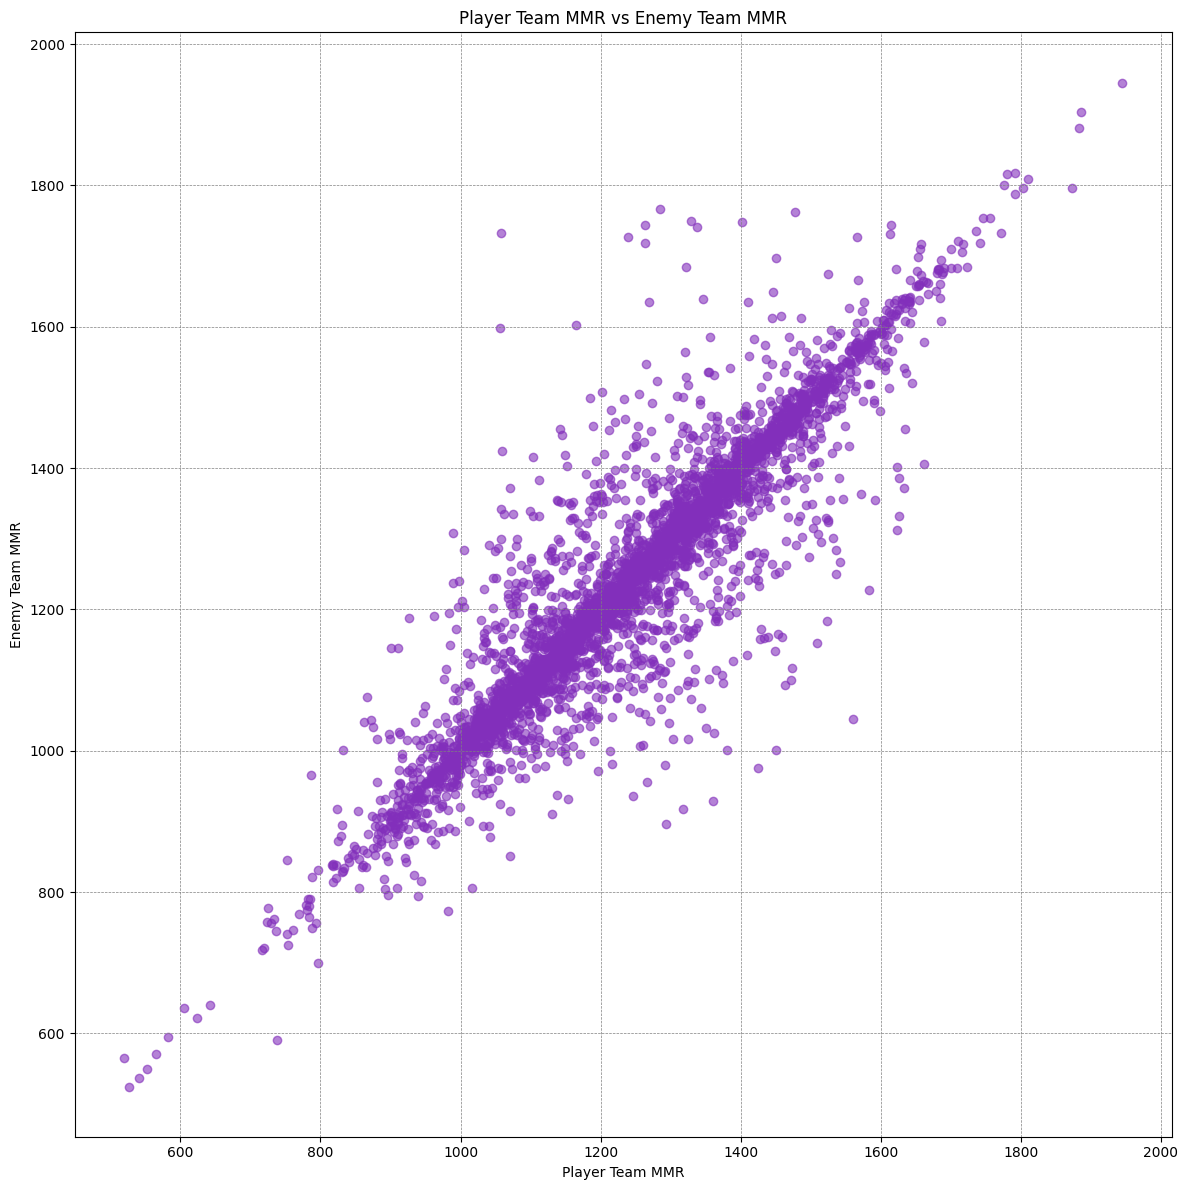

In [4]:
fig, ax = plt.subplots(figsize=(12, 12))

# Create a scatter plot with Player Team MMR on the X-axis and Enemy Team MMR on the Y-axis
ax.scatter(df['PlayerTeamMmr'], df['EnemyTeamMmr'], color='#822fbb', alpha=0.6)

# Set labels and title
ax.set_xlabel('Player Team MMR')
ax.set_ylabel('Enemy Team MMR')
ax.set_title('Player Team MMR vs Enemy Team MMR')

# Add a grid
ax.grid(color='gray', linestyle='--', linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()

In [5]:
df = pd.read_sql_query('''WITH PlayerInfo AS (
    SELECT
		MatchId,
        json_extract(player.value, '$.Result.TeamId') AS PlayerTeamId,
        json_extract(player.value, '$.Result.TeamMmr') AS PlayerTeamMmr,
        player.value AS PlayerStats
    FROM PlayerMatchStats, json_each(PlayerStats) AS player
    WHERE json_extract(player.value, '$.Id') = 'xuid(2533274855333605)'
),

RequiredMatches AS (
	SELECT
		datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') AS StartDate,
        MatchId,
        json_extract(player.value, '$.Outcome') AS Outcome,
        json_extract(player.value, '$.LastTeamId') AS LastTeamId,
        json_array_length(Teams) AS NumberOfTeams,
        json_extract(player.value, '$.PlayerId') AS PlayerId,
		json_extract(player.value, '$.Outcome') AS Outcome
    FROM MatchStats, json_each(Players) AS player
    WHERE 
        datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
        AND json_extract(MatchInfo, '$.LifecycleMode') = 3
		AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
		AND NumberOfTeams = 2
	ORDER BY StartDate ASC
)

SELECT
	rm.StartDate,
	rm.MatchId,
    PlayerTeamId,
	rm.LastTeamId,
	rm.Outcome,
    PlayerTeamMmr,
    json_extract(PlayerStats, '$.Result.TeamMmrs.' || key) AS EnemyTeamMmr
FROM PlayerInfo pi, json_each(json_extract(PlayerStats, '$.Result.TeamMmrs'))
JOIN RequiredMatches rm on pi.MatchId = rm.MatchId
WHERE json_extract(PlayerStats, '$.Result.TeamMmrs.' || key) != PlayerTeamMmr
ORDER BY rm.StartDate ASC
''', conn)

df.head(10)

StartDate                               MatchId  PlayerTeamId  \
0  2023-06-20 12:02:21  9e93bf25-c9a7-45e8-ad50-e9b2f6da6b12             0   
1  2023-06-20 12:26:10  8f5d828a-d447-4995-9ec0-74d776c987b8             0   
2  2023-06-20 13:08:06  34cab12e-8a19-4e78-84e1-fdfca8e182c2             1   
3  2023-06-20 13:17:28  836e7403-4655-4552-8e70-f3352bef0890             0   
4  2023-06-20 13:32:37  22e65b58-6567-4593-a890-dc4b8a6d3699             1   
5  2023-06-20 13:49:06  ec0a8ee1-ccbf-4c8b-a6ec-c51078052fbe             1   
6  2023-06-20 14:00:29  7963a124-e5b1-49fa-9763-8a779717c5c5             1   
7  2023-06-20 14:16:34  bcafb0ca-f6fa-40f4-89e6-d3dd63b87f11             0   
8  2023-06-20 14:29:28  8b724862-6321-429d-aa00-cd1d7c093907             1   
9  2023-06-20 14:46:50  fe3ac5ee-f89b-4298-b78c-8d0c3d43ebf4             0   

   LastTeamId  Outcome  PlayerTeamMmr  EnemyTeamMmr  
0           1        2    1170.486584   1205.149951  
1           0        2     720.023933    720.776720  
2           0        3     793.320048    756.146209  
3           1        2     641.792823    640.929850  
4           0        3     623.286518    622.135595  
5           0        3     605.188458    636.348389  
6           0        3     519.984728    565.384095  
7           1        2     525.863442    524.931812  
8           0        3     552.706205    550.105364  
9           0        2     582.598069    595.420221

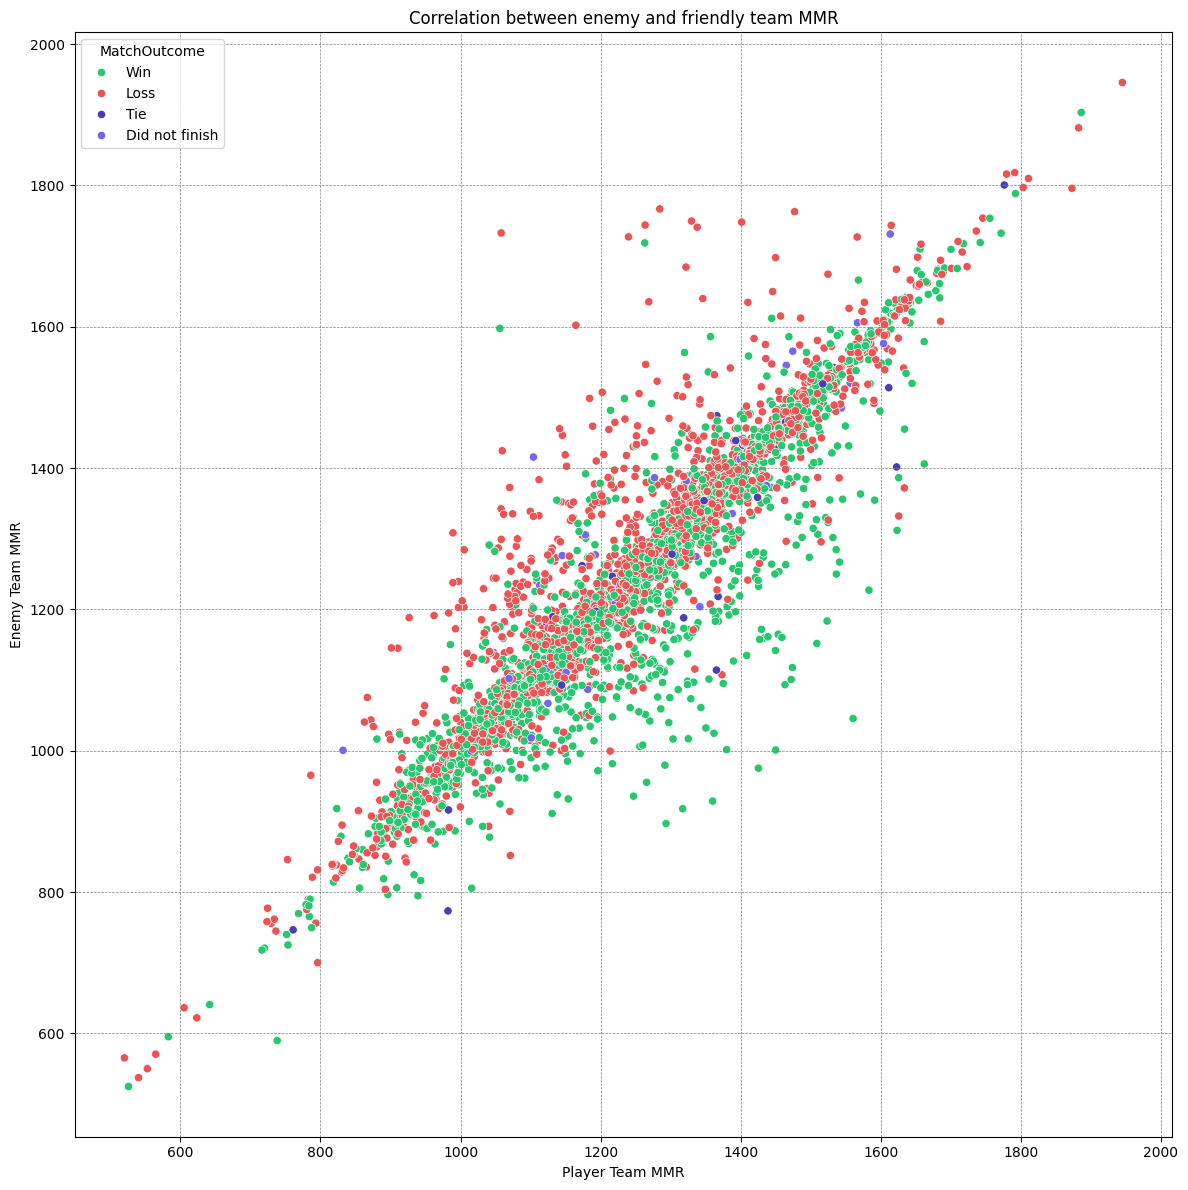

In [9]:
outcome_info = {
    1: {'label': 'Tie', 'color': '#4B40B0'},
    2: {'label': 'Win', 'color': '#28C76F'},
    3: {'label': 'Loss', 'color': '#EA5455'},
    4: {'label': 'Did not finish', 'color': '#7367F0'}
}

df['MatchOutcome'] = df['Outcome'].map(lambda x: outcome_info.get(int(x), {}).get('label', 'Unknown'))

palette = {outcome_info[key]['label']: outcome_info[key]['color'] for key in outcome_info}

plt.figure(figsize=(12, 12))

sns.scatterplot(x='PlayerTeamMmr', y='EnemyTeamMmr', hue='MatchOutcome', data=df, palette=palette)
plt.title('Correlation between enemy and friendly team MMR')

plt.ylabel('Enemy Team MMR')
plt.xlabel('Player Team MMR')

# Add a grid to the plot
plt.grid(visible=True, which='both', color='gray', linestyle='--', linewidth=0.5)


plt.tight_layout()
plt.show()